In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

import cmocean
import cmocean.cm as cmo
import seaborn as sns


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## import data

In [2]:
df_o2 = pd.read_csv('../Dissertation_projects/Data/CTD/O2_Summary_Stats.csv', sep=',', index_col=0)

In [3]:
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

# convert columns to numeric data type
df_iron['FeT_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')
df_iron['Fe2_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')

df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [4]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

In [5]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [6]:
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

In [7]:
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

In [8]:
df_spectra_bc = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_BC.csv',sep=',', index_col=0)
df_spectra_pw = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_PW.csv',sep=',', index_col=0)
df_spectra_wc = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_WC.csv',sep=',', index_col=0)
df_spectra_rz = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_RZ.csv',sep=',', index_col=0)

df_spectra_bc.columns = ['a' + col for col in df_spectra_bc.columns]
df_spectra_pw.columns = ['a' + col for col in df_spectra_pw.columns]
df_spectra_wc.columns = ['a' + col for col in df_spectra_wc.columns]
df_spectra_rz.columns = ['a' + col for col in df_spectra_rz.columns]

In [9]:
df_c = pd.read_csv('../Dissertation_projects/Data/CDOM/Outputs.csv', sep=',', index_col=0)

df_c['Sample_idx'] = df_c.index.astype(object)
df_meta['Sample_idx'] = df_meta.index.astype(object)

df_c.index = df_c['file_id']

df_cdom = df_c.merge(df_meta, on="Sample_idx", how="left")

df_cdom.index = df_cdom['Sample_idx']
df_cdom['Sample'] = df_cdom.index
df_cdom.index = df_cdom['Sample']
df_cdom = df_cdom.drop('Sample_idx', axis = 1)
df_meta = df_meta.drop('Sample_idx', axis = 1)

In [10]:
#get BC data sets 
df_cdom_bc = df_cdom[df_cdom['Type'] == 'LANDSYR']
df_iron_bc = df_iron[df_iron['Type'] == 'BC']
df_doc_bc = df_doc[df_doc['Type'] == 'BC']

#get PW data sets 
df_cdom_pw = df_cdom[df_cdom['Type'] == 'PW']
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
df_doc_pw = df_doc[df_doc['Type'] == 'PW']

#get WC data sets 
df_cdom_wc = df_cdom[df_cdom['Type'] == 'NISK']
df_iron_wc = df_iron[df_iron['Type'] == 'WC']
df_doc_wc = df_doc[df_doc['Type'] == 'WC']

#get RHZ data 
df_cdom_rz = df_cdom[df_cdom['Type'] == 'RHZ']
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ', 'GBRZ'])]
df_doc_rz = df_doc[df_doc['Type'] == 'RZ']

In [11]:
df_met = df_meta

df_spectra_bc['Sample_idx'] = df_spectra_bc.index.astype(object)
df_met['Sample_idx'] = df_met.index.astype(object)

df_cdom_bc = df_spectra_bc.merge(df_met, on="Sample_idx", how="left")

df_cdom_bc.index = df_cdom_bc['Sample_idx']
df_cdom_bc['Sample'] = df_cdom_bc.index
df_cdom_bc.index = df_cdom_bc['Sample']
df_cdom_bc = df_cdom_bc.drop('Sample_idx', axis = 1)

df_cdom_bc['code'].unique()

array(['St.11_GOM2021', 'St.13_GOM2021', 'St.14_GOM2021', 'St.15_GOM2021',
       'St.16_GOM2021', 'St.2_GOM2021', 'St.5B_GOM2021', 'St.7_GOM2021',
       'St.9_GOM2021', 'St.MK_GOM2021', 'St.11_GOM21FA', 'St.12_GOM21FA',
       'St.13_GOM21FA', 'St.14_GOM21FA', 'St.15_GOM21FA', 'St.16_GOM21FA',
       'St.5B_GOM21FA', 'St.7_GOM21FA', 'St.9_GOM21FA', 'St.MK_GOM21FA',
       'St.13_GOM22SP', 'St.14_GOM22SP', 'St.15_GOM22SP', 'St.16_GOM22SP',
       'St.2_GOM22SP', 'St.4_GOM22SP', 'St.5B_GOM22SP', 'St.7_GOM22SP',
       'St.9_GOM22SP', 'St.MK_GOM22SU', 'St.11_GOM22SU', 'St.12_GOM22SU',
       'St.13_GOM22SU', 'St.14_GOM22SU', 'St.15_GOM22SU', 'St.16_GOM22SU',
       'St.2_GOM22SU', 'St.4_GOM22SU', 'St.5B_GOM22SU', 'St.7_GOM22SU',
       'St.9_GOM22SU'], dtype=object)

In [12]:
df_met = df_meta

df_spectra_pw['Sample_idx'] = df_spectra_pw.index.astype(object)
df_met['Sample_idx'] = df_met.index.astype(object)

df_cdom_pw = df_spectra_pw.merge(df_met, on="Sample_idx", how="left")

df_cdom_pw.index = df_cdom_pw['Sample_idx']
df_cdom_pw['Sample'] = df_cdom_pw.index
df_cdom_pw.index = df_cdom_pw['Sample']
df_cdom_pw = df_cdom_pw.drop('Sample_idx', axis = 1)

df_cdom_pw['code'].unique()


array(['St.14_GOM2021', 'St.2_GOM2021', 'St.15_GOM2021', 'St.16_GOM2021',
       'St.11_GOM2021', 'St.7_GOM2021', 'St.5B_GOM21FA', 'St.4_GOM21FA',
       'St.MK_GOM21FA', 'St.7_GOM21FA', 'St.14_GOM21FA', 'St.9_GOM21FA',
       'St.15_GOM21FA', 'St.2_GOM21FA', 'St.13_GOM21FA', 'St.16_GOM21FA',
       'St.12_GOM21FA', 'St.11_GOM21FA', 'St.7_GOM22SP', 'St.14_GOM22SP',
       'St.16_GOM22SP', 'St.5B_GOM22SP', 'St.15_GOM22SP', 'St.9_GOM22SP',
       'St.2_GOM22SP', 'St.13_GOM22SP', 'St.MK_GOM22SP', 'St.4_GOM22SP',
       'St.4_GOM22SU', 'St.5B_GOM22SU', 'St.14_GOM22SU', 'St.7_GOM22SU',
       'St.9_GOM22SU', 'St.15_GOM22SU', 'St.13_GOM22SU', 'St.2_GOM22SU',
       'St.12_GOM22SU', 'St.16_GOM22SU', 'St.11_GOM22SU', 'St.MK_GOM22SU'],
      dtype=object)

## Data for flux calculations 

In [13]:
#hights data
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

In [14]:
#porosity data 
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

In [15]:
#location data 
df_lat_lon = df_meta.groupby('code').agg({'Lat': 'mean', 'Lon': 'mean'}).reset_index().set_index('code')

## slope calculations

In [16]:
#figure calculate pore water 

#DOC slopes pore water 
codes = df_cdom_pw['code'].unique()

print(codes)
len(codes)

['St.14_GOM2021' 'St.2_GOM2021' 'St.15_GOM2021' 'St.16_GOM2021'
 'St.11_GOM2021' 'St.7_GOM2021' 'St.5B_GOM21FA' 'St.4_GOM21FA'
 'St.MK_GOM21FA' 'St.7_GOM21FA' 'St.14_GOM21FA' 'St.9_GOM21FA'
 'St.15_GOM21FA' 'St.2_GOM21FA' 'St.13_GOM21FA' 'St.16_GOM21FA'
 'St.12_GOM21FA' 'St.11_GOM21FA' 'St.7_GOM22SP' 'St.14_GOM22SP'
 'St.16_GOM22SP' 'St.5B_GOM22SP' 'St.15_GOM22SP' 'St.9_GOM22SP'
 'St.2_GOM22SP' 'St.13_GOM22SP' 'St.MK_GOM22SP' 'St.4_GOM22SP'
 'St.4_GOM22SU' 'St.5B_GOM22SU' 'St.14_GOM22SU' 'St.7_GOM22SU'
 'St.9_GOM22SU' 'St.15_GOM22SU' 'St.13_GOM22SU' 'St.2_GOM22SU'
 'St.12_GOM22SU' 'St.16_GOM22SU' 'St.11_GOM22SU' 'St.MK_GOM22SU']


40

In [17]:
#figure calculate pore water 

#DOC slopes pore water 
df_doc_pw_plot = df_doc_pw[(df_doc_pw['NPOC_uM'] != 0)]
df_doc_pw_plot = df_doc_pw_plot.dropna(subset=["NPOC_uM"])
codes = df_doc_pw_plot['code'].unique()

print(codes)
len(codes)

['St.5B_GOM21FA' 'St.4_GOM21FA' 'St.MK_GOM21FA' 'St.7_GOM21FA'
 'St.13_GOM21FA' 'St.14_GOM21FA' 'St.9_GOM21FA' 'St.15_GOM21FA'
 'St.16_GOM21FA' 'St.11_GOM21FA' 'St.2_GOM21FA' 'St.12_GOM21FA'
 'St.MK_GOM2021' 'St.11_GOM2021' 'St.7_GOM2021' 'St.5B_GOM2021'
 'St.4_GOM2021' 'St.9_GOM2021' 'St.14_GOM2021' 'St.15_GOM2021'
 'St.2_GOM2021' 'St.16_GOM2021' 'St.2_GOM22SP' 'St.13_GOM22SP'
 'St.MK_GOM22SP' 'St.4_GOM22SP' 'St.7_GOM22SP' 'St.14_GOM22SP'
 'St.16_GOM22SP' 'St.15_GOM22SP' 'St.9_GOM22SP' 'St.4_GOM22SU'
 'St.14_GOM22SU' 'St.7_GOM22SU' 'St.9_GOM22SU' 'St.15_GOM22SU'
 'St.13_GOM22SU' 'St.2_GOM22SU' 'St.12_GOM22SU' 'St.MK_GOM22SU'
 'St.11_GOM22SU' 'St.5B_GOM22SU']


42

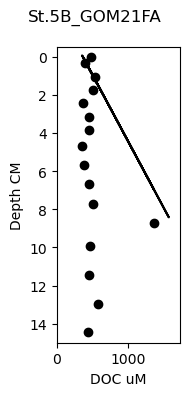

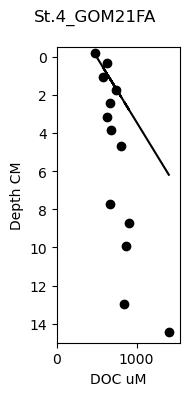

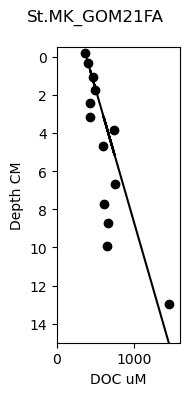

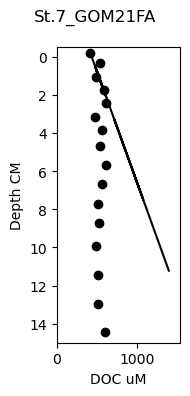

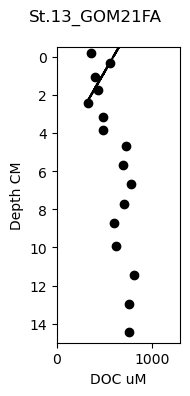

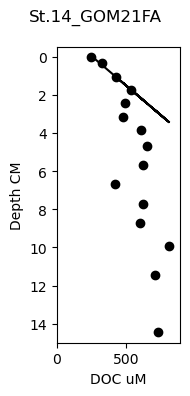

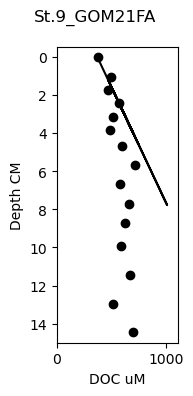

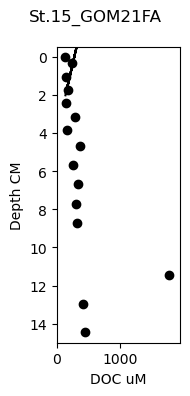

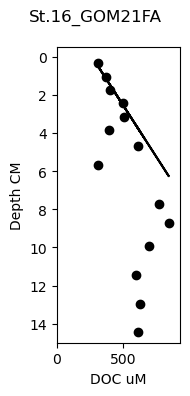

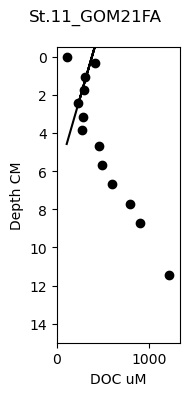

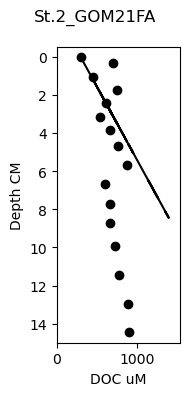

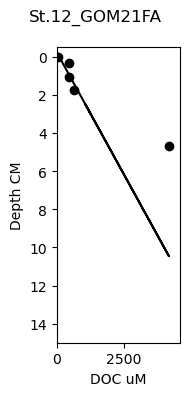

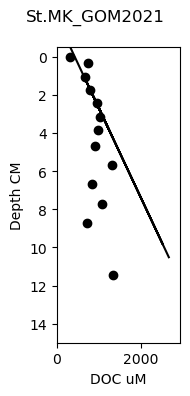

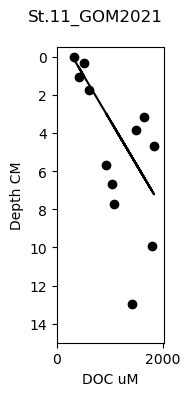

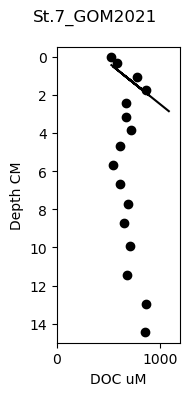

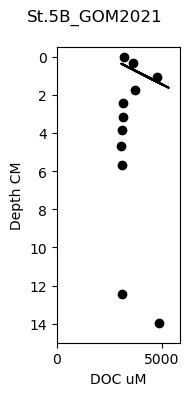

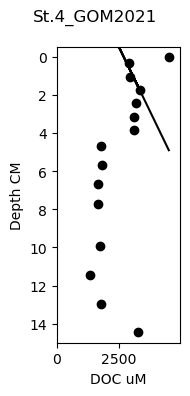

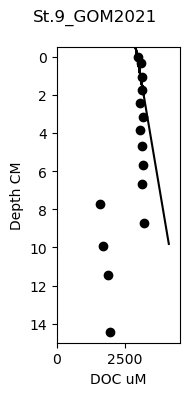

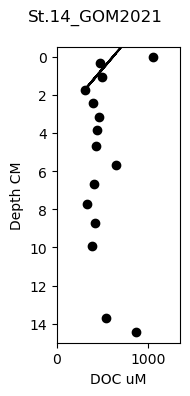

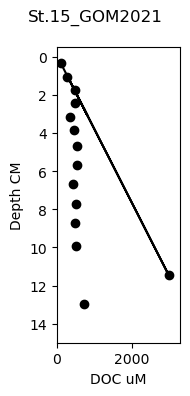

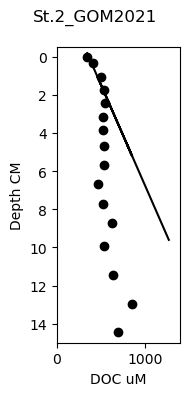

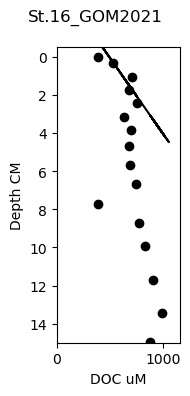

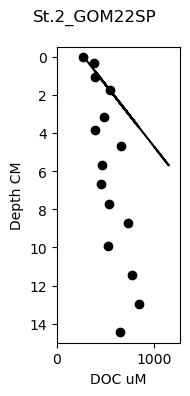

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3758519681.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


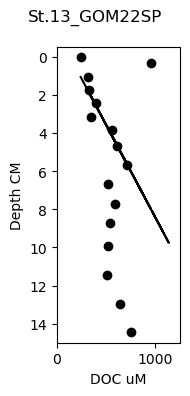

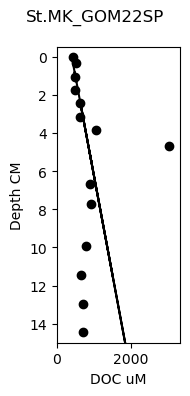

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3758519681.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


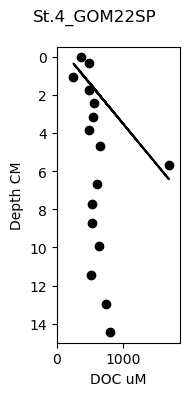

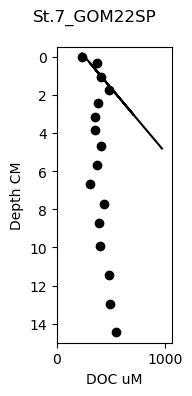

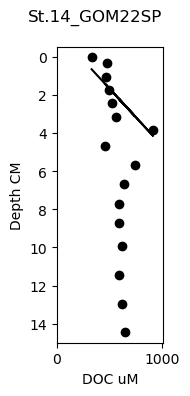

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3758519681.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


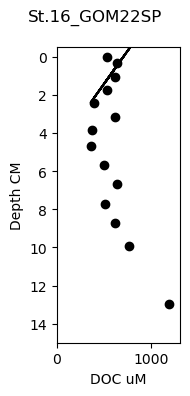

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3758519681.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


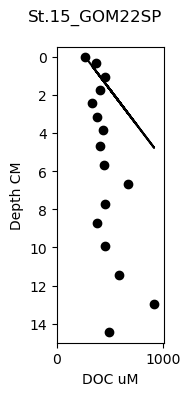

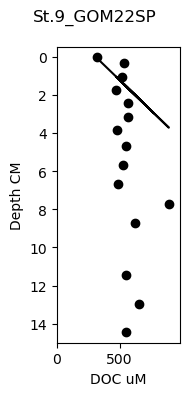

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3758519681.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


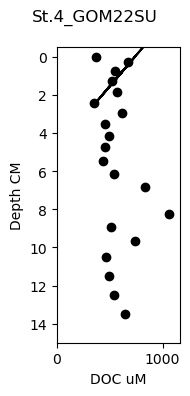

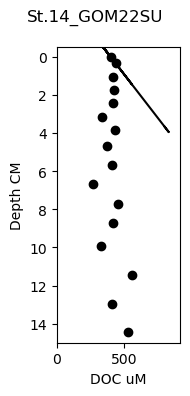

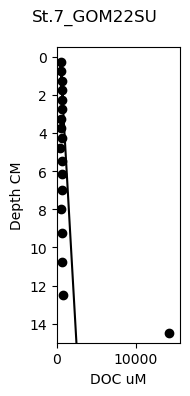

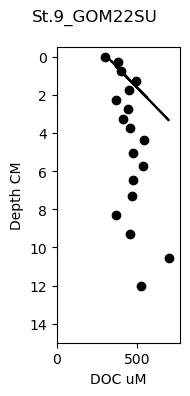

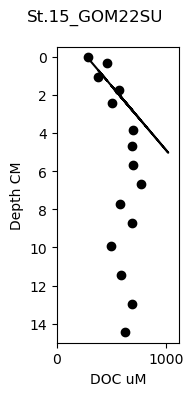

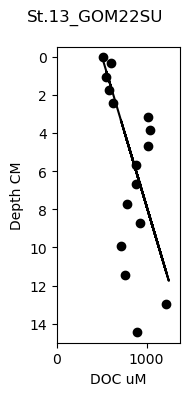

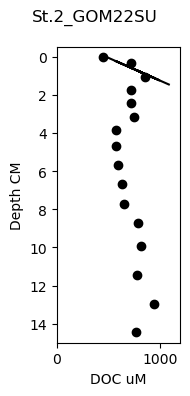

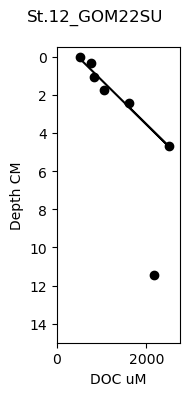

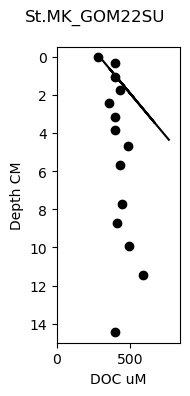

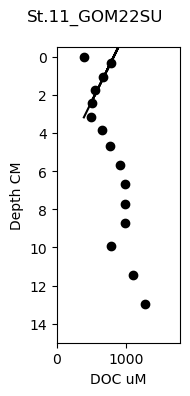

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3758519681.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


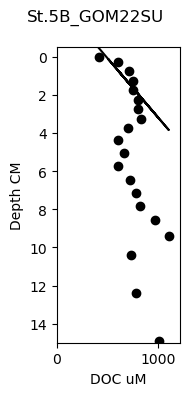

slope_doc_pw  rsquared_doc_pw  std_err_doc_pw  \
code                                                            
St.5B_GOM21FA   39073.849850         0.271363    45274.320329   
St.4_GOM21FA   109306.564043         0.744954    45224.735995   
St.MK_GOM21FA   70456.784301         0.985824     5974.205345   
St.7_GOM21FA    65453.257003         0.764219    20990.180263   
St.13_GOM21FA  -90482.142857         0.779117    34066.545116   
St.14_GOM21FA  161697.941889         0.993775     9049.017284   
St.9_GOM21FA    69495.994660         0.840358    21418.331812   
St.15_GOM21FA  -40717.359414         0.582089    24395.605334   
St.16_GOM21FA   88587.285400         0.951452    14149.782846   
St.11_GOM21FA  -50751.503500         0.846772    21589.143373   
St.2_GOM21FA    60887.534455         0.468412    24516.177062   
St.12_GOM21FA  284295.953444         0.727485   123037.883426   
St.MK_GOM2021  210089.285714         0.988061    23094.010768   
St.11_GOM2021  113468.523002         0.530364    75501.294410   
St.7_GOM2021    83448.388502         0.360997    64099.785437   
St.5B_GOM2021  400433.235787         0.223169   528276.906887   
St.4_GOM2021   305671.337143         0.818578   143902.969357   
St.9_GOM2021    28624.900610         0.240081    29402.769868   
St.14_GOM2021 -117869.389143         0.658392    84902.876034   
St.15_GOM2021  257102.974357         0.995105    18032.565833   
St.2_GOM2021    84865.418118         0.897974    16515.562527   
St.16_GOM2021   92035.714286         0.732347    39343.147953   
St.2_GOM22SP   134329.236920         0.872133    36369.967955   
St.13_GOM22SP   91429.999744         0.883698    14833.534740   
St.MK_GOM22SP   50014.155052         0.517181    27899.934572   
St.4_GOM22SP    65274.753193         0.274119    61326.492117   
St.7_GOM22SP   126141.440741         0.847433    37845.981350   
St.14_GOM22SP  102221.873359         0.612324    40668.488977   
St.16_GOM22SP  -66365.418118         0.459830    41528.666564   
St.15_GOM22SP   79381.701840         0.579934    47772.135908   
St.9_GOM22SP    58874.128920         0.373507    44022.279873   
St.4_GOM22SU   -60721.580817         0.394190    53228.387656   
St.14_GOM22SU  109642.857143         1.000000        0.000000   
St.7_GOM22SU   108591.287880         0.787491    32568.730963   
St.9_GOM22SU    87092.987805         0.756297    28543.490634   
St.15_GOM22SU   83520.252613         0.561620    42602.512338   
St.13_GOM22SU   32322.517422         0.509422    18313.021614   
St.2_GOM22SU   356607.142857         0.852807   148152.203005   
St.12_GOM22SU  395524.825784         0.914971    69613.298076   
St.MK_GOM22SU   70720.338983         0.650029    36692.608010   
St.11_GOM22SU -130839.285714         0.969397    16438.108645   
St.5B_GOM22SU  116147.293028         0.723956    32074.326102   

               flux_doc_depth_pw  por_mean    por_sd  por_count    por_SE  \
code                                                                        
St.5B_GOM21FA                2.0  0.767841  0.030512        4.0  0.015256   
St.4_GOM21FA                 2.0  0.757064  0.017724        4.0  0.008862   
St.MK_GOM21FA                2.0  0.837742  0.013597        4.0  0.006799   
St.7_GOM21FA                 3.0  0.862729  0.013460        6.0  0.005495   
St.13_GOM21FA                3.0  0.904496  0.006345        6.0  0.002590   
St.14_GOM21FA                2.0  0.841244  0.027246        4.0  0.013623   
St.9_GOM21FA                 3.0  0.842932  0.022685        6.0  0.009261   
St.15_GOM21FA                3.0  0.886382  0.012129        5.0  0.005424   
St.16_GOM21FA                2.5  0.848174  0.021883        5.0  0.009786   
St.11_GOM21FA                3.0  0.901163  0.013578        6.0  0.005543   
St.2_GOM21FA                 6.0  0.825126  0.030063       11.0  0.009064   
St.12_GOM21FA                2.5  0.828826  0.015444        5.0  0.006907   
St.MK_GOM2021                3.0  0.556095  0.094259        5.0  0.042154   


In [18]:
Frames = []

def doc_flux_cal(code, depth1, depth2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 4)) 
    sub = df_doc_pw_plot.loc[df_doc_pw_plot['code'] == codes[code]]
    y = sub['Depth']
    x = sub['NPOC_uM']
    axs.scatter(x, y, c="black")
    yy = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel() 
    xx = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'NPOC_uM'].ravel()
    
    # Add subplot labels
    axs.set_xlabel('DOC uM')
    axs.set_ylabel('Depth CM')
    axs.set_ylim(15,-.50)
    axs.set_xlim(df_doc_pw['NPOC_uM'].min(),sub['NPOC_uM'].max()*1.1)
    
    if len(xx) > 1:
        # Add the slope value to the plot
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='black')        
        
        xx2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel() / 1000
        yy2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'NPOC_uM'].ravel() 
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx2, yy2)
        
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
    df_p = df_por.loc[df_por['code'] == codes[code]]
    df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel() 
    por_mean = df_por_data.mean()
    por_std = df_por_data.std()
    por_count = len(df_por_data)

    dic = {'code':[codes[code]],
           'slope_doc_pw':[slope],
           'rsquared_doc_pw':[rsquared], 
           'std_err_doc_pw':[std_err], 
           'flux_doc_depth_pw': [depth1], 
           'por_mean':por_mean,
           'por_sd': por_std, 
           'por_count':por_count}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
        
    # Add subplot labels
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
doc_flux_cal(0, 2, -.50)
doc_flux_cal(1, 2, -.50)
doc_flux_cal(2, 2, -.50)
doc_flux_cal(3, 3, -.50)
doc_flux_cal(4, 3, .1)
doc_flux_cal(5, 2, -.50)
doc_flux_cal(6, 3, -.50)
doc_flux_cal(7, 3, .15)
doc_flux_cal(8, 2.5, -.50)
doc_flux_cal(9, 3, .50)
doc_flux_cal(10, 6, -.5)
doc_flux_cal(11, 2.5, -.50)
doc_flux_cal(12, 3, .50)
doc_flux_cal(13, 2, -.5)
doc_flux_cal(14, 2.5, -.50)
doc_flux_cal(15, 2, -.50) #
doc_flux_cal(16, 2, .25)
doc_flux_cal(17, 2.5, -.50)
doc_flux_cal(18, 2, .25)
doc_flux_cal(19, 2, -.25)
doc_flux_cal(20, 2.5, -.50)
doc_flux_cal(21, 2.5, .25)
doc_flux_cal(22, 2, -.25)
doc_flux_cal(23, 6, .50)
doc_flux_cal(24, 2.5, -.25)
doc_flux_cal(25, 3, -.25)
doc_flux_cal(26, 2, -.50)
doc_flux_cal(27, 4, 0)
doc_flux_cal(28, 3, -.25)
doc_flux_cal(29, 2, -.50)
doc_flux_cal(30, 2.5, -.25)
doc_flux_cal(31, 2, .2)
doc_flux_cal(32, 1, -.50)
doc_flux_cal(33, 2.5, -.25)
doc_flux_cal(34, 2, -.2)
doc_flux_cal(35, 3, -.50)
doc_flux_cal(36, 2.5, -.25)
doc_flux_cal(37, 1.5, -.2)
doc_flux_cal(38, 3, -.50)
doc_flux_cal(39, 2, -.25)
doc_flux_cal(40, 3, .2)
doc_flux_cal(41, 3, -.50)

slopes_doc_pw = pd.concat(Frames, axis=0, ignore_index=False)

A = np.pi*(4.2388**2) 
slopes_doc_pw['por_mean'].fillna(0.85, inplace=True)
slopes_doc_pw['por_sd'].fillna(0, inplace=True)
slopes_doc_pw['por_SE'] = slopes_doc_pw['por_sd'] / (np.sqrt(slopes_doc_pw['por_count']))
slopes_doc_pw['por_SE'].fillna(0, inplace=True)

D_doc = 2.6 * (10**-6) / 10000 * (86400) #0.000001728 

#slopes_doc_pw["pw_flux_doc"] = slopes_doc_pw["slope_doc_pw"] * (slopes_doc_pw["flux_doc_depth_pw"] * A * slopes_doc_pw["por_mean"] ) * D_doc
slopes_doc_pw["pw_flux_doc"] = slopes_doc_pw["slope_doc_pw"] * (slopes_doc_pw["por_mean"] ) * D_doc 

slopes_doc_pw = pd.concat([slopes_doc_pw, df_lat_lon], axis=1, join='outer')
slopes_doc_pw['Stn'] = slopes_doc_pw.index.str.split('_').str[0]
slopes_doc_pw['Camp'] = slopes_doc_pw.index.str.split('_').str[1]
slopes_doc_pw = slopes_doc_pw.dropna(subset=['pw_flux_doc'])

slopes_doc_pw 

In [19]:
#figure calculate pore water 

#TN slopes Pore water 
df_doc_pw_plot = df_doc_pw[(df_doc_pw['TN_uM'] != 0)]
df_doc_pw_plot = df_doc_pw_plot.dropna(subset=["TN_uM"])
codes = df_doc_pw_plot['code'].unique()

print(codes)
len(codes)

['St.5B_GOM21FA' 'St.4_GOM21FA' 'St.MK_GOM21FA' 'St.7_GOM21FA'
 'St.13_GOM21FA' 'St.14_GOM21FA' 'St.9_GOM21FA' 'St.15_GOM21FA'
 'St.16_GOM21FA' 'St.11_GOM21FA' 'St.2_GOM21FA' 'St.12_GOM21FA'
 'St.MK_GOM2021' 'St.11_GOM2021' 'St.7_GOM2021' 'St.5B_GOM2021'
 'St.4_GOM2021' 'St.9_GOM2021' 'St.14_GOM2021' 'St.15_GOM2021'
 'St.2_GOM2021' 'St.16_GOM2021' 'St.2_GOM22SP' 'St.13_GOM22SP'
 'St.MK_GOM22SP' 'St.4_GOM22SP' 'St.7_GOM22SP' 'St.14_GOM22SP'
 'St.16_GOM22SP' 'St.15_GOM22SP' 'St.9_GOM22SP' 'St.4_GOM22SU'
 'St.14_GOM22SU' 'St.7_GOM22SU' 'St.9_GOM22SU' 'St.15_GOM22SU'
 'St.13_GOM22SU' 'St.2_GOM22SU' 'St.12_GOM22SU' 'St.MK_GOM22SU'
 'St.11_GOM22SU' 'St.5B_GOM22SU']


42

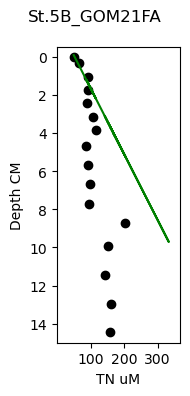

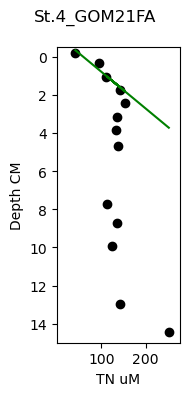

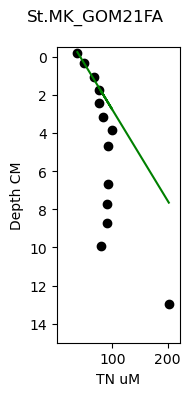

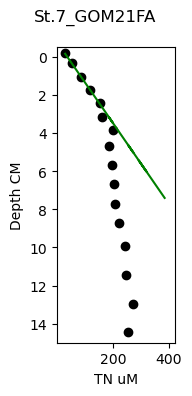

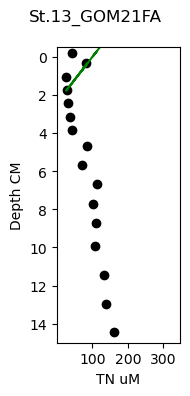

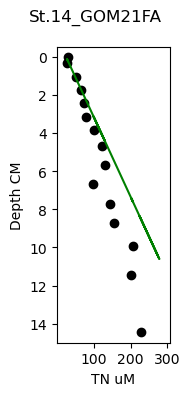

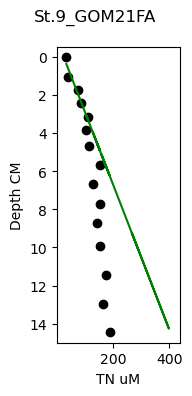

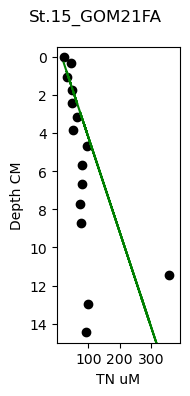

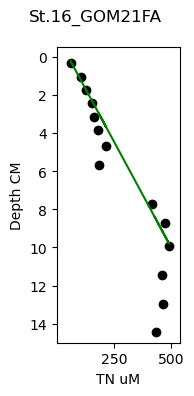

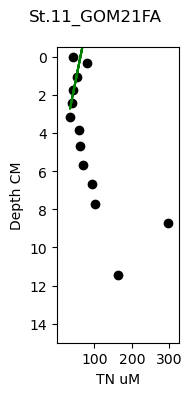

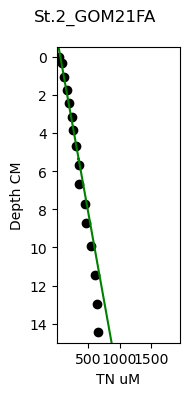

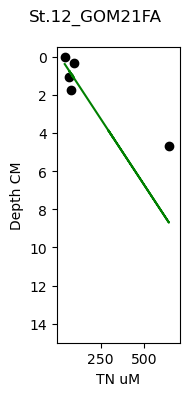

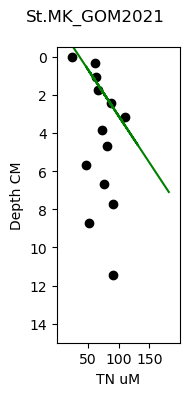

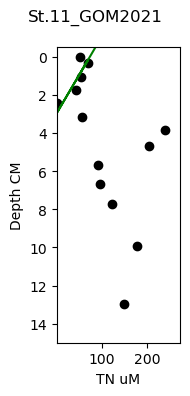

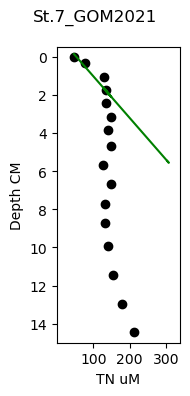

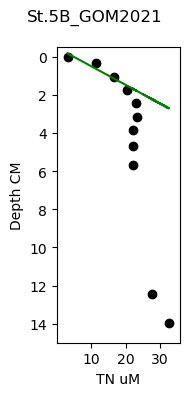

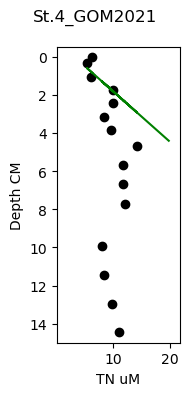

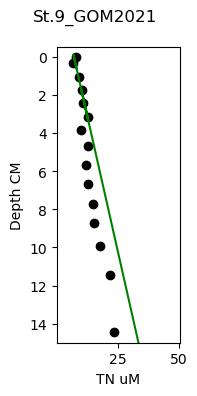

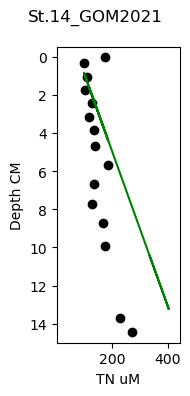

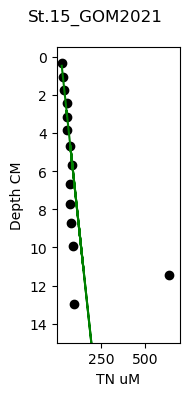

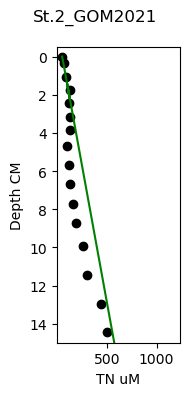

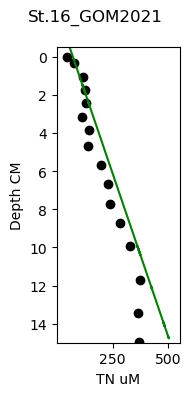

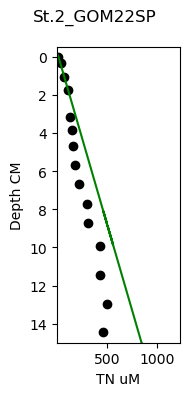

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\2628455655.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


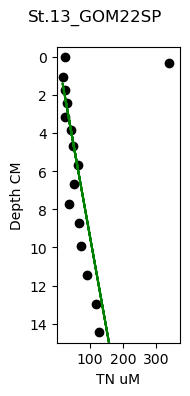

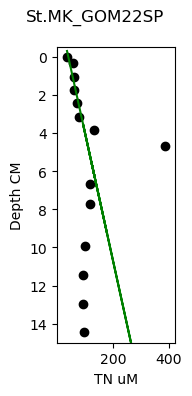

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\2628455655.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


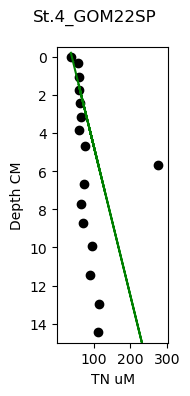

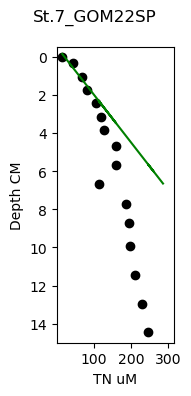

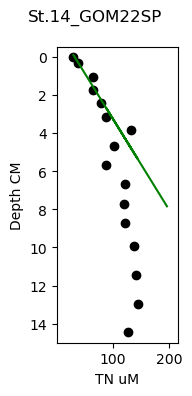

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\2628455655.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


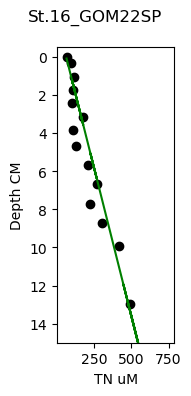

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\2628455655.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


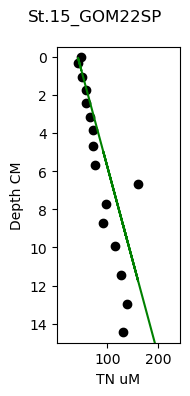

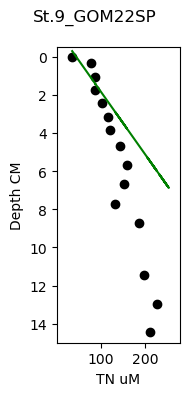

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\2628455655.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


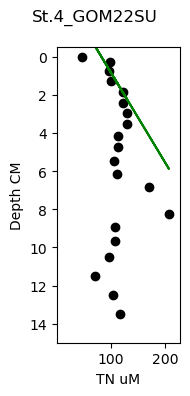

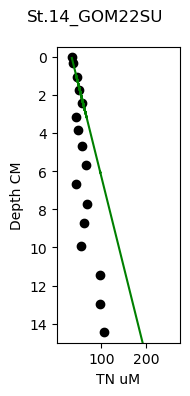

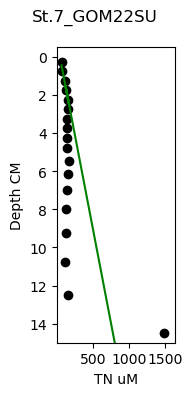

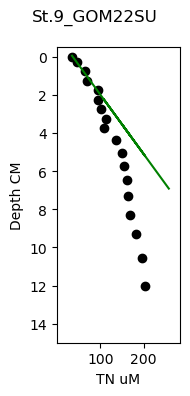

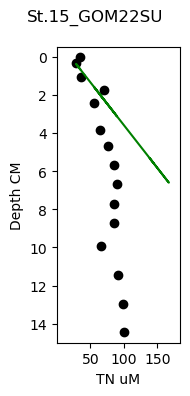

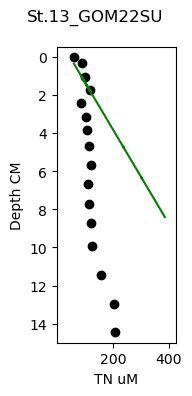

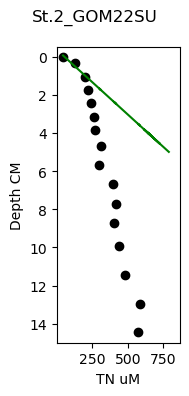

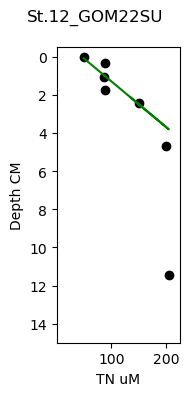

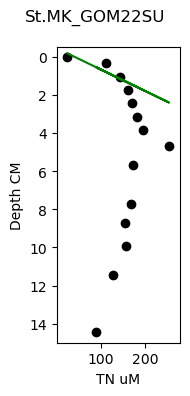

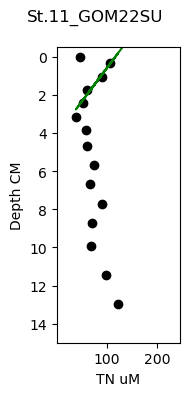

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\2628455655.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


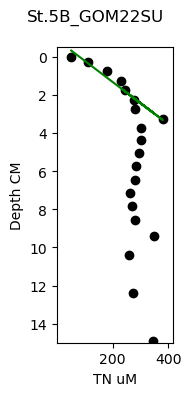

slope_tn_pw  rsquared_tn_pw  std_err_tn_pw  flux_tn_depth_pw  \
code                                                                            
St.5B_GOM21FA   24647.536072        0.852181    7258.682808               2.0   
St.4_GOM21FA    48549.997947        0.934808    9065.916009               2.0   
St.MK_GOM21FA   20602.215677        0.984413    1833.115589               2.0   
St.7_GOM21FA    47032.498584        0.998907     898.230332               3.0   
St.13_GOM21FA  -22450.255104        0.536936   14742.323576               3.0   
St.14_GOM21FA   22430.733307        0.938345    4065.661216               2.0   
St.9_GOM21FA    23255.149726        0.882490    6000.479107               3.0   
St.15_GOM21FA    4395.546676        0.218022    5886.327430               3.0   
St.16_GOM21FA   43561.136819        0.966591    5726.527068               2.5   
St.11_GOM21FA   -9279.076671        0.913633    2852.945871               3.0   
St.2_GOM21FA    53726.822105        0.983619    2620.622065               6.0   
St.12_GOM21FA   11268.479632        0.156514   18497.513111               2.5   
St.MK_GOM2021   16786.989800        0.822242    7805.274879               3.0   
St.11_GOM2021   -8483.483226        0.341046    8338.351752               2.0   
St.7_GOM2021    36195.993017        0.792241   10701.664735               2.5   
St.5B_GOM2021    9216.422411        0.903465    2130.267771               2.0   
St.4_GOM2021     3254.420398        0.859759    1314.387365               2.0   
St.9_GOM2021     1470.113744        0.834095     378.541015               2.5   
St.14_GOM2021    2851.250771        0.115139    7904.283753               2.0   
St.15_GOM2021   10980.444986        0.948856    2549.283309               2.0   
St.2_GOM2021    32118.497999        0.921594    5408.776561               2.5   
St.16_GOM2021   23078.571417        0.790346    8404.995587               2.5   
St.2_GOM22SP    54850.236409        0.990438    3810.897707               2.0   
St.13_GOM22SP    9406.972304        0.912657    1301.442648               6.0   
St.MK_GOM22SP   10867.346938        0.726078    3853.758900               2.5   
St.4_GOM22SP     7208.717023        0.566530    3640.534383               3.0   
St.7_GOM22SP    37208.308539        0.931916    7111.479338               2.0   
St.14_GOM22SP   19391.965320        0.923162    3230.062841               2.5   
St.16_GOM22SP   12478.036337        0.386899    9068.863432               3.0   
St.15_GOM22SP    6609.131785        0.648581    3440.010386               2.0   
St.9_GOM22SP    21857.049540        0.717712    7914.115399               2.5   
St.4_GOM22SU    14740.421189        0.693774    6924.791446               2.0   
St.14_GOM22SU   10273.002421        0.963721    1409.393805               2.0   
St.7_GOM22SU    46644.918814        0.920358    7922.011733               2.5   
St.9_GOM22SU    30963.501745        0.966239    3341.609170               2.0   
St.15_GOM22SU   13721.938776        0.615874    6256.708477               3.0   
St.13_GOM22SU   10754.044293        0.265887   10316.776908               2.5   
St.2_GOM22SU   140553.935910        0.951156   31851.050902               1.5   
St.12_GOM22SU   31569.344211        0.753771   10417.292108               3.0   
St.MK_GOM22SU   69319.093701        0.774825   26423.829832               2.0   
St.11_GOM22SU  -27490.561211        0.966250    3632.954758               3.0   
St.5B_GOM22SU   79922.309461        0.885308   12864.749726               3.0   

               por_mean    por_sd  por_count    por_SE  pw_flux_tn        Lat  \
code                                                                            
St.5B_GOM21FA  0.767841  0.030512        4.0  0.015256    0.817577  28.806169   
St.4_GOM21FA   0.757064  0.017724        4.0  0.008862    1.587835  28.795872   
St.MK_GOM21FA  0.837742  0.013597        4.0  0.006799    0.745604  28.913659   
St.7_GOM21FA   0.862729  0.013460        6.0  0

In [20]:
Frames = []

def doc_flux_cal(code, depth1, depth2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 4)) 
    sub = df_doc_pw_plot.loc[df_doc_pw_plot['code'] == codes[code]]
    y = sub['Depth']
    x = sub['TN_uM']
    axs.scatter(x, y, c="black")
    yy = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel() 
    xx = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'TN_uM'].ravel()
    
    # Add subplot labels
    axs.set_xlabel('TN uM')
    axs.set_ylabel('Depth CM')
    axs.set_ylim(15,-.50)
    axs.set_xlim(df_doc_pw['TN_uM'].min(),sub['TN_uM'].max()*1.1)
    
    if len(xx) > 1:
        # Add the slope value to the plot
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='green')        
        
        xx2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel()/ 1000
        yy2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'TN_uM'].ravel() 
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx2, yy2)
        
        slope = slope
        rsquared = r_value**2
        std_err = std_err
    
    df_p = df_por.loc[df_por['code'] == codes[code]]
    df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel() 
    por_mean = df_por_data.mean()
    por_std = df_por_data.std()
    por_count = len(df_por_data)

        
    dic = {'code':[codes[code]],
           'slope_tn_pw':[slope],
           'rsquared_tn_pw':[rsquared], 
           'std_err_tn_pw':[std_err], 
           'flux_tn_depth_pw': [depth1], 
           'por_mean':por_mean,
           'por_sd': por_std, 
           'por_count':por_count}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
        
    # Add subplot labels
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
doc_flux_cal(0, 2, -.50)
doc_flux_cal(1, 2, -.50)
doc_flux_cal(2, 2, -.50)
doc_flux_cal(3, 3, -.50)
doc_flux_cal(4, 3, .1)
doc_flux_cal(5, 2, -.50)
doc_flux_cal(6, 3, -.50)
doc_flux_cal(7, 3, .15)
doc_flux_cal(8, 2.5, -.50)
doc_flux_cal(9, 3, .50)
doc_flux_cal(10, 6, -.5)
doc_flux_cal(11, 2.5, -.50)
doc_flux_cal(12, 3, .50)
doc_flux_cal(13, 2, -.5)
doc_flux_cal(14, 2.5, -.50)
doc_flux_cal(15, 2, -.50)
doc_flux_cal(16, 2, .25)
doc_flux_cal(17, 2.5, -.50)
doc_flux_cal(18, 2, .25)
doc_flux_cal(19, 2, -.25)
doc_flux_cal(20, 2.5, -.50)
doc_flux_cal(21, 2.5, .25)
doc_flux_cal(22, 2, -.25)
doc_flux_cal(23, 6, .50)
doc_flux_cal(24, 2.5, -.25)
doc_flux_cal(25, 3, -.25)
doc_flux_cal(26, 2, -.50)
doc_flux_cal(27, 2.5, -.25)
doc_flux_cal(28, 3, -.25)
doc_flux_cal(29, 2, -.50)
doc_flux_cal(30, 2.5, -.25)
doc_flux_cal(31, 2, .2)
doc_flux_cal(32, 2, -.50)
doc_flux_cal(33, 2.5, -.25)
doc_flux_cal(34, 2, -.2)
doc_flux_cal(35, 3, -.50)
doc_flux_cal(36, 2.5, -.25)
doc_flux_cal(37, 1.5, -.2)
doc_flux_cal(38, 3, -.50)
doc_flux_cal(39, 2, -.25)
doc_flux_cal(40, 3, .2)
doc_flux_cal(41, 3, -.50)

slopes_tn_pw = pd.concat(Frames, axis=0, ignore_index=False)

A = np.pi*(4.2388**2) 
slopes_tn_pw['por_mean'].fillna(0.85, inplace=True)
slopes_tn_pw['por_sd'].fillna(0, inplace=True)
slopes_tn_pw['por_SE'] = slopes_doc_pw['por_sd'] / (np.sqrt(slopes_doc_pw['por_count']))
slopes_tn_pw['por_SE'].fillna(0, inplace=True)

D_tn = 5 * (10**-6) / 10000 * (86400)

slopes_tn_pw["pw_flux_tn"] = slopes_tn_pw["slope_tn_pw"] * slopes_tn_pw["por_mean"] * D_tn 
slopes_tn_pw = pd.concat([slopes_tn_pw, df_lat_lon], axis=1, join='outer')
slopes_tn_pw['Stn'] = slopes_tn_pw.index.str.split('_').str[0]
slopes_tn_pw['Camp'] = slopes_tn_pw.index.str.split('_').str[1]
slopes_tn_pw = slopes_tn_pw.dropna(subset=['pw_flux_tn'])

slopes_tn_pw 

In [21]:
#figure calculate pore water 

#Fe2 and Fe3 slopes
codes = df_iron_pw['code'].unique()

print(codes)
len(codes)

['St.MK_GOM2021' 'St.5B_GOM2021' 'St.4_GOM2021' 'St.14_GOM2021'
 'St.9_GOM2021' 'St.2_GOM2021' 'St.15_GOM2021' 'St.16_GOM2021'
 'St.11_GOM2021' 'St.7_GOM2021' 'St.5B_GOM21FA' 'St.4_GOM21FA'
 'St.MK_GOM21FA' 'St.7_GOM21FA' 'St.14_GOM21FA' 'St.9_GOM21FA'
 'St.15_GOM21FA' 'St.2_GOM21FA' 'St.13_GOM21FA' 'St.16_GOM21FA'
 'St.12_GOM21FA' 'St.11_GOM21FA' 'St.7_GOM22SP' 'St.14_GOM22SP'
 'St.16_GOM22SP' 'St.5B_GOM22SP' 'St.15_GOM22SP' 'St.9_GOM22SP'
 'St.2_GOM22SP' 'St.13_GOM22SP' 'St.MK_GOM22SP' 'St.4_GOM22SP'
 'St.4_GOM22SU' 'St.5B_GOM22SU' 'St.14_GOM22SU' 'St.7_GOM22SU'
 'St.9_GOM22SU' 'St.15_GOM22SU' 'St.13_GOM22SU' 'St.2_GOM22SU'
 'St.12_GOM22SU' 'St.16_GOM22SU' 'St.11_GOM22SU' 'St.MK_GOM22SU']


44

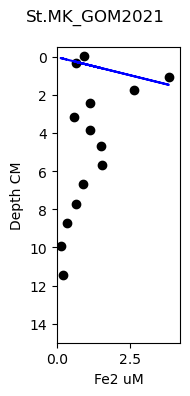

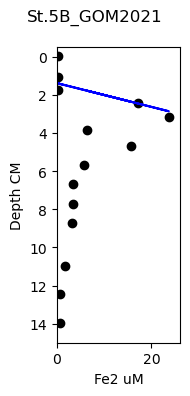

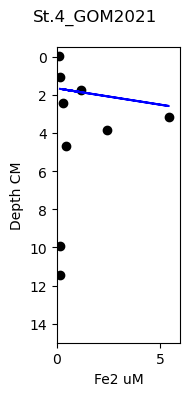

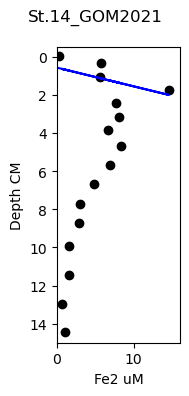

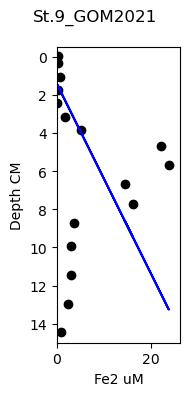

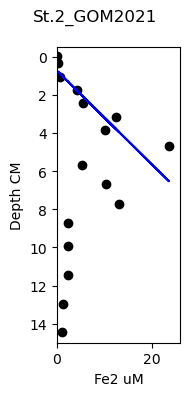

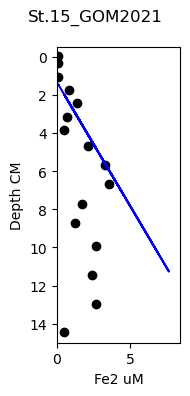

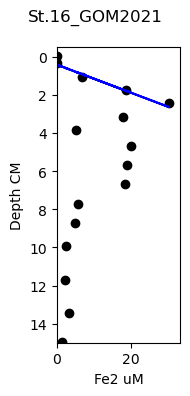

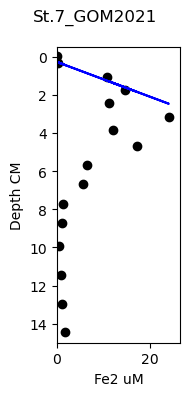

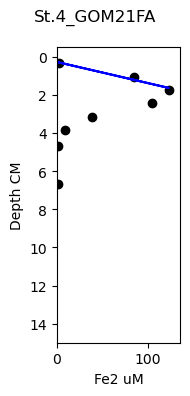

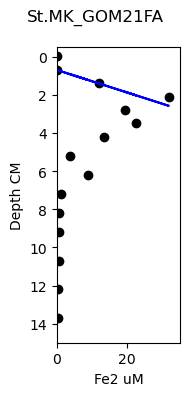

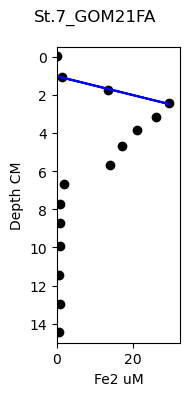

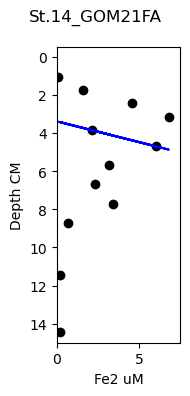

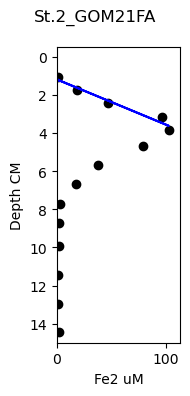

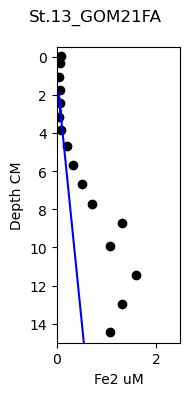

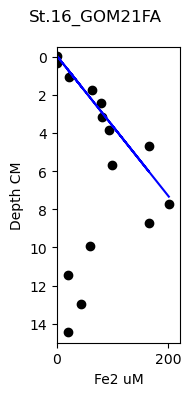

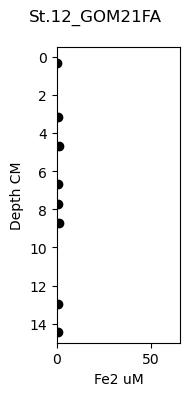

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\119307254.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


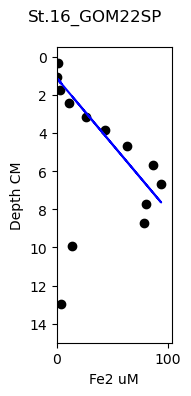

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\119307254.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


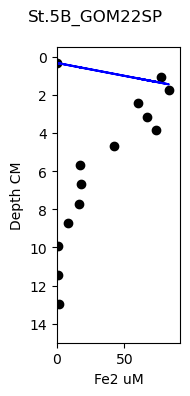

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\119307254.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


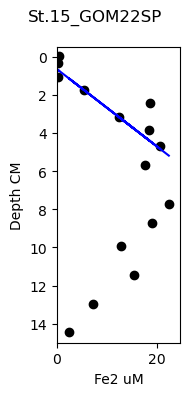

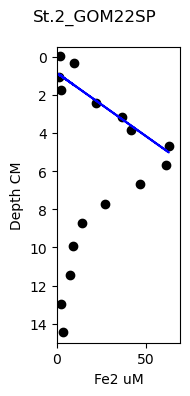

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\119307254.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


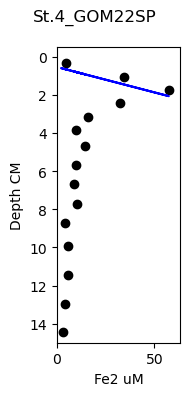

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\119307254.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


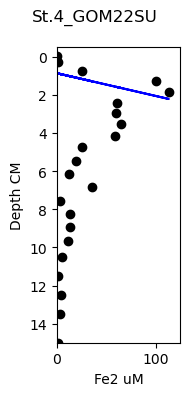

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\119307254.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


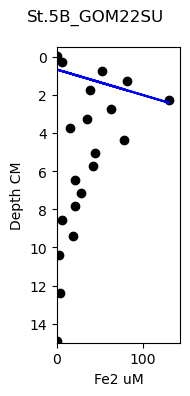

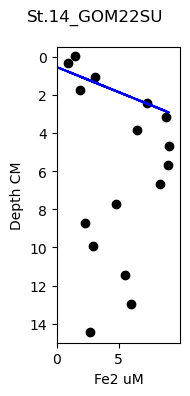

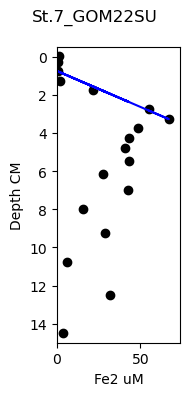

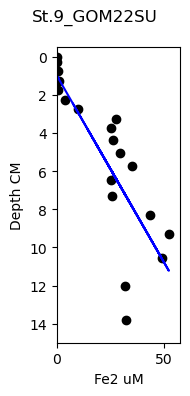

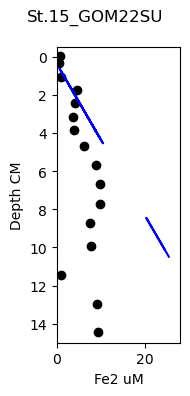

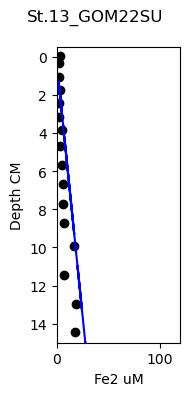

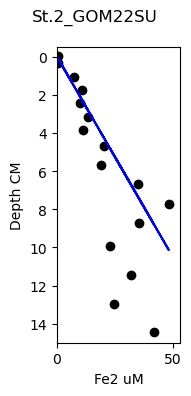

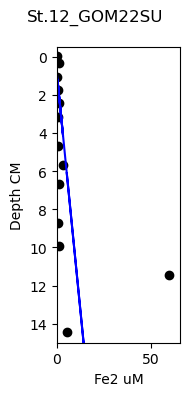

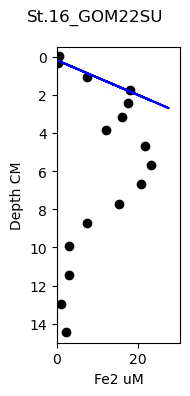

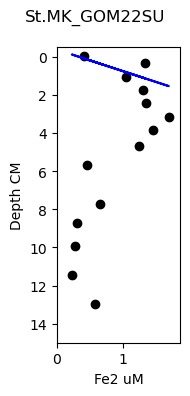

slope_fe2_pw  rsquared_fe2_pw  std_err_fe2_pw  \
code                                                           
St.MK_GOM2021   1398.621290         0.531382      928.733249   
St.5B_GOM2021  12142.857143         0.756441     6890.263070   
St.4_GOM2021     101.428571         0.017294      764.576714   
St.14_GOM2021   2131.857143         0.209260     2930.334602   
St.9_GOM2021    1130.734694         0.561914      499.201015   
St.2_GOM2021    3528.489796         0.864881      697.332358   
St.15_GOM2021    184.000000         0.238679      164.310451   
St.16_GOM2021  13277.857143         0.975383     2109.390448   
St.7_GOM2021   10276.428571         0.932150     2772.518471   
St.4_GOM21FA   86715.714286         0.956716    18444.691528   
St.MK_GOM21FA  17097.142857         1.000000        0.000000   
St.7_GOM21FA   20202.142857         0.993446     1640.911944   
St.14_GOM21FA    196.959498         0.042924      351.520349   
St.2_GOM21FA   40339.714286         0.953634     5135.467222   
St.13_GOM21FA     12.714286         0.326612       10.540173   
St.16_GOM21FA  23038.714286         0.846215     5670.411824   
St.16_GOM22SP  12102.410796         0.838610     2654.607093   
St.5B_GOM22SP  59163.179074         0.799003    29673.698143   
St.15_GOM22SP   3713.300346         0.755334     2113.377000   
St.2_GOM22SP   11617.249943         0.768294     3189.904322   
St.4_GOM22SP   15087.610094         0.401182    13034.131172   
St.4_GOM22SU   20608.596713         0.246495    18015.983137   
St.5B_GOM22SU  27078.285714         0.363372    17920.837784   
St.14_GOM22SU   2582.857143         0.677195     1260.952507   
St.7_GOM22SU   23023.783784         0.866293     5222.293057   
St.9_GOM22SU    3406.028571         0.663295     1213.360495   
St.15_GOM22SU   2015.714286         0.803875      704.021973   
St.13_GOM22SU    289.570003         0.153121      304.552776   
St.2_GOM22SU    4221.136371         0.887186      752.615250   
St.12_GOM22SU     98.405619         0.097924      149.336620   
St.16_GOM22SU  10356.436021         0.937694     1887.686748   
St.MK_GOM22SU    344.770011         0.390817      304.369847   

               flux_fe2_depth_pw  por_mean    por_sd  por_count    por_SE  \
code                                                                        
St.MK_GOM2021                2.0  0.524421  0.078036        4.0  0.039018   
St.5B_GOM2021                3.0  0.766182  0.061370        5.0  0.027446   
St.4_GOM2021                 3.0  0.657074  0.075922        5.0  0.033953   
St.14_GOM2021                3.0  0.844243  0.021163        5.0  0.009464   
St.9_GOM2021                 4.0  0.859297  0.009932        6.0  0.004055   
St.2_GOM2021                 4.0  0.893612  0.018307        6.0  0.007474   
St.15_GOM2021                4.0  0.894873  0.033341        6.0  0.013612   
St.16_GOM2021                2.0  0.884978  0.004250        4.0  0.002125   
St.7_GOM2021                 2.0  0.905406  0.012433        4.0  0.006217   
St.4_GOM21FA                 2.0  0.757064  0.017724        4.0  0.008862   
St.MK_GOM21FA                2.0  0.837742  0.013597        4.0  0.006799   
St.7_GOM21FA                 3.0  0.862729  0.013460        6.0  0.005495   
St.14_GOM21FA                8.0  0.808096  0.031226       11.0  0.009415   
St.2_GOM21FA                 4.0  0.839925  0.020750        8.0  0.007336   
St.13_GOM21FA                4.0  0.898447  0.011876        8.0  0.004199   
St.16_GOM21FA                4.0  0.835379  0.024117        8.0  0.008527   
St.16_GOM22SP                4.0  0.850000  0.000000        0.0  0.000000   
St.5B_GOM22SP                2.0  0.850000  0.000000        0.0  0.000000   
St.15_GOM22SP                2.0  0.850000  0.000000        0.0  0.000000   
St.2_GOM22SP                 4.0  0.862540  0.025784        8.0  0.009116   
St.4_GOM22SP                 3.0  0.850000  0.000000        0.0  0.000000   
St.4_GOM22SU                 3.0  0.850000  0.000000        0.0  0.

In [22]:
Frames = []

def fe2_flux_cal(code, depth1, depth2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 4)) 
    sub = df_iron_pw.loc[df_iron_pw['code'] == codes[code]]
    y = sub['Fe2_Depth']
    x = sub['Fe2_uM']
    axs.scatter(x, y, c="black")
    yy = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_Depth'].ravel() 
    xx = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_uM'].ravel()
    
    # Add subplot labels
    axs.set_xlabel('Fe2 uM')
    axs.set_ylabel('Depth CM')
    axs.set_ylim(15,-.50)
    axs.set_xlim(df_iron_pw['Fe2_uM'].min(),sub['Fe2_uM'].max()*1.1)
    
    if len(xx) > 1:
        # Add the slope value to the plot
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='b')        
        
        xx2 = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_Depth'].ravel()/ 1000
        yy2 = sub.loc[(sub['Fe2_Depth'] < depth1) & (sub['Fe2_Depth'] > depth2), 'Fe2_uM'].ravel() 
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx2, yy2)
        
        slope = slope
        rsquared = r_value**2
        std_err = std_err

    df_p = df_por.loc[df_por['code'] == codes[code]]
    df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel() 
    por_mean = df_por_data.mean()
    por_std = df_por_data.std()
    por_count = len(df_por_data)

        
    dic = {'code':[codes[code]],
           'slope_fe2_pw':[slope],
           'rsquared_fe2_pw':[rsquared], 
           'std_err_fe2_pw':[std_err], 
           'flux_fe2_depth_pw': [depth1], 
           'por_mean':por_mean,
           'por_sd': por_std, 
           'por_count':por_count}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
        
        
    # Add subplot labels
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
fe2_flux_cal(0, 2, -.50)
fe2_flux_cal(1, 3,.50)
fe2_flux_cal(2, 3,.50)
fe2_flux_cal(3, 3,.15)
fe2_flux_cal(4, 4,.15)
fe2_flux_cal(5, 4,.15)
fe2_flux_cal(6, 4,.15)
fe2_flux_cal(7, 2,0)
fe2_flux_cal(9, 2,.15)
fe2_flux_cal(11, 2,.15)
fe2_flux_cal(12, 2,.15)
fe2_flux_cal(13, 3,1)
fe2_flux_cal(14, 8,.5)
fe2_flux_cal(17, 4,.50)
fe2_flux_cal(18, 4,.50)
fe2_flux_cal(19, 4,.50)
fe2_flux_cal(20, 4,0)
fe2_flux_cal(24, 4,0)
fe2_flux_cal(25, 2,0)
fe2_flux_cal(26, 2,0)
fe2_flux_cal(28, 4, 0)
fe2_flux_cal(31, 3, 0)
fe2_flux_cal(32, 3, 0)
fe2_flux_cal(33, 3, 0)
fe2_flux_cal(34, 3, 0)
fe2_flux_cal(35, 3, 0)
fe2_flux_cal(36, 3, 0)
fe2_flux_cal(37, 3, 0)
fe2_flux_cal(38, 4, -.10)
fe2_flux_cal(39, 3.5, -.10)
fe2_flux_cal(40, 3.5, -.10)
fe2_flux_cal(41, 2, -.10)
fe2_flux_cal(43, 2, -.10)

slopes_fe2_pw = pd.concat(Frames, axis=0, ignore_index=False)

A = np.pi*(4.2388**2) 
slopes_fe2_pw['por_mean'].fillna(0.85, inplace=True)
slopes_fe2_pw['por_sd'].fillna(0, inplace=True)
slopes_fe2_pw['por_SE'] = slopes_fe2_pw['por_sd'] / (np.sqrt(slopes_fe2_pw['por_count']))
slopes_fe2_pw['por_SE'].fillna(0, inplace=True)

D_fe = 7.07e-06 / 10000 * (86400)

slopes_fe2_pw["pw_flux_fe2"] = slopes_fe2_pw["slope_fe2_pw"] * slopes_fe2_pw["por_mean"] * D_fe 
slopes_fe2_pw = pd.concat([slopes_fe2_pw, df_lat_lon], axis=1, join='outer')
slopes_fe2_pw['Stn'] = slopes_fe2_pw.index.str.split('_').str[0]
slopes_fe2_pw['Camp'] = slopes_fe2_pw.index.str.split('_').str[1]
slopes_fe2_pw = slopes_fe2_pw.dropna(subset=['pw_flux_fe2'])

slopes_fe2_pw 

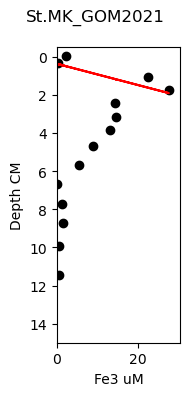

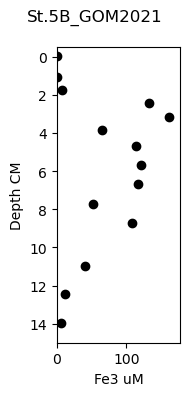

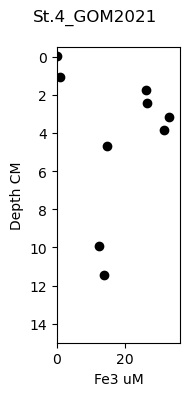

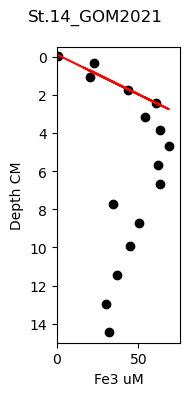

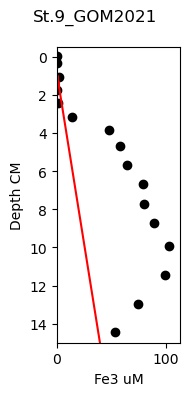

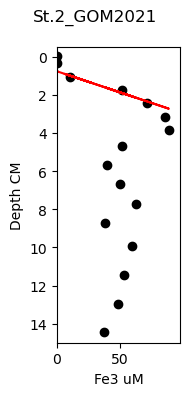

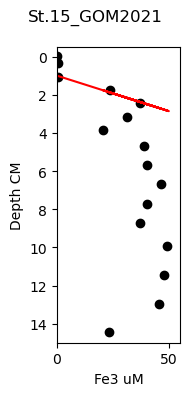

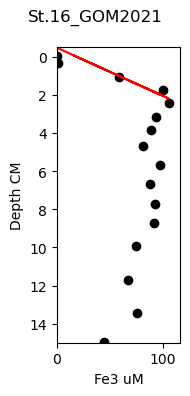

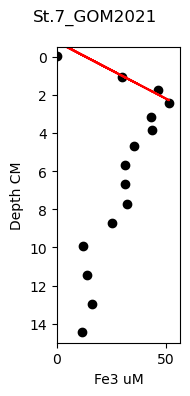

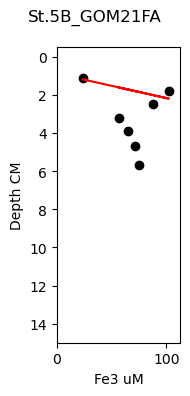

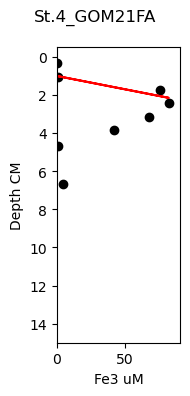

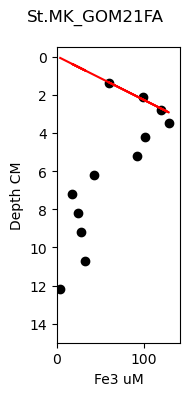

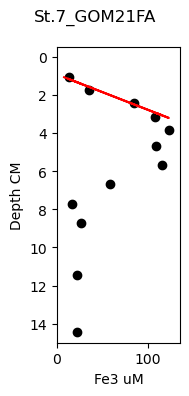

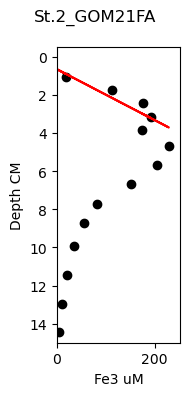

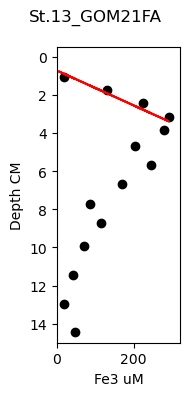

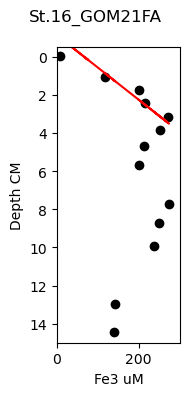

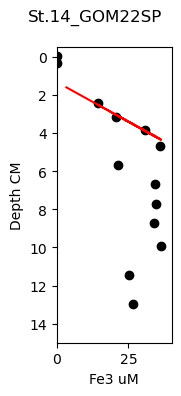

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3314293207.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


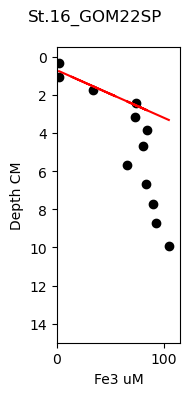

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3314293207.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


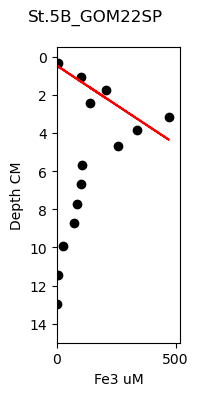

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3314293207.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


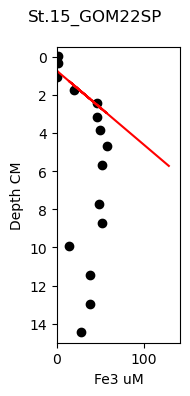

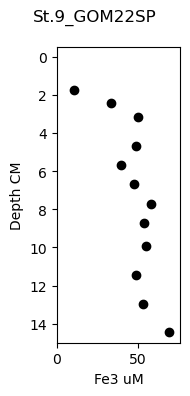

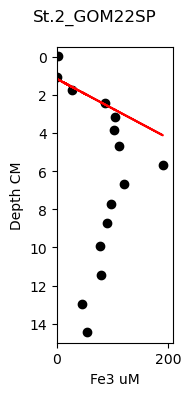

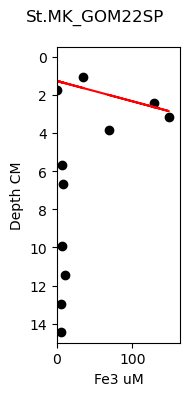

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3314293207.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


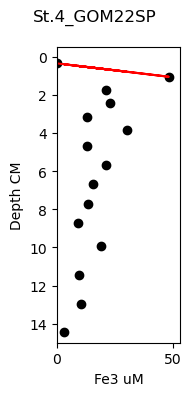

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3314293207.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


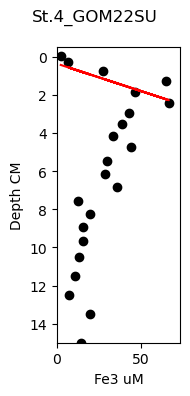

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3314293207.py:33: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


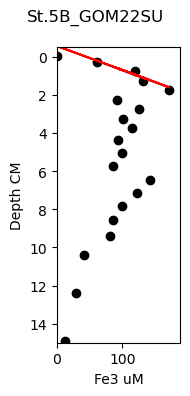

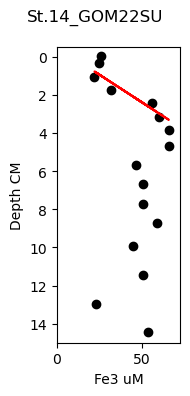

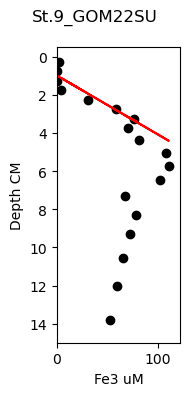

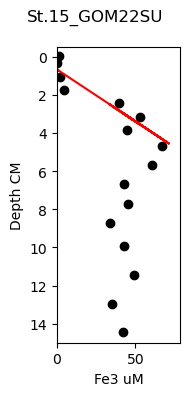

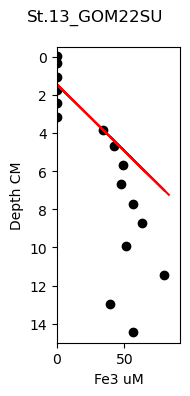

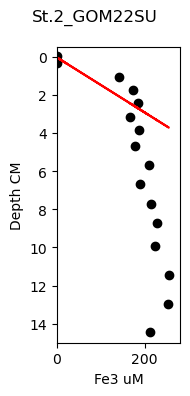

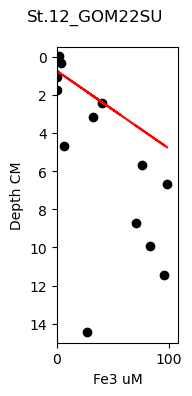

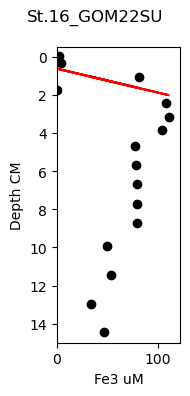

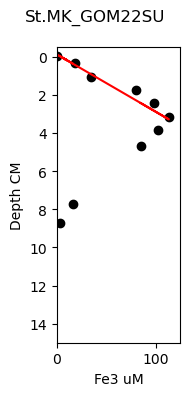

slope_fe3_pw  rsquared_fe3_pw  std_err_fe3_pw  \
code                                                           
St.MK_GOM2021   7936.387801         0.443151     5136.351954   
St.14_GOM2021  21992.173502         0.916028     3844.326329   
St.9_GOM2021     132.603517         0.047265      343.725877   
St.2_GOM2021   43232.142857         0.958756     8966.662074   
St.15_GOM2021  26274.285714         0.978438     3900.413461   
St.16_GOM2021  33496.428571         0.843633    14420.972545   
St.7_GOM2021   15338.571429         0.914702     4683.960255   
St.5B_GOM21FA  45927.857143         0.590052    38282.034385   
St.4_GOM21FA   58336.428571         0.808806    28363.156760   
St.MK_GOM21FA  42256.428571         0.969230     7529.059903   
St.7_GOM21FA   51697.857143         0.955690    11131.725583   
St.2_GOM21FA   56060.857143         0.747101    18831.427382   
St.13_GOM21FA  97408.714286         0.889560    19815.866124   
St.16_GOM21FA  48611.000000         0.820761    13115.410918   
St.14_GOM22SP  11815.156689         0.978125     1766.933039   
St.16_GOM22SP  35222.185509         0.876854     9333.570931   
St.5B_GOM22SP  73359.679148         0.602902    42098.618907   
St.15_GOM22SP  22293.035976         0.863321     6272.182419   
St.2_GOM22SP   61013.073376         0.948584    14204.782414   
St.MK_GOM22SP  67185.827477         0.714293    30045.867943   
St.4_GOM22SP   68764.028886         1.000000        0.000000   
St.4_GOM22SU   14482.167509         0.413463     8624.479502   
St.5B_GOM22SU  69999.400000         0.881506    25664.374166   
St.14_GOM22SU  14887.671429         0.862723     3428.702139   
St.9_GOM22SU   26509.661188         0.820679     5541.773993   
St.15_GOM22SU  14926.714365         0.811975     3212.296482   
St.13_GOM22SU   5672.085861         0.395627     3135.214973   
St.2_GOM22SU   49363.211754         0.710663    14086.036013   
St.12_GOM22SU  12220.340526         0.498614     7074.994797   
St.16_GOM22SU  33164.475083         0.414614    22751.587798   
St.MK_GOM22SU  29925.336789         0.898499     4498.102600   

               flux_fe3_depth_pw  por_mean    por_sd  por_count    por_SE  \
code                                                                        
St.MK_GOM2021                3.0  0.556095  0.094259        5.0  0.042154   
St.14_GOM2021                3.0  0.844243  0.021163        5.0  0.009464   
St.9_GOM2021                 3.0  0.858953  0.010848        5.0  0.004851   
St.2_GOM2021                 3.0  0.896193  0.019031        5.0  0.008511   
St.15_GOM2021                3.0  0.904022  0.028840        5.0  0.012898   
St.16_GOM2021                3.0  0.878884  0.012766        5.0  0.005709   
St.7_GOM2021                 3.0  0.900131  0.015329        5.0  0.006855   
St.5B_GOM21FA                3.0  0.758168  0.033453        5.0  0.014961   
St.4_GOM21FA                 3.0  0.707526  0.095821        6.0  0.039119   
St.MK_GOM21FA                3.5  0.838519  0.011727        6.0  0.004788   
St.7_GOM21FA                 3.0  0.862729  0.013460        6.0  0.005495   
St.2_GOM21FA                 4.0  0.839925  0.020750        8.0  0.007336   
St.13_GOM21FA                4.0  0.898447  0.011876        8.0  0.004199   
St.16_GOM21FA                4.0  0.835379  0.024117        8.0  0.008527   
St.14_GOM22SP                4.5  0.830237  0.040204        9.0  0.013401   
St.16_GOM22SP                2.5  0.850000  0.000000        0.0  0.000000   
St.5B_GOM22SP                2.5  0.850000  0.000000        0.0  0.000000   
St.15_GOM22SP                2.5  0.850000  0.000000        0.0  0.000000   
St.2_GOM22SP                 3.0  0.873812  0.019043        6.0  0.007774   
St.MK_GOM22SP                3.5  0.739851  0.080344        7.0  0.030367   
St.4_GOM22SP                 1.5  0.850000  0.000000        0.0  0.000000   
St.4_GOM22SU                 3.5  0.850000  0.000000        0.0  0.000000   
St.5B_GOM22SU                1.5  0.850000  0.000000  

In [23]:
Frames = []

def fe3_flux_cal(code, depth1, depth2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 4)) 
    sub = df_iron_pw.loc[df_iron_pw['code'] == codes[code]]
    y = sub['FeT_Depth']
    x = sub['Fe3_uM']
    axs.scatter(x, y, c="black")
    yy = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'FeT_Depth'].ravel() 
    xx = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'Fe3_uM'].ravel()
    
    # Add subplot labels
    axs.set_xlabel('Fe3 uM')
    axs.set_ylabel('Depth CM')
    axs.set_ylim(15,-.50)
    axs.set_xlim(df_iron_pw['Fe3_uM'].min(),sub['Fe3_uM'].max()*1.1)
    
    if len(xx) > 1:
        # Add the slope value to the plot
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='r')        
        
        xx2 = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'FeT_Depth'].ravel()/ 1000 
        yy2 = sub.loc[(sub['FeT_Depth'] < depth1) & (sub['FeT_Depth'] > depth2), 'Fe3_uM'].ravel() 
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx2, yy2)
        
        slope = slope
        rsquared = r_value**2
        std_err = std_err
    
    df_p = df_por.loc[df_por['code'] == codes[code]]
    df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel() 
    por_mean = df_por_data.mean()
    por_std = df_por_data.std()
    por_count = len(df_por_data)

        
    dic = {'code':[codes[code]],
           'slope_fe3_pw':[slope],
           'rsquared_fe3_pw':[rsquared], 
           'std_err_fe3_pw':[std_err], 
           'flux_fe3_depth_pw': [depth1], 
           'por_mean':por_mean,
           'por_sd': por_std, 
           'por_count':por_count}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
        
    # Add subplot labels
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
fe3_flux_cal(0, 3, -.5)
fe3_flux_cal(1, 3, -.5)
fe3_flux_cal(2, 3, -.5)
fe3_flux_cal(3, 3, -.5)
fe3_flux_cal(4, 3, -.5)
fe3_flux_cal(5, 3, 1)
fe3_flux_cal(6, 3, 1)
fe3_flux_cal(7, 3, 1)
fe3_flux_cal(9, 3, 1)
fe3_flux_cal(10, 3, 1)
fe3_flux_cal(11, 3, 1)
fe3_flux_cal(12, 3.5, 1)
fe3_flux_cal(13, 3, 1)
fe3_flux_cal(17, 4, 1)
fe3_flux_cal(18, 4, 1)
fe3_flux_cal(19, 4, 1)
fe3_flux_cal(23, 4.5, 2)
fe3_flux_cal(24, 2.5, 0)
fe3_flux_cal(25, 2.5, 0)
fe3_flux_cal(26, 2.5, 0)
fe3_flux_cal(27, 3.5, -.5)
fe3_flux_cal(28, 3, 1)
fe3_flux_cal(30, 3.5, 1)
fe3_flux_cal(31, 1.5, 0)
fe3_flux_cal(32, 3.5, 0)
fe3_flux_cal(33, 1.5, 0)
fe3_flux_cal(34, 3.5, 0)
fe3_flux_cal(36, 3.5, 0)
fe3_flux_cal(37, 4, -1)
fe3_flux_cal(38, 4, -1)
fe3_flux_cal(39, 4, -1)
fe3_flux_cal(40, 2.5, -1)
fe3_flux_cal(41, 2.5, -1)
fe3_flux_cal(43, 4, -1)

slopes_fe3_pw = pd.concat(Frames, axis=0, ignore_index=False)

A = np.pi*(4.2388**2) 
slopes_fe3_pw['por_mean'].fillna(0.85, inplace=True)
slopes_fe3_pw['por_sd'].fillna(0, inplace=True)
slopes_fe3_pw['por_SE'] = slopes_fe3_pw['por_sd'] / (np.sqrt(slopes_fe3_pw['por_count']))
slopes_fe3_pw['por_SE'].fillna(0, inplace=True)

D_fe = 7.07e-06 / 10000 * (86400)

slopes_fe3_pw["pw_flux_fe3"] = slopes_fe3_pw["slope_fe3_pw"] * slopes_fe3_pw["por_mean"] * D_fe 
slopes_fe3_pw = pd.concat([slopes_fe3_pw, df_lat_lon], axis=1, join='outer')
slopes_fe3_pw['Stn'] = slopes_fe3_pw.index.str.split('_').str[0]
slopes_fe3_pw['Camp'] = slopes_fe3_pw.index.str.split('_').str[1]
slopes_fe3_pw = slopes_fe3_pw.dropna(subset=['pw_flux_fe3'])

slopes_fe3_pw 

In [24]:
#figure calculate pore water 

#CDOM slops
df_cdom_pw_cl = df_cdom_pw.drop(df_cdom_pw[(df_cdom_pw['a350'] <= 0) | (df_cdom_pw['a350'].isna())].index)
df_cdom_pw_cl['Sample_depth'] = df_cdom_pw_cl['Sample_depth'].astype(float)

codes = df_cdom_pw_cl['code'].unique()
print(codes)
len(codes)


['St.14_GOM2021' 'St.2_GOM2021' 'St.15_GOM2021' 'St.16_GOM2021'
 'St.11_GOM2021' 'St.7_GOM2021' 'St.5B_GOM21FA' 'St.4_GOM21FA'
 'St.MK_GOM21FA' 'St.7_GOM21FA' 'St.14_GOM21FA' 'St.9_GOM21FA'
 'St.15_GOM21FA' 'St.2_GOM21FA' 'St.13_GOM21FA' 'St.16_GOM21FA'
 'St.12_GOM21FA' 'St.11_GOM21FA' 'St.7_GOM22SP' 'St.14_GOM22SP'
 'St.16_GOM22SP' 'St.5B_GOM22SP' 'St.15_GOM22SP' 'St.9_GOM22SP'
 'St.2_GOM22SP' 'St.13_GOM22SP' 'St.MK_GOM22SP' 'St.4_GOM22SP'
 'St.4_GOM22SU' 'St.5B_GOM22SU' 'St.14_GOM22SU' 'St.7_GOM22SU'
 'St.9_GOM22SU' 'St.15_GOM22SU' 'St.13_GOM22SU' 'St.2_GOM22SU'
 'St.12_GOM22SU' 'St.16_GOM22SU' 'St.11_GOM22SU' 'St.MK_GOM22SU']


40

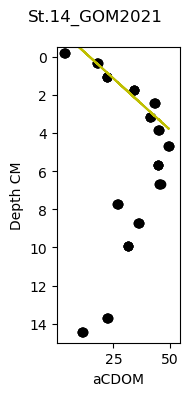

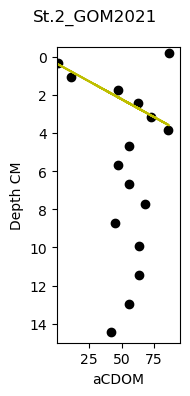

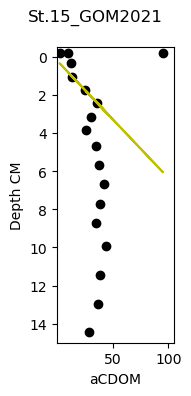

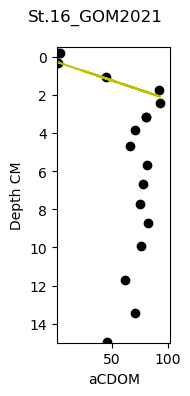

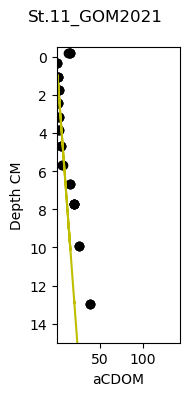

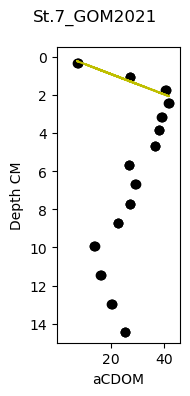

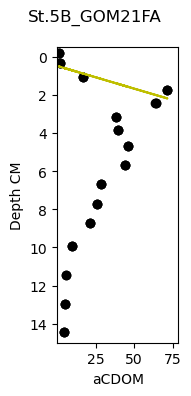

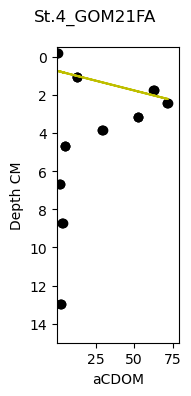

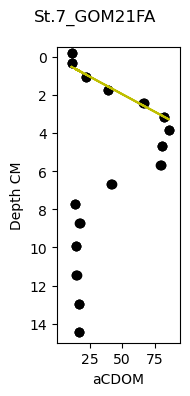

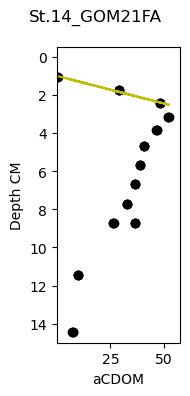

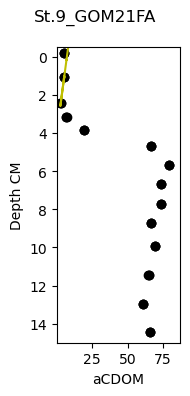

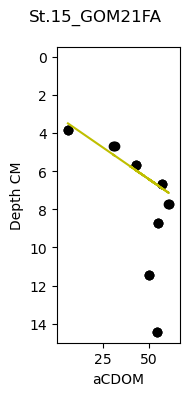

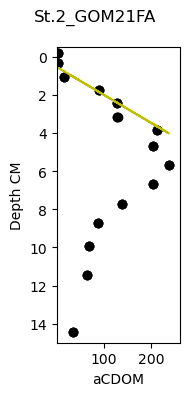

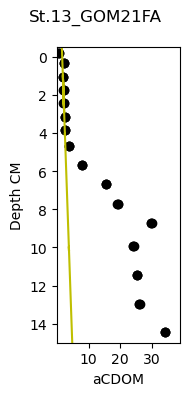

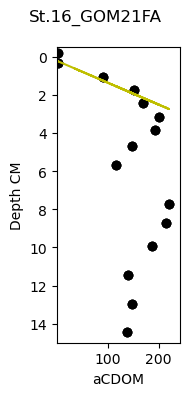

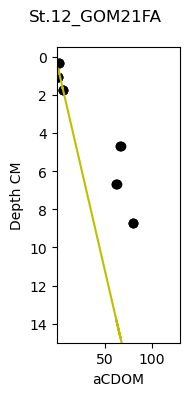

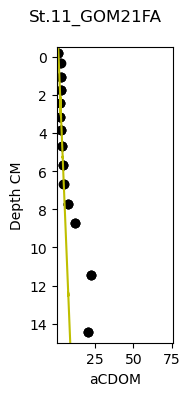

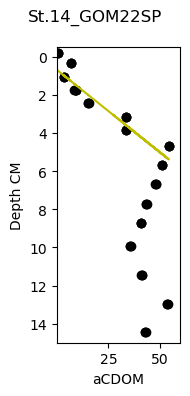

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\1266195226.py:44: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


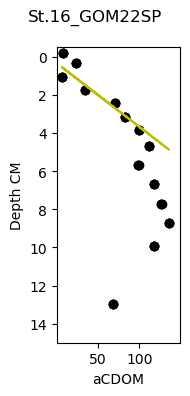

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\1266195226.py:44: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


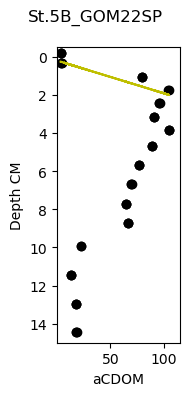

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\1266195226.py:44: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


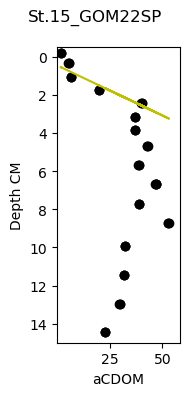

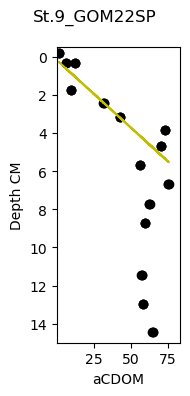

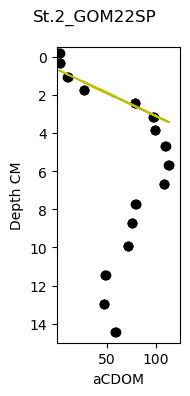

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\1266195226.py:44: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


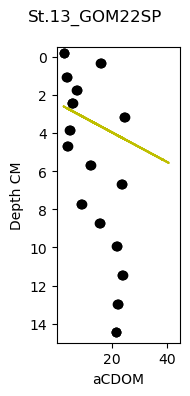

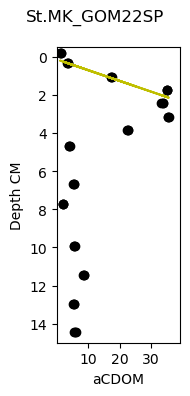

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\1266195226.py:44: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


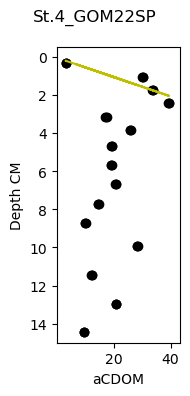

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\1266195226.py:44: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


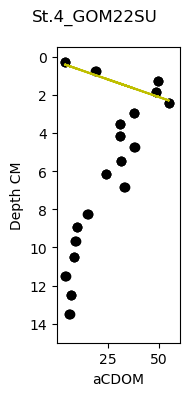

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\1266195226.py:44: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


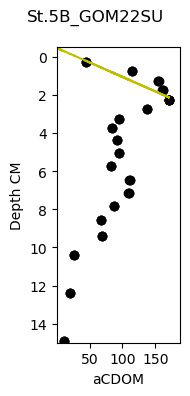

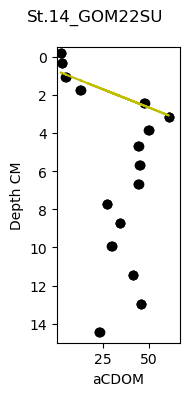

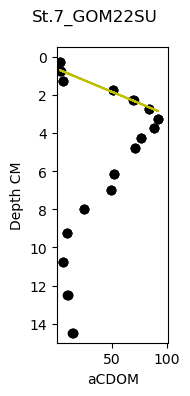

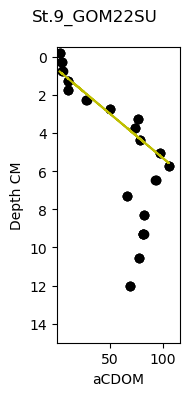

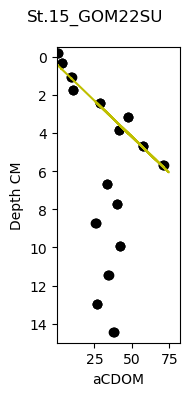

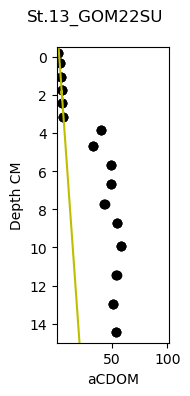

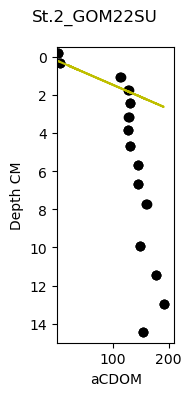

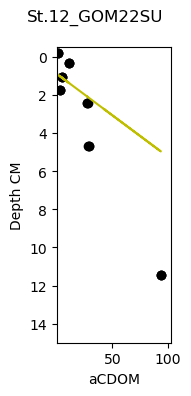

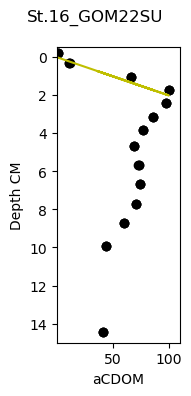

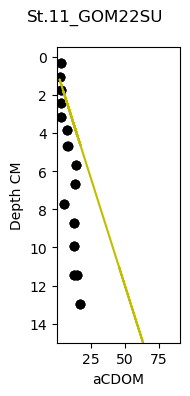

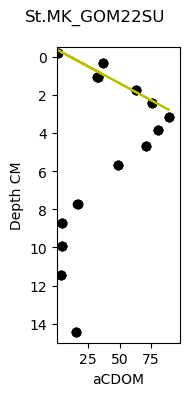

slope_cdom_350_pw  rsquared_cdom_350_pw  std_err_cdom_350_pw  \
code                                                                          
St.14_GOM2021       3.685420e+08              0.887058         2.485193e+07   
St.2_GOM2021        1.148479e+09              0.956443         1.225440e+08   
St.15_GOM2021       7.260866e+08              1.000000         0.000000e+00   
St.16_GOM2021       2.068857e+09              0.899776         4.882415e+08   
St.11_GOM2021       1.777727e+07              0.240935         9.513900e+06   
St.7_GOM2021        7.357160e+08              0.883914         8.431291e+07   
St.5B_GOM21FA       1.534001e+09              0.818495         2.284344e+08   
St.4_GOM21FA        1.868530e+09              0.861053         2.837015e+08   
St.7_GOM21FA        1.162557e+09              0.961348         7.371580e+07   
St.14_GOM21FA       1.528658e+09              0.986987         6.634395e+07   
St.9_GOM21FA       -7.848519e+07              0.975172         6.261673e+06   
St.15_GOM21FA       6.172873e+08              0.918908         5.085915e+07   
St.2_GOM21FA        2.856056e+09              0.936170         2.358307e+08   
St.13_GOM21FA       5.084526e+06              0.537620         1.782229e+06   
St.16_GOM21FA       3.620346e+09              0.928690         3.172411e+08   
St.12_GOM21FA       1.161020e+08              0.558937         3.898159e+07   
St.11_GOM21FA       1.114879e+07              0.490445         2.607062e+06   
St.14_GOM22SP       4.287441e+08              0.828961         4.467891e+07   
St.16_GOM22SP       1.184164e+09              0.881141         1.087291e+08   
St.5B_GOM22SP       1.872469e+09              0.719152         3.900490e+08   
St.15_GOM22SP       7.476308e+08              0.880118         8.725558e+07   
St.9_GOM22SP        3.780990e+08              0.597152         9.820501e+07   
St.2_GOM22SP        1.556174e+09              0.851309         2.056637e+08   
St.13_GOM22SP       5.345856e+07              0.092530         3.283259e+07   
St.MK_GOM22SP       6.912475e+08              0.869393         8.472453e+07   
St.4_GOM22SP        7.152233e+08              0.810345         1.094179e+08   
St.4_GOM22SU        6.300011e+08              0.520853         1.510629e+08   
St.5B_GOM22SU       1.725797e+09              0.584067         3.341128e+08   
St.14_GOM22SU       9.154450e+08              0.779596         1.539241e+08   
St.7_GOM22SU        1.654064e+09              0.891380         1.443497e+08   
St.9_GOM22SU        7.570746e+08              0.787052         9.844949e+07   
St.15_GOM22SU       4.964045e+08              0.841117         6.822532e+07   
St.13_GOM22SU       4.227947e+07              0.771906         7.267830e+06   
St.2_GOM22SU        2.496561e+09              0.707107         5.081061e+08   
St.12_GOM22SU       3.052360e+08              0.295706         1.489644e+08   
St.16_GOM22SU       1.874752e+09              0.837541         2.611030e+08   
St.11_GOM22SU       3.947491e+06              0.019811         8.780638e+06   
St.MK_GOM22SU       1.008885e+09              0.795839         1.417241e+08   

               flux_cdom_350_depth_pw  por_mean    por_sd  por_count  \
code                                                                   
St.14_GOM2021                     4.0  0.836101  0.026545        6.0   
St.2_GOM2021                      4.0  0.893612  0.018307        6.0   
St.15_GOM2021                     2.0  0.913782  0.023736        4.0   
St.16_GOM2021                     3.0  0.878884  0.012766        5.0   
St.11_GOM2021                     3.0  0.886510  0.010708        5.0   
St.7_GOM2021                      3.0  0.900131  0.015329        5.0   
St.5B_GOM21FA                     3.0  0.758168  0.033453        5.0   
St.4_GOM21FA                      3.0  0.707526  0.095821        6.0   
St.7_GOM21FA                      3.0  0.862729  0.013460        6.0   
St.14_GOM21FA                     3.0  0.826907  0.030170     

In [25]:
Frames = []

#CDOM / 2.303 = A 
#A / E = C 
E_10mg_L = (33*(350/320)+9.13*(350/410))/2 # 10 mg / L
# C is conc of SRHA Xiao 2013 (assuming no Fe) tabel 3
HA_molar_mass = 226.139
E_mol_L = E_10mg_L / 10 / 1000 / HA_molar_mass 
E_mmol_m3 = E_mol_L *1000 /1000
E_350 = E_mmol_m3

def cdom_flux_cal(code, depth1, depth2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 4)) 
    sub = df_cdom_pw_cl.loc[df_cdom_pw_cl['code'] == codes[code]]
    y = sub['Sample_depth']
    x = sub['a350']
    axs.scatter(x, y, c="black")
    yy = sub.loc[(sub['Sample_depth'] < depth1) & (sub['Sample_depth'] > depth2), 'Sample_depth'].ravel() 
    
    xx = sub.loc[(sub['Sample_depth'] < depth1) & (sub['Sample_depth'] > depth2), 'a350'].ravel()
    
    # Add subplot labels
    axs.set_xlabel('aCDOM')
    axs.set_ylabel('Depth CM')
    axs.set_ylim(15,-.50)
    axs.set_xlim(df_cdom_pw_cl['a350'].min(),sub['a350'].max()*1.1)
    
    if len(xx) > 1:
        # Add the slope value to the plot
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='y')        
        xx2 = sub.loc[(sub['Sample_depth'] < depth1) & (sub['Sample_depth'] > depth2), 'Sample_depth'].ravel()/1000
        yy2 = sub.loc[(sub['Sample_depth'] < depth1) & (sub['Sample_depth'] > depth2), 'a350'].ravel() 
        yy2 = yy2 / (E_350 * 2.303)

        slope, intercept, r_value, p_value, std_err = stats.linregress(xx2, yy2)
        
        slope = slope
        rsquared = r_value**2
        std_err = std_err
    
    df_p = df_por.loc[df_por['code'] == codes[code]]
    df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel() 
    por_mean = df_por_data.mean()
    por_std = df_por_data.std()
    por_count = len(df_por_data)

        
    dic = {'code':[codes[code]],
           'slope_cdom_350_pw':[slope],
           'rsquared_cdom_350_pw':[rsquared], 
           'std_err_cdom_350_pw':[std_err], 
           'flux_cdom_350_depth_pw': [depth1], 
           'por_mean':por_mean,
           'por_sd': por_std, 
           'por_count':por_count}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
        
    # Add subplot labels
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
cdom_flux_cal(0, 4, 0)
cdom_flux_cal(1, 4, 0)
cdom_flux_cal(2, 2, .5)
cdom_flux_cal(3, 3, 0)
cdom_flux_cal(4, 3, 0)
cdom_flux_cal(5, 3, 0)
cdom_flux_cal(6, 3, 0)
cdom_flux_cal(7, 3, 0)
cdom_flux_cal(9, 3, 0)
cdom_flux_cal(10, 3, 0)
cdom_flux_cal(11, 3, 0)
cdom_flux_cal(12, 8, 1)
cdom_flux_cal(13, 3, 0)
cdom_flux_cal(14, 3, 1)
cdom_flux_cal(15, 3, 0)
cdom_flux_cal(16, 3, 0)
cdom_flux_cal(17, 6, .5)
cdom_flux_cal(19, 4, 0)
cdom_flux_cal(20, 4, 0)
cdom_flux_cal(21, 3, 0)
cdom_flux_cal(22, 3, 0)
cdom_flux_cal(23, 3, 0)
cdom_flux_cal(24, 3, 0)
cdom_flux_cal(25, 7, 0)
cdom_flux_cal(26, 3, 0)
cdom_flux_cal(27, 3, 0)
cdom_flux_cal(28, 3, 0)
cdom_flux_cal(29, 3, 0)
cdom_flux_cal(30, 3, 0)
cdom_flux_cal(31, 3, 0)
cdom_flux_cal(32, 3, 0)
cdom_flux_cal(33, 3, 0)
cdom_flux_cal(34, 3, 0)
cdom_flux_cal(35, 3, 0)
cdom_flux_cal(36, 3, 0)
cdom_flux_cal(37, 3, 0)
cdom_flux_cal(38, 3, 0)
cdom_flux_cal(39, 3, 0)

slopes_cdom_pw_350 = pd.concat(Frames, axis=0, ignore_index=False)

A = np.pi*(4.2388**2) 
slopes_cdom_pw_350['por_mean'].fillna(0.85, inplace=True)
slopes_cdom_pw_350['por_sd'].fillna(0, inplace=True)
slopes_cdom_pw_350['por_SE'] = slopes_cdom_pw_350['por_sd'] / (np.sqrt(slopes_cdom_pw_350['por_count']))
slopes_cdom_pw_350['por_SE'].fillna(0, inplace=True)

D_c = 2.6 * (10**-6) / 10000 * (86400) #0.000001728 

slopes_cdom_pw_350["pw_flux_aCDOM350"] = slopes_cdom_pw_350["slope_cdom_350_pw"] * slopes_cdom_pw_350["por_mean"] * D_c * (E_350 * 2.303)
slopes_cdom_pw_350 = pd.concat([slopes_cdom_pw_350, df_lat_lon], axis=1, join='outer')
slopes_cdom_pw_350['Stn'] = slopes_cdom_pw_350.index.str.split('_').str[0]
slopes_cdom_pw_350['Camp'] = slopes_cdom_pw_350.index.str.split('_').str[1]
slopes_cdom_pw_350 = slopes_cdom_pw_350.dropna(subset=['pw_flux_aCDOM350'])

slopes_cdom_pw_350 

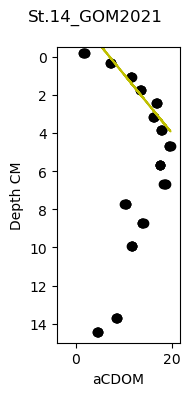

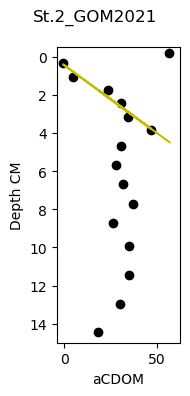

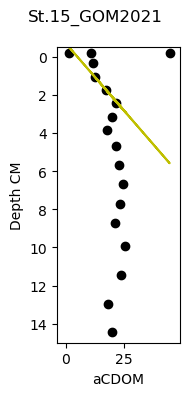

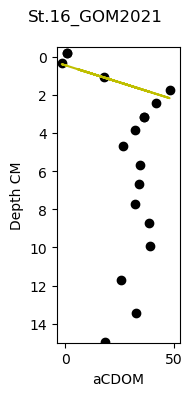

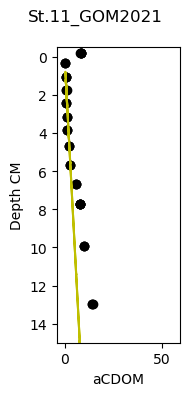

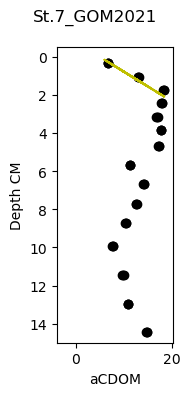

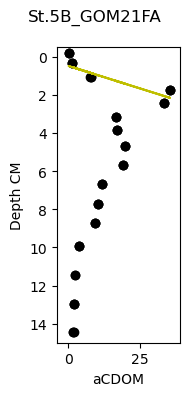

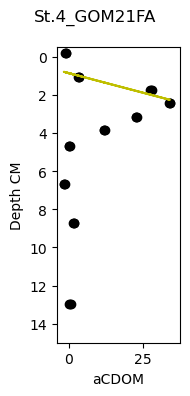

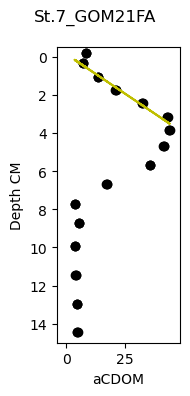

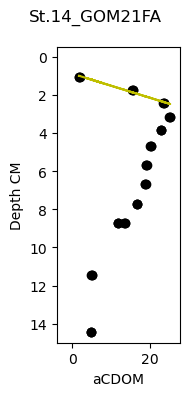

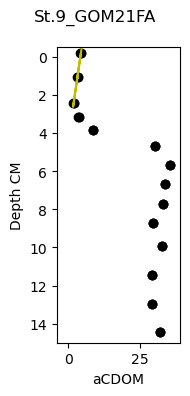

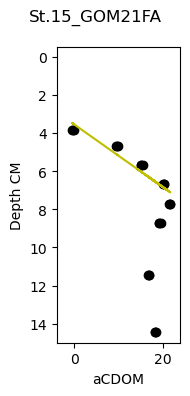

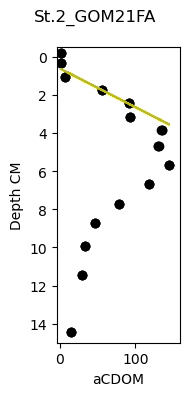

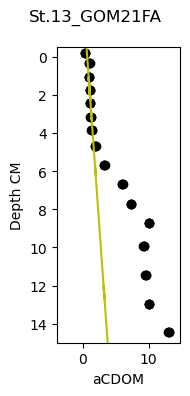

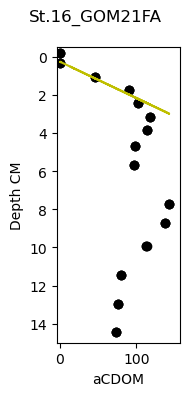

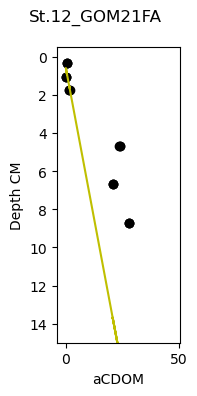

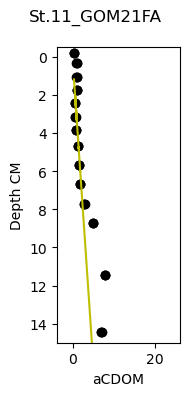

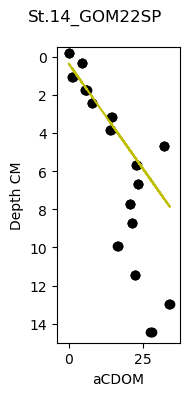

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3363389793.py:44: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


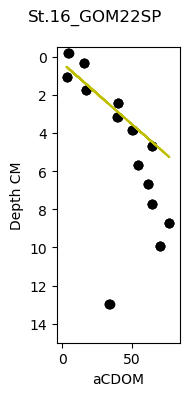

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3363389793.py:44: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


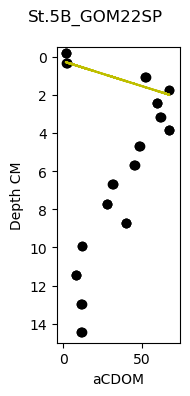

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3363389793.py:44: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


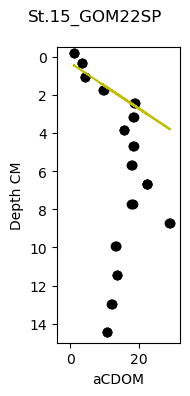

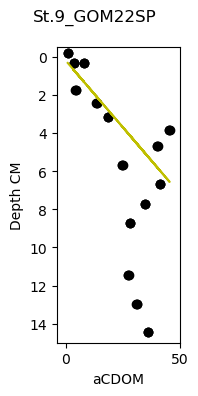

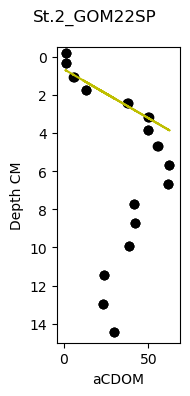

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3363389793.py:44: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


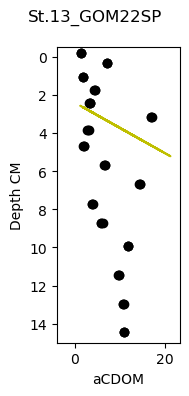

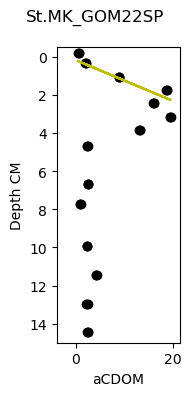

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3363389793.py:44: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


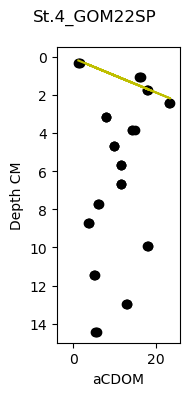

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3363389793.py:44: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


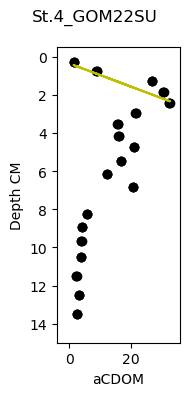

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_23604\3363389793.py:44: RuntimeWarning: Mean of empty slice.
  por_mean = df_por_data.mean()
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


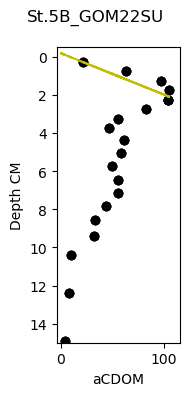

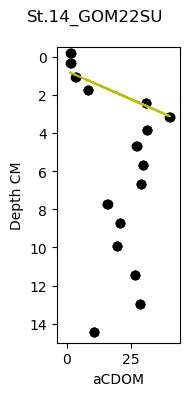

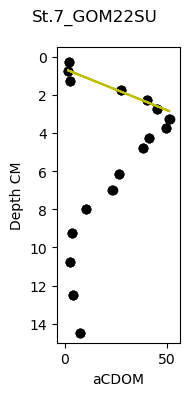

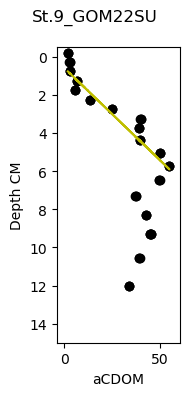

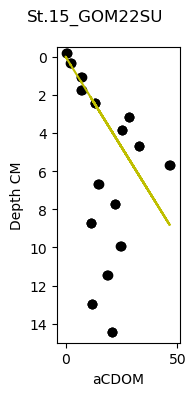

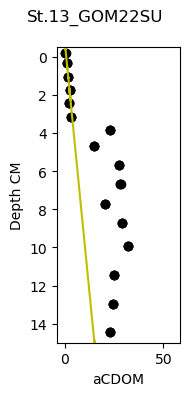

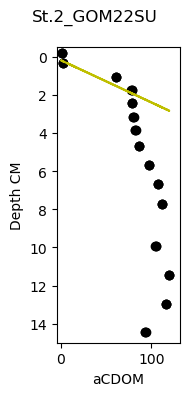

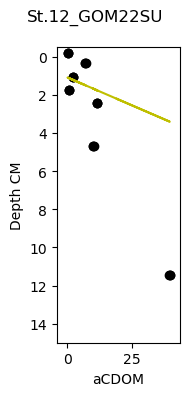

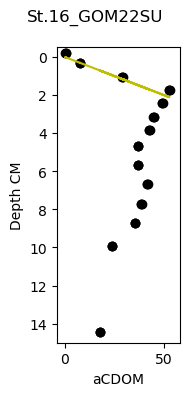

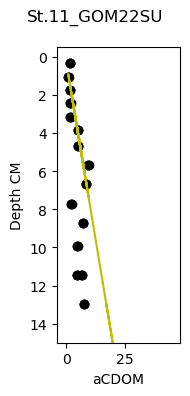

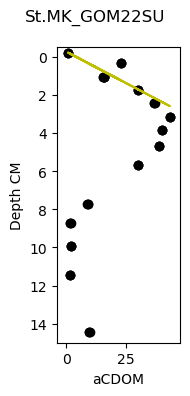

slope_cdom_412_pw  rsquared_cdom_412_pw  std_err_cdom_412_pw  \
code                                                                          
St.14_GOM2021       5.472668e+08              0.886659         3.697735e+07   
St.2_GOM2021        2.585183e+09              0.963418         2.518750e+08   
St.15_GOM2021       1.363070e+09              1.000000         0.000000e+00   
St.16_GOM2021       4.372979e+09              0.825356         1.422389e+09   
St.11_GOM2021       2.349890e+07              0.236446         1.273226e+07   
St.7_GOM2021        1.048928e+09              0.855141         1.365211e+08   
St.5B_GOM21FA       3.392659e+09              0.841459         4.656874e+08   
St.4_GOM21FA        4.133196e+09              0.897835         5.269758e+08   
St.7_GOM21FA        2.240066e+09              0.982076         9.569850e+07   
St.14_GOM21FA       2.945137e+09              0.976583         1.723720e+08   
St.9_GOM21FA       -1.781969e+08              0.972133         1.508523e+07   
St.15_GOM21FA       1.056575e+09              0.912136         9.095016e+07   
St.2_GOM21FA        8.693577e+09              0.927888         7.663999e+08   
St.13_GOM21FA       2.227551e+07              0.565689         7.377175e+06   
St.16_GOM21FA       9.440520e+09              0.947434         7.031946e+08   
St.12_GOM21FA       1.520139e+08              0.504226         5.697231e+07   
St.11_GOM21FA       2.322517e+07              0.384990         6.734389e+06   
St.14_GOM22SP       6.946928e+08              0.807973         7.769610e+07   
St.16_GOM22SP       2.391771e+09              0.804609         2.946586e+08   
St.5B_GOM22SP       4.975655e+09              0.679902         1.138012e+09   
St.15_GOM22SP       1.398547e+09              0.884332         1.599466e+08   
St.9_GOM22SP        4.981069e+08              0.364847         2.078289e+08   
St.2_GOM22SP        3.173328e+09              0.859589         4.055741e+08   
St.13_GOM22SP       1.687159e+08              0.118279         9.034032e+07   
St.MK_GOM22SP       1.413557e+09              0.793636         2.279393e+08   
St.4_GOM22SP        1.825656e+09              0.861279         2.316956e+08   
St.4_GOM22SU        1.699287e+09              0.547730         3.860311e+08   
St.5B_GOM22SU       4.914752e+09              0.559086         1.001296e+09   
St.14_GOM22SU       2.552577e+09              0.786418         4.206625e+08   
St.7_GOM22SU        3.897775e+09              0.880328         3.592778e+08   
St.9_GOM22SU        1.513045e+09              0.769742         2.068838e+08   
St.15_GOM22SU       8.958795e+08              0.891433         9.886784e+07   
St.13_GOM22SU       1.176190e+08              0.650458         2.726576e+07   
St.2_GOM22SU        6.626039e+09              0.772514         1.137046e+09   
St.12_GOM22SU       3.318722e+08              0.102974         3.097483e+08   
St.16_GOM22SU       4.025812e+09              0.849103         5.366780e+08   
St.11_GOM22SU       3.047248e+07              0.119537         2.615249e+07   
St.MK_GOM22SU       1.696886e+09              0.586777         3.949454e+08   

               flux_cdom_412_depth_pw  por_mean    por_sd  por_count  \
code                                                                   
St.14_GOM2021                     4.0  0.836101  0.026545        6.0   
St.2_GOM2021                      4.0  0.893612  0.018307        6.0   
St.15_GOM2021                     2.0  0.913782  0.023736        4.0   
St.16_GOM2021                     3.0  0.878884  0.012766        5.0   
St.11_GOM2021                     3.0  0.886510  0.010708        5.0   
St.7_GOM2021                      3.0  0.900131  0.015329        5.0   
St.5B_GOM21FA                     3.0  0.758168  0.033453        5.0   
St.4_GOM21FA                      3.0  0.707526  0.095821        6.0   
St.7_GOM21FA                      3.0  0.862729  0.013460        6.0   
St.14_GOM21FA                     3.0  0.826907  0.030170     

In [26]:
Frames = []

#CDOM / 2.303 = A 
#A / E = C 
E_10mg_L = (1.54*(412/550)+9.13*(412/410))/2 # 10 mg / L
# C is conc of SRHA Xiao 2013 (assuming no Fe) tabel 3
HA_molar_mass = 226.139
E_mol_L = E_10mg_L / 10 / 1000 / HA_molar_mass 
E_mmol_m3 = E_mol_L *1000 /1000
E_412 = E_mmol_m3

def cdom_flux_cal(code, depth1, depth2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 4)) 
    sub = df_cdom_pw_cl.loc[df_cdom_pw_cl['code'] == codes[code]]
    y = sub['Sample_depth']
    x = sub['a412']
    axs.scatter(x, y, c="black")
    yy = sub.loc[(sub['Sample_depth'] < depth1) & (sub['Sample_depth'] > depth2), 'Sample_depth'].ravel() 
    
    xx = sub.loc[(sub['Sample_depth'] < depth1) & (sub['Sample_depth'] > depth2), 'a412'].ravel()
    
    # Add subplot labels
    axs.set_xlabel('aCDOM')
    axs.set_ylabel('Depth CM')
    axs.set_ylim(15,-.50)
    axs.set_xlim(df_cdom_pw_cl['a412'].min(),sub['a412'].max()*1.1)
    
    if len(xx) > 1:
        # Add the slope value to the plot
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='y')        
        xx2 = sub.loc[(sub['Sample_depth'] < depth1) & (sub['Sample_depth'] > depth2), 'Sample_depth'].ravel()/1000
        yy2 = sub.loc[(sub['Sample_depth'] < depth1) & (sub['Sample_depth'] > depth2), 'a412'].ravel() 
        yy2 = yy2 / (E_412 * 2.303)

        slope, intercept, r_value, p_value, std_err = stats.linregress(xx2, yy2)
        
        slope = slope
        rsquared = r_value**2
        std_err = std_err
    
    df_p = df_por.loc[df_por['code'] == codes[code]]
    df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel() 
    por_mean = df_por_data.mean()
    por_std = df_por_data.std()
    por_count = len(df_por_data)

        
    dic = {'code':[codes[code]],
           'slope_cdom_412_pw':[slope],
           'rsquared_cdom_412_pw':[rsquared], 
           'std_err_cdom_412_pw':[std_err], 
           'flux_cdom_412_depth_pw': [depth1], 
           'por_mean':por_mean,
           'por_sd': por_std, 
           'por_count':por_count}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
        
    # Add subplot labels
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
cdom_flux_cal(0, 4, 0)
cdom_flux_cal(1, 4, 0)
cdom_flux_cal(2, 2, .5)
cdom_flux_cal(3, 3, 0)
cdom_flux_cal(4, 3, 0)
cdom_flux_cal(5, 3, 0)
cdom_flux_cal(6, 3, 0)
cdom_flux_cal(7, 3, 0)
cdom_flux_cal(9, 3, 0)
cdom_flux_cal(10, 3, 0)
cdom_flux_cal(11, 3, 0)
cdom_flux_cal(12, 8, 1)
cdom_flux_cal(13, 3, 0)
cdom_flux_cal(14, 3, 1)
cdom_flux_cal(15, 3, 0)
cdom_flux_cal(16, 3, 0)
cdom_flux_cal(17, 6, .5)
cdom_flux_cal(19, 4, 0)
cdom_flux_cal(20, 4, 0)
cdom_flux_cal(21, 3, 0)
cdom_flux_cal(22, 3, 0)
cdom_flux_cal(23, 3, 0)
cdom_flux_cal(24, 3, 0)
cdom_flux_cal(25, 7, 0)
cdom_flux_cal(26, 3, 0)
cdom_flux_cal(27, 3, 0)
cdom_flux_cal(28, 3, 0)
cdom_flux_cal(29, 3, 0)
cdom_flux_cal(30, 3, 0)
cdom_flux_cal(31, 3, 0)
cdom_flux_cal(32, 3, 0)
cdom_flux_cal(33, 3, 0)
cdom_flux_cal(34, 3, 0)
cdom_flux_cal(35, 3, 0)
cdom_flux_cal(36, 3, 0)
cdom_flux_cal(37, 3, 0)
cdom_flux_cal(38, 3, 0)
cdom_flux_cal(39, 3, 0)

slopes_cdom_pw_412 = pd.concat(Frames, axis=0, ignore_index=False)

A = np.pi*(4.2388**2) 
slopes_cdom_pw_412['por_mean'].fillna(0.85, inplace=True)
slopes_cdom_pw_412['por_sd'].fillna(0, inplace=True)
slopes_cdom_pw_412['por_SE'] = slopes_cdom_pw_412['por_sd'] / (np.sqrt(slopes_cdom_pw_412['por_count']))
slopes_cdom_pw_412['por_SE'].fillna(0, inplace=True)

D_c = 2.6 * (10**-6) / 10000 * (86400) #0.000001728 

slopes_cdom_pw_412["pw_flux_aCDOM412"] = slopes_cdom_pw_412["slope_cdom_412_pw"] * slopes_cdom_pw_412["por_mean"] * D_c * (E_412 * 2.303)
slopes_cdom_pw_412 = pd.concat([slopes_cdom_pw_412, df_lat_lon], axis=1, join='outer')
slopes_cdom_pw_412['Stn'] = slopes_cdom_pw_412.index.str.split('_').str[0]
slopes_cdom_pw_412['Camp'] = slopes_cdom_pw_412.index.str.split('_').str[1]
slopes_cdom_pw_412 = slopes_cdom_pw_412.dropna(subset=['pw_flux_aCDOM412'])

slopes_cdom_pw_412 

## Benthic Chamber

In [27]:
#figure calculate Benthic chamber 

# Drop the rows where 'dil_fac' is greater than 6
df_doc_bc = df_doc_bc[df_doc_bc['dil_fac'] <= 2]

#DOC slopes 
df_doc_bc_plot = df_doc_bc[(df_doc_bc['NPOC_uM'] != 0)]
df_doc_bc_plot = df_doc_bc_plot.dropna(subset=["NPOC_uM"])
df_doc_bc_plot = df_doc_bc_plot[df_doc_bc_plot['code'] != 'St.13_GOM22SP']
codes = df_doc_bc_plot['code'].unique()

print(codes)

['St.5B_GOM21FA' 'St.15_GOM21FA' 'St.MK_GOM21FA' 'St.14_GOM21FA'
 'St.9_GOM21FA' 'St.7_GOM21FA' 'St.13_GOM21FA' 'St.12_GOM21FA'
 'St.7_GOM22SP' 'St.5B_GOM22SP' 'St.9_GOM22SP' 'St.14_GOM22SP'
 'St.16_GOM22SP' 'St.MK_GOM22SP' 'St.15_GOM22SP' 'St.2_GOM22SP'
 'St.4_GOM22SP' 'St.4_GOM22SU' 'St.5B_GOM22SU' 'St.14_GOM22SU'
 'St.MK_GOM22SU' 'St.7_GOM22SU' 'St.9_GOM22SU' 'St.15_GOM22SU'
 'St.2_GOM22SU' 'St.13_GOM22SU' 'St.12_GOM22SU' 'St.16_GOM22SU'
 'St.11_GOM22SU']


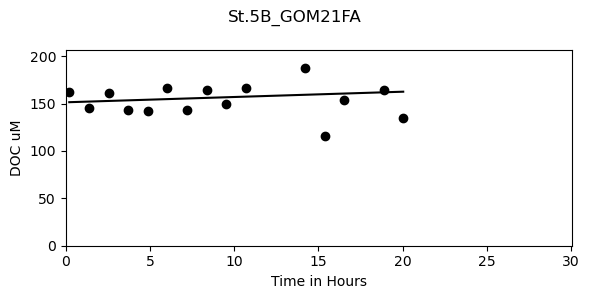

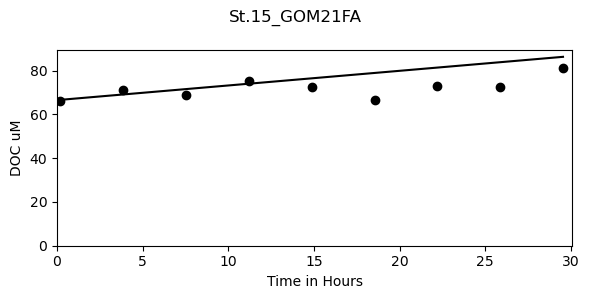

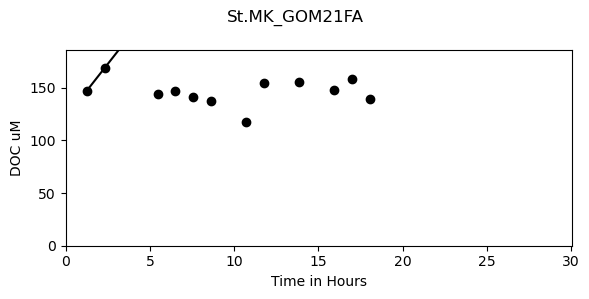

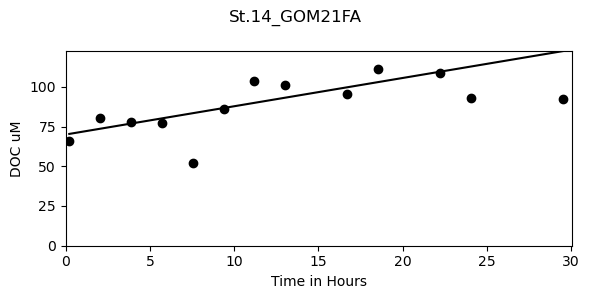

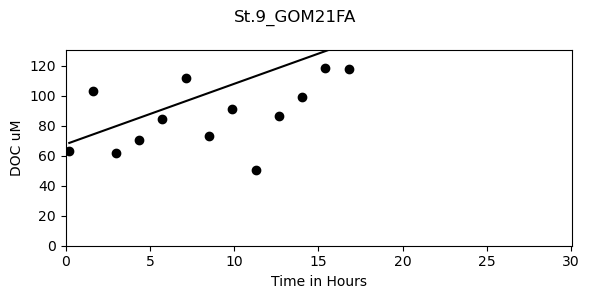

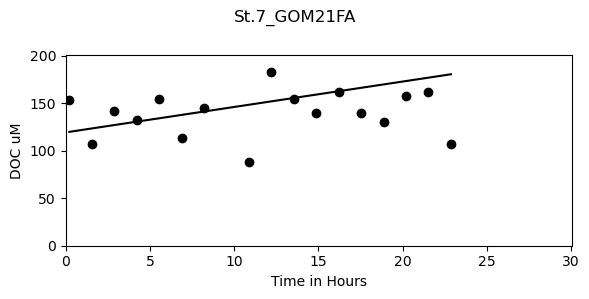

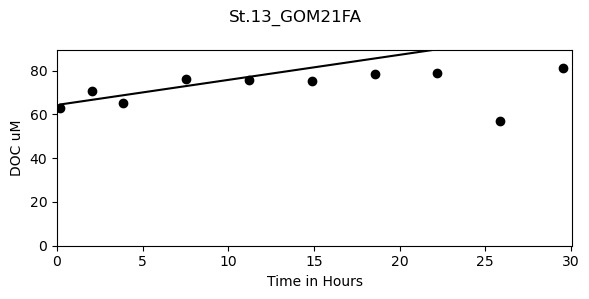

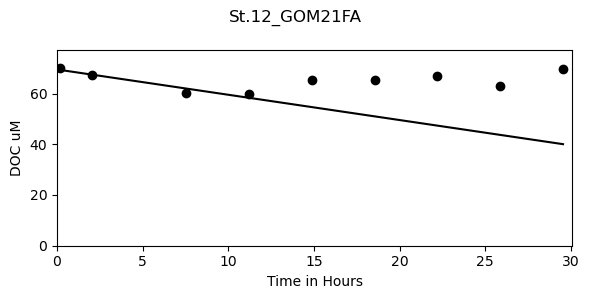

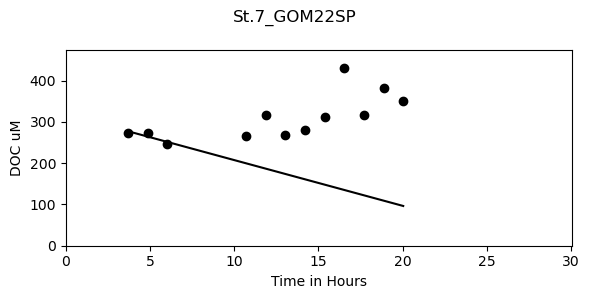

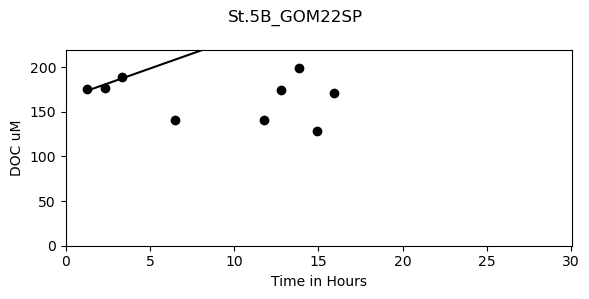

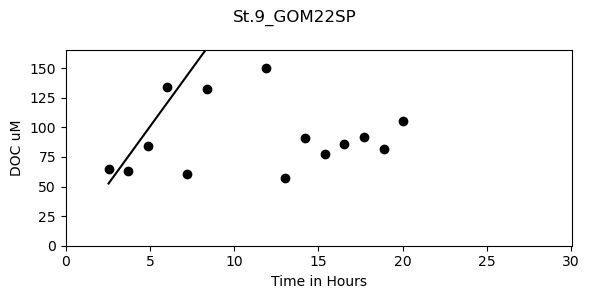

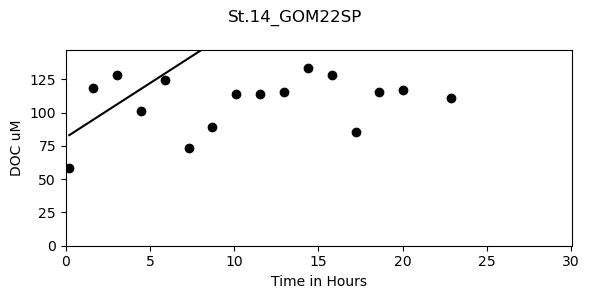

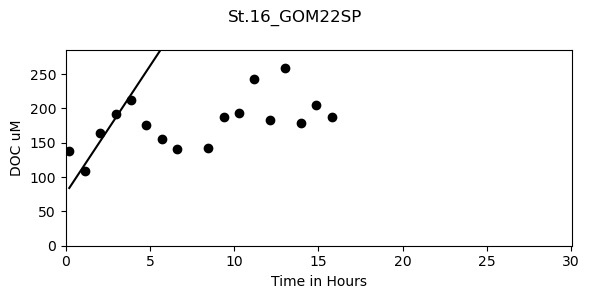

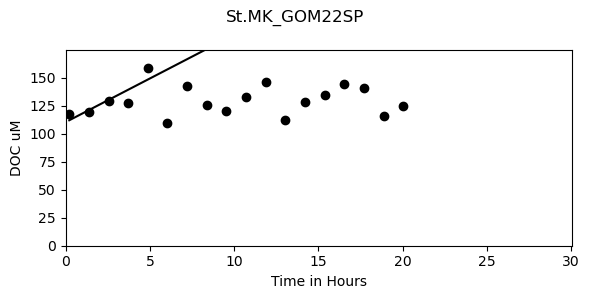

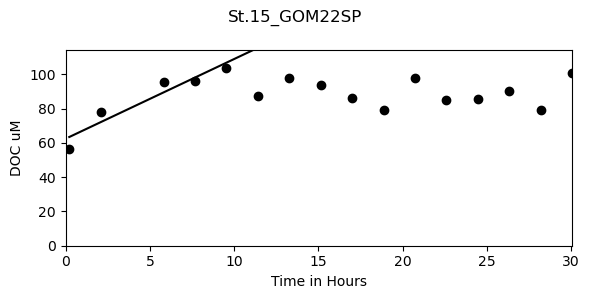

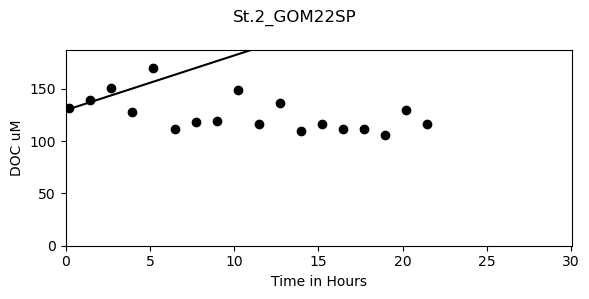

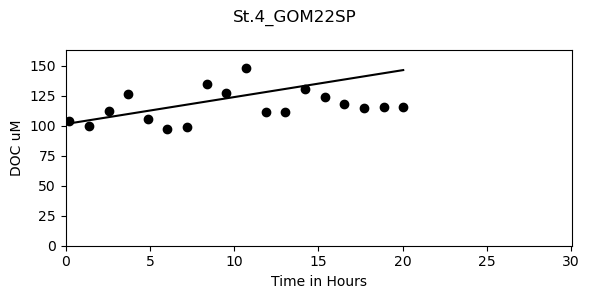

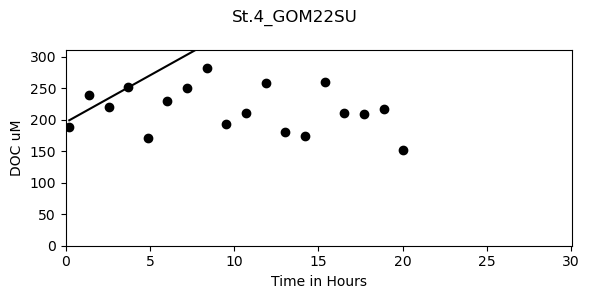

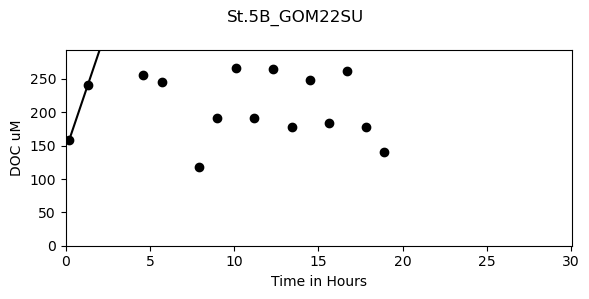

C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


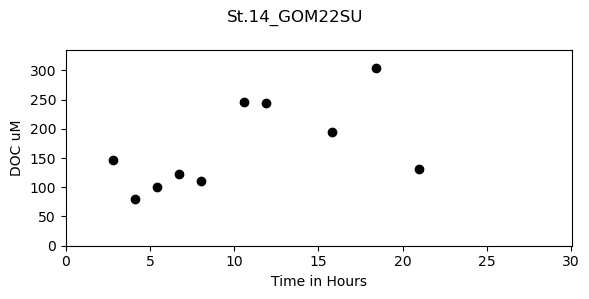

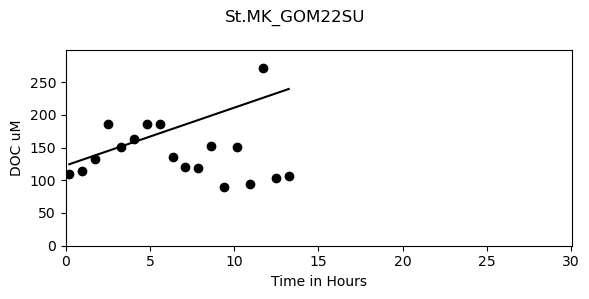

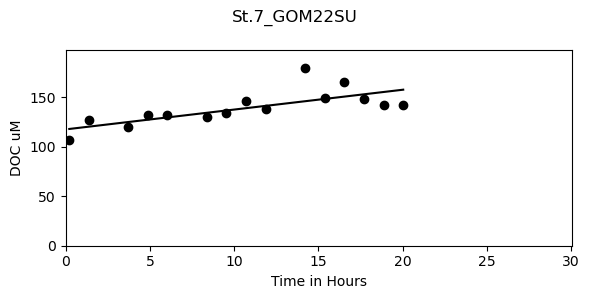

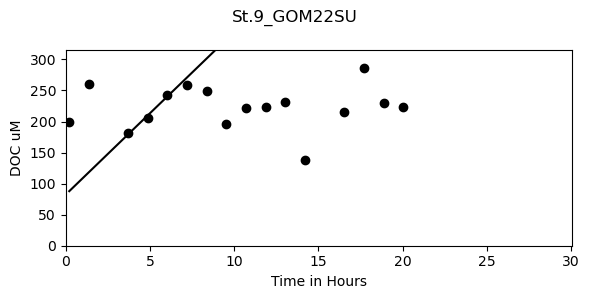

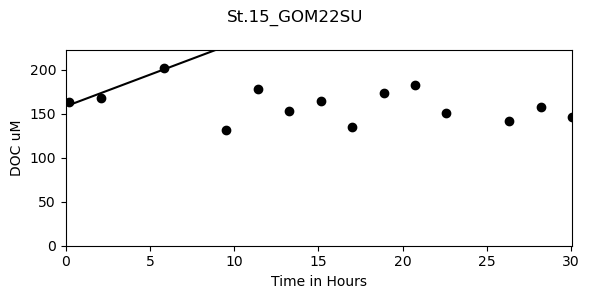

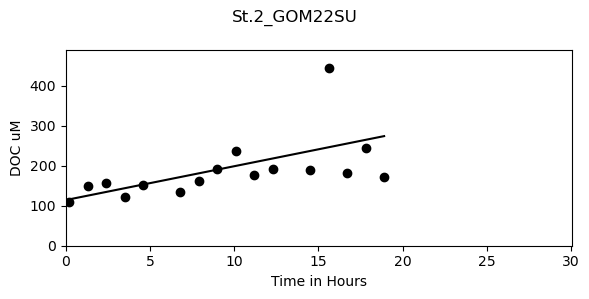

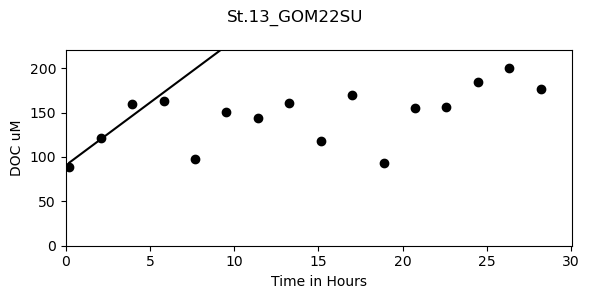

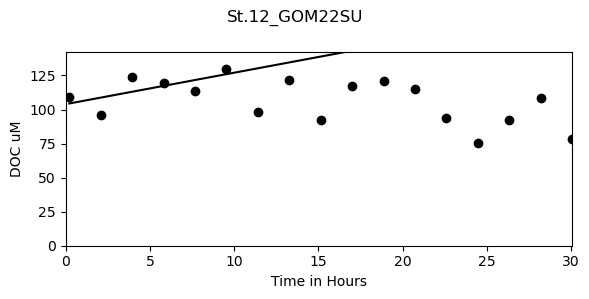

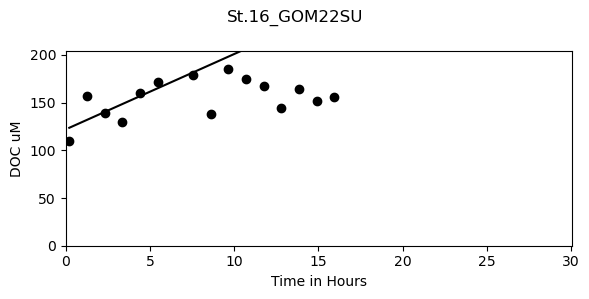

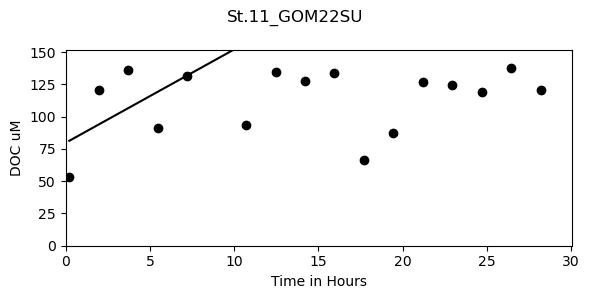

slope_doc_bc  rsquared_doc_bc  std_err_doc_bc  \
code                                                           
St.5B_GOM21FA      0.558488         0.034495        1.044638   
St.15_GOM21FA      0.669432         0.671371        0.331179   
St.MK_GOM21FA     20.394436         1.000000        0.000000   
St.14_GOM21FA      1.777518         0.409972        1.507851   
St.9_GOM21FA       4.022430         0.246080        3.520331   
St.7_GOM21FA       2.672240         0.132028        3.425833   
St.13_GOM21FA      1.145827         0.709124        0.423693   
St.12_GOM21FA     -0.996918         0.925517        0.199978   
St.7_GOM22SP     -11.076840         0.700829        7.237186   
St.5B_GOM22SP      6.662387         0.811342        3.212668   
St.9_GOM22SP      19.573622         0.797613        6.971909   
St.14_GOM22SP      8.152290         0.403972        5.717112   
St.16_GOM22SP     37.095455         0.948457        6.114822   
St.MK_GOM22SP      7.803571         0.740511        2.667019   
St.15_GOM22SP      4.648463         0.906218        0.863359   
St.2_GOM22SP       5.220000         0.364585        3.978686   
St.4_GOM22SP       2.242532         0.268081        1.235138   
St.4_GOM22SU      14.870536         0.637510        7.928962   
St.5B_GOM22SU     74.659091         1.000000        0.000000   
St.MK_GOM22SU      8.817029         0.371415        4.335361   
St.7_GOM22SU       2.003037         0.630095        0.686351   
St.9_GOM22SU      26.183036         0.989726        2.667668   
St.15_GOM22SU      7.188008         0.949981        1.649380   
St.2_GOM22SU       8.458574         0.597881        2.621912   
St.13_GOM22SU     14.107143         0.926323        2.813253   
St.12_GOM22SU      2.307945         0.456216        1.259863   
St.16_GOM22SU      7.895446         0.661080        2.528208   
St.11_GOM22SU      7.231871         0.337235        5.853341   

               flux_time_doc_bc     Camp    Stn   Hight_m  Hight_error  \
code                                                                     
St.5B_GOM21FA              12.0  GOM21FA  St.5B  0.116667     0.004714   
St.15_GOM21FA              12.0  GOM21FA  St.15  0.140000     0.016330   
St.MK_GOM21FA               4.0  GOM21FA  St.MK  0.217500     0.010897   
St.14_GOM21FA               6.0  GOM21FA  St.14  0.158333     0.030641   
St.9_GOM21FA                8.0  GOM21FA   St.9  0.115000     0.010801   
St.7_GOM21FA               10.0  GOM21FA   St.7  0.170000     0.048477   
St.13_GOM21FA              12.0  GOM21FA  St.13  0.133333     0.008498   
St.12_GOM21FA              12.0  GOM21FA  St.12  0.145000     0.008165   
St.7_GOM22SP               10.0  GOM22SP   St.7  0.146667     0.010274   
St.5B_GOM22SP               6.0  GOM22SP  St.5B  0.168750     0.038467   
St.9_GOM22SP                7.0  GOM22SP   St.9  0.162500     0.021651   
St.14_GOM22SP               7.0  GOM22SP  St.14  0.140000     0.008165   
St.16_GOM22SP               4.0  GOM22SP  St.16  0.180000     0.048477   
St.MK_GOM22SP               5.0  GOM22SP  St.MK  0.136667     0.032998   
St.15_GOM22SP              10.0  GOM22SP  St.15  0.103333     0.047842   
St.2_GOM22SP                6.0  GOM22SP   St.2  0.088750     0.013405   
St.4_GOM22SP               12.0  GOM22SP   St.4  0.180000     0.021213   
St.4_GOM22SU                4.0  GOM22SU   St.4  0.042412     0.016330   
St.5B_GOM22SU               3.0  GOM22SU  St.5B  0.045239     0.000000   
St.MK_GOM22SU               7.0  GOM22SU  St.MK  0.053721     0.027386   
St.7_GOM22SU               12.0  GOM22SU   St.7  0.040527     0.036591   
St.9_GOM22SU                7.0  GOM22SU   St.9  0.030536     0.013019   
St.15_GOM22SU               8.0  GOM22SU  St.15  0.034118     0.014974   
St.2_GOM22SU               11.0  GOM22SU   St.2  0.027921     0.030491   
St.13_GOM22SU               7.0  GOM22SU  St.13  0.030159     0.016499   
St.12_GOM22SU              10.0  GOM22SU  St.12  0.044296     0.008498   
St.16_GOM22SU         

In [28]:
Frames = []

def doc_flux_cal(code, time1, time2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    sub = df_doc_bc_plot.loc[df_doc_bc_plot['code'] == codes[code]]
    x = sub['Time']
    y = sub['NPOC_uM']
    axs.scatter(x, y, c="black")
    xx = sub.loc[(sub['Time'] < time1) & (sub['Time'] > time2), 'Time'].ravel()
    yy = sub.loc[(sub['Time'] < time1) & (sub['Time'] > time2), 'NPOC_uM'].ravel()
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='black')
        # Add the slope value to the plot
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
        dic = {'code':[codes[code]],
               'slope_doc_bc':[slope],
               'rsquared_doc_bc':[rsquared], 
               'std_err_doc_bc':[std_err], 
               'flux_time_doc_bc': [time1]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
    # Add subplot labels
    axs.set_xlabel('Time in Hours')
    axs.set_ylabel('DOC uM')
    axs.set_xlim(0,df_doc_bc['Time'].max())
    axs.set_ylim(df_doc_bc['NPOC_uM'].min(),max(y)*1.1)
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
doc_flux_cal(0, 12, 0)
doc_flux_cal(1, 12, 0)
doc_flux_cal(2, 4, 0)
doc_flux_cal(3, 6, 0)
doc_flux_cal(4, 8, 0)
doc_flux_cal(5, 10, .5)
doc_flux_cal(6, 12, 0)
doc_flux_cal(7, 12, 0)
doc_flux_cal(8, 10, 0)
doc_flux_cal(9, 6, .5)
doc_flux_cal(10, 7, .5)
doc_flux_cal(11, 7, 0)
doc_flux_cal(12, 4, .5)
doc_flux_cal(13, 5, 0)
doc_flux_cal(14, 10, 0)
doc_flux_cal(15, 6, 0)
doc_flux_cal(16, 12, 0)
doc_flux_cal(17, 4, 0)
doc_flux_cal(18, 3, 0)
doc_flux_cal(19, 3, 0)
doc_flux_cal(20, 7, 0)
doc_flux_cal(21, 12, 3)
doc_flux_cal(22, 7, 3)
doc_flux_cal(23, 8, 0)
doc_flux_cal(24, 11, 0)
doc_flux_cal(25, 7, 0)
doc_flux_cal(26, 10, 0)
doc_flux_cal(27, 8, 0)
doc_flux_cal(28, 8, 0)

slopes_doc_bc = pd.concat(Frames, axis=0, ignore_index=False)

slopes_doc_bc = pd.concat([slopes_doc_bc, df_hights, df_lat_lon], axis=1, join='outer')
slopes_doc_bc = slopes_doc_bc.dropna(subset=['slope_doc_bc'])

slopes_doc_bc["bc_flux_doc"] = slopes_doc_bc["slope_doc_bc"] * slopes_doc_bc["Hight_m"]* 24 
slopes_doc_bc["bc_flux_doc_error"] = slopes_doc_bc["std_err_doc_bc"] * slopes_doc_bc["Hight_m"]* 24

slopes_doc_bc 

In [29]:
#figure calculate Benthic chamber 

#Nitrogen slops
df_tn_bc_plot = df_doc_bc[(df_doc_bc['TN_uM'] != 0)]
df_tn_bc_plot = df_tn_bc_plot.dropna(subset=["TN_uM"])
df_tn_bc_plot = df_tn_bc_plot[df_tn_bc_plot['code'] != 'St.13_GOM22SP']
codes = df_tn_bc_plot['code'].unique()

print(codes)
len(codes)

['St.5B_GOM21FA' 'St.15_GOM21FA' 'St.MK_GOM21FA' 'St.14_GOM21FA'
 'St.9_GOM21FA' 'St.7_GOM21FA' 'St.13_GOM21FA' 'St.12_GOM21FA'
 'St.7_GOM22SP' 'St.5B_GOM22SP' 'St.9_GOM22SP' 'St.14_GOM22SP'
 'St.16_GOM22SP' 'St.MK_GOM22SP' 'St.15_GOM22SP' 'St.2_GOM22SP'
 'St.4_GOM22SP' 'St.4_GOM22SU' 'St.5B_GOM22SU' 'St.14_GOM22SU'
 'St.MK_GOM22SU' 'St.7_GOM22SU' 'St.9_GOM22SU' 'St.15_GOM22SU'
 'St.2_GOM22SU' 'St.13_GOM22SU' 'St.12_GOM22SU' 'St.16_GOM22SU'
 'St.11_GOM22SU']


29

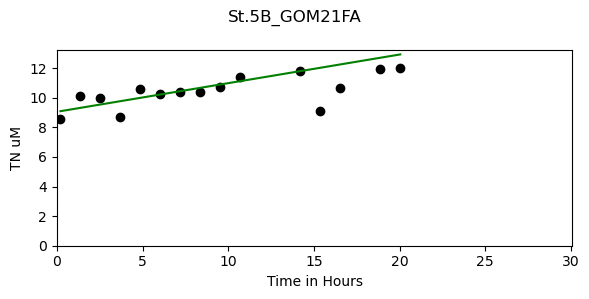

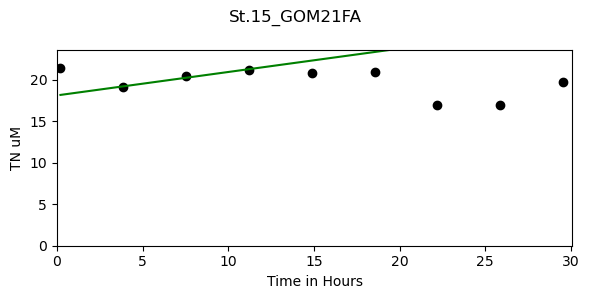

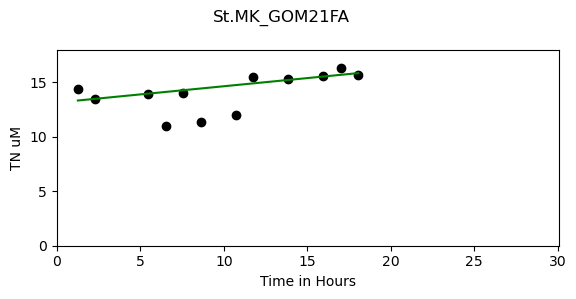

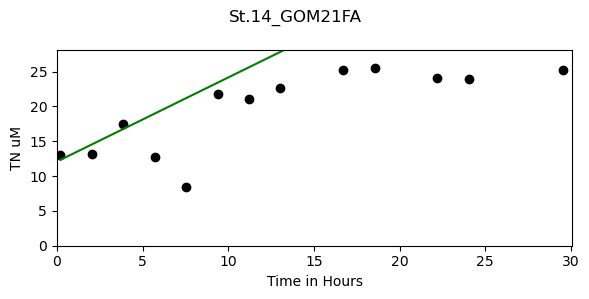

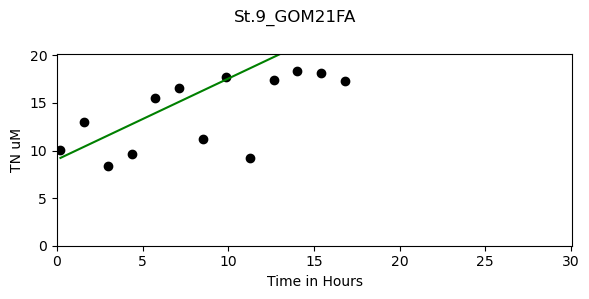

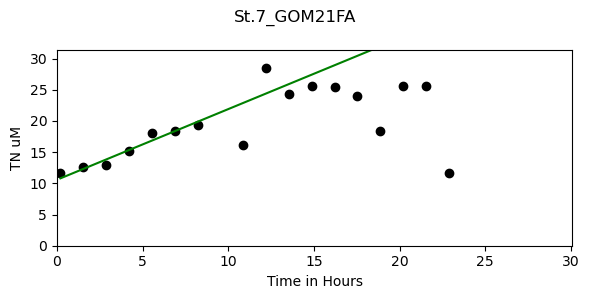

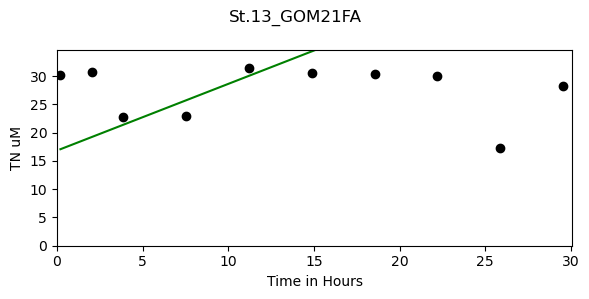

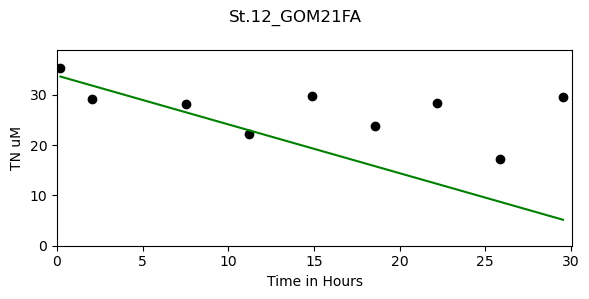

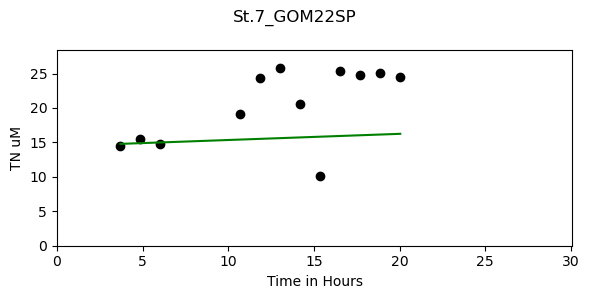

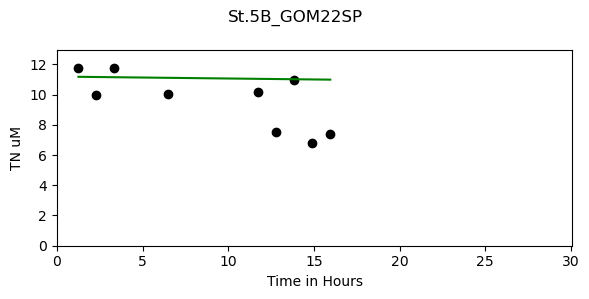

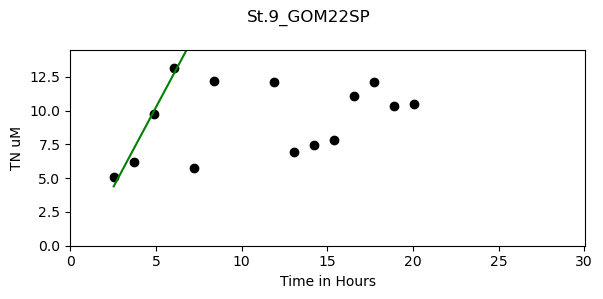

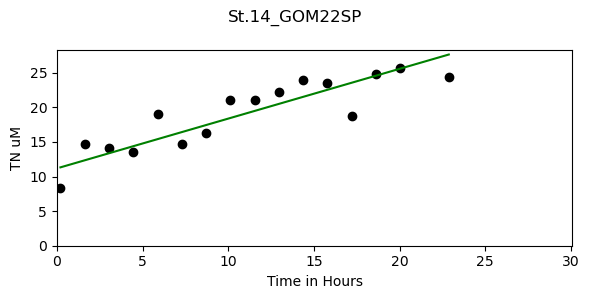

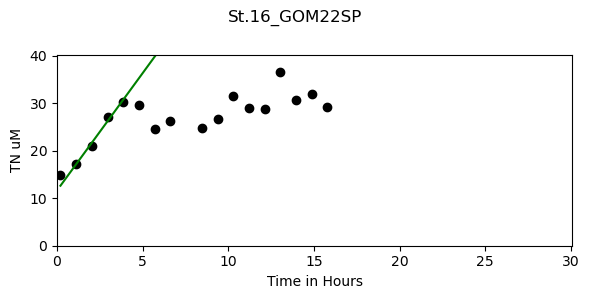

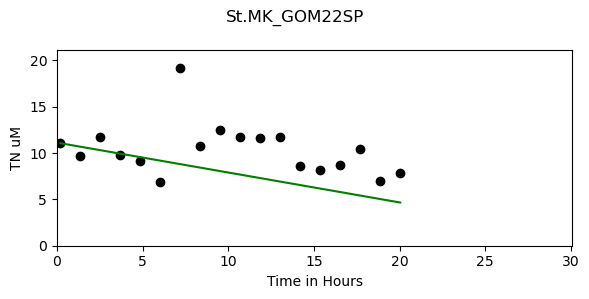

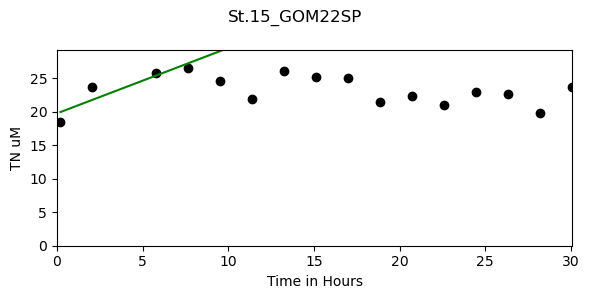

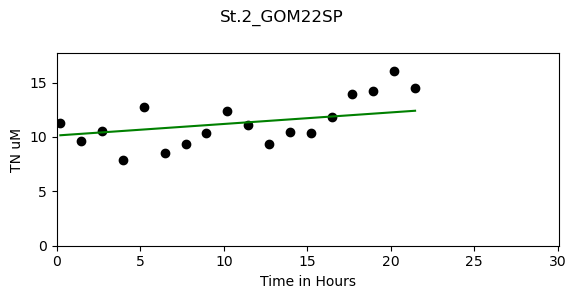

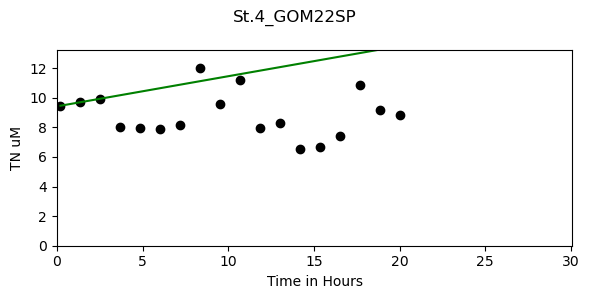

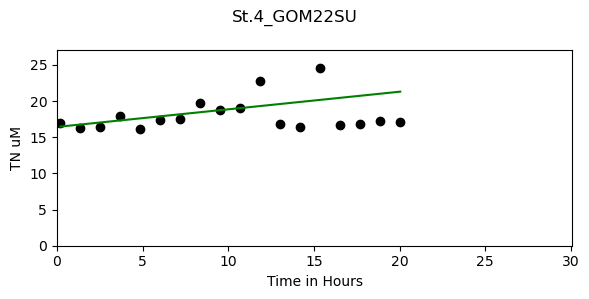

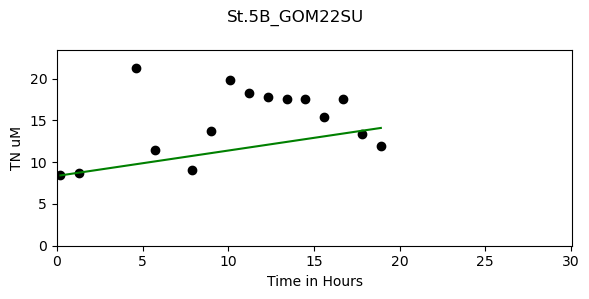

C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


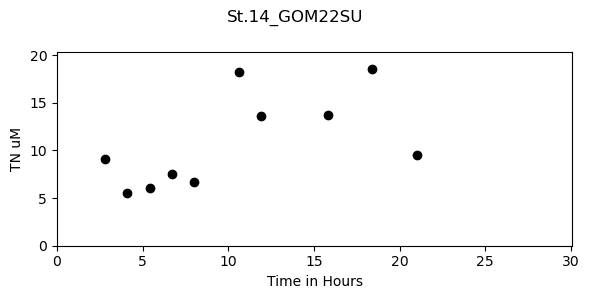

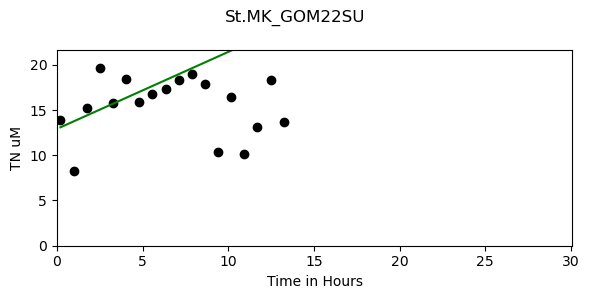

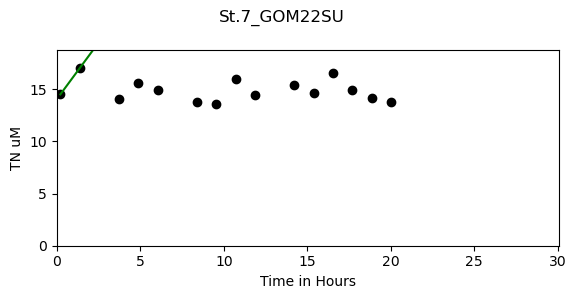

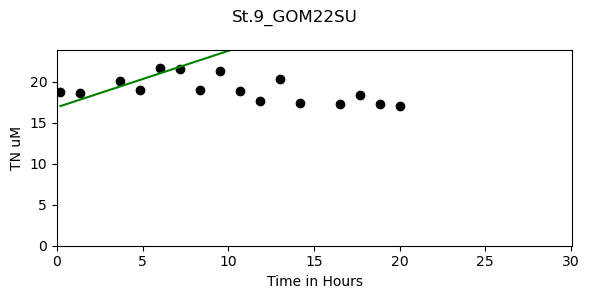

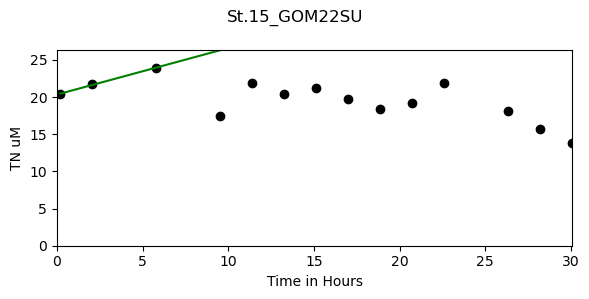

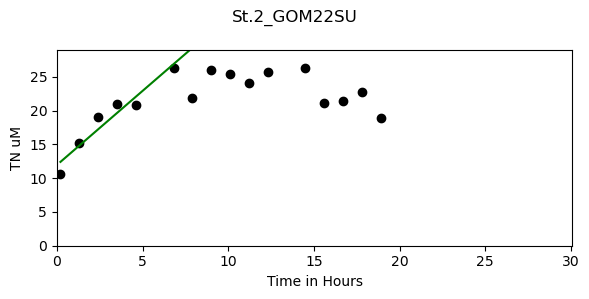

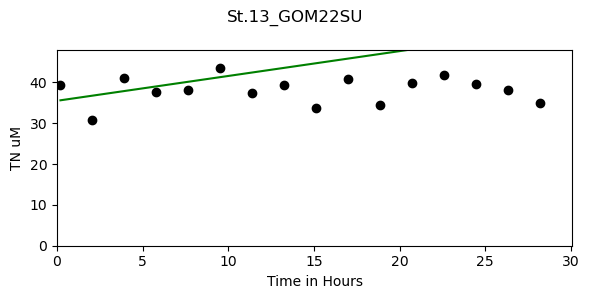

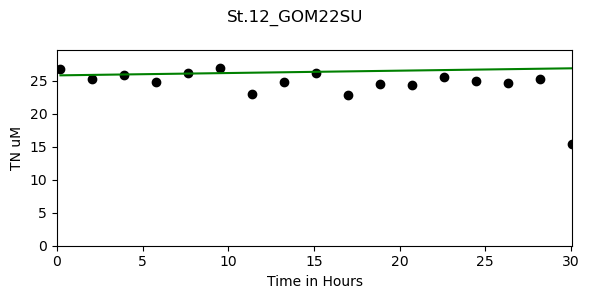

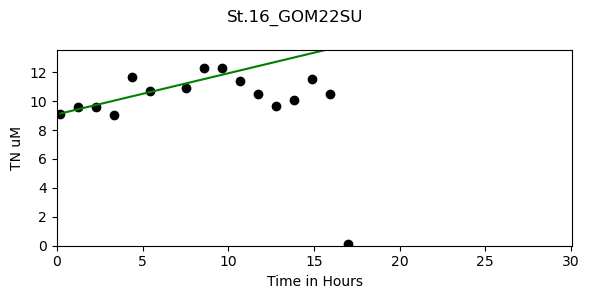

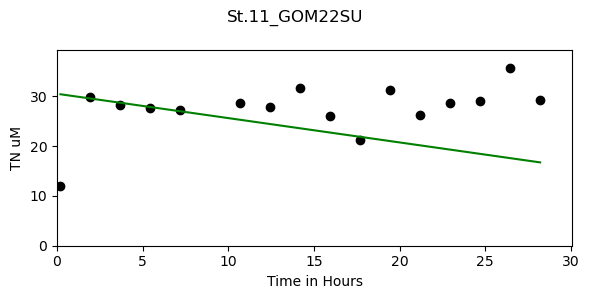

slope_tn_bc  rsquared_tn_bc  std_err_tn_bc  flux_time_tn_bc  \
code                                                                         
St.5B_GOM21FA     0.193375        0.602732       0.055505             12.0   
St.15_GOM21FA     0.281981        0.962846       0.055392             12.0   
St.MK_GOM21FA     0.149671        1.000000       0.000000              6.0   
St.14_GOM21FA     1.208409        0.779309       0.643059              5.0   
St.9_GOM21FA      0.851490        0.432481       0.487704              8.0   
St.7_GOM21FA      1.132966        0.940904       0.141969             10.0   
St.13_GOM21FA     1.179058        0.763007       0.657111             12.0   
St.12_GOM21FA    -0.969629        0.837921       0.301545             12.0   
St.7_GOM22SP      0.089518        0.046521       0.405263             10.0   
St.5B_GOM22SP    -0.012805        0.000177       0.963105              6.0   
St.9_GOM22SP      2.371190        0.959041       0.346502              7.0   
St.14_GOM22SP     0.719311        0.470428       0.341309             10.0   
St.16_GOM22SP     4.935584        0.984612       0.436297              4.0   
St.MK_GOM22SP    -0.322653        0.312777       0.276125              5.0   
St.15_GOM22SP     0.977487        0.828453       0.314524              9.0   
St.2_GOM22SP      0.106000        0.013189       0.529358              6.0   
St.4_GOM22SP      0.203571        0.997725       0.009721              3.0   
St.4_GOM22SU      0.243367        0.247196       0.300309              4.0   
St.5B_GOM22SU     0.303734        1.000000       0.000000              3.0   
St.MK_GOM22SU     0.850791        0.299436       0.491864              7.0   
St.7_GOM22SU      2.167347        1.000000       0.000000              3.0   
St.9_GOM22SU      0.687500        0.345652       0.945927              7.0   
St.15_GOM22SU     0.625699        0.992283       0.055178              8.0   
St.2_GOM22SU      2.193189        0.928950       0.303272              7.0   
St.13_GOM22SU     0.608546        0.237825       0.544706             10.0   
St.12_GOM22SU     0.035688        0.023374       0.115343             10.0   
St.16_GOM22SU     0.284029        0.523556       0.121172              8.0   
St.11_GOM22SU    -0.488426        0.884429       0.124847              8.0   

                  Camp    Stn   Hight_m  Hight_error        Lat        Lon  \
code                                                                         
St.5B_GOM21FA  GOM21FA  St.5B  0.116667     0.004714  28.806169 -91.335944   
St.15_GOM21FA  GOM21FA  St.15  0.140000     0.016330  28.950023 -88.846716   
St.MK_GOM21FA  GOM21FA  St.MK  0.217500     0.010897  28.913659 -90.328519   
St.14_GOM21FA  GOM21FA  St.14  0.158333     0.030641  28.727625 -89.620568   
St.9_GOM21FA   GOM21FA   St.9  0.115000     0.010801  28.782994 -89.599750   
St.7_GOM21FA   GOM21FA   St.7  0.170000     0.048477  28.910991 -89.872204   
St.13_GOM21FA  GOM21FA  St.13  0.133333     0.008498  28.524193 -89.610854   
St.12_GOM21FA  GOM21FA  St.12  0.145000     0.008165  28.594249 -88.903741   
St.7_GOM22SP   GOM22SP   St.7  0.146667     0.010274  28.917214 -89.859921   
St.5B_GOM22SP  GOM22SP  St.5B  0.168750     0.038467  28.808891 -91.338694   
St.9_GOM22SP   GOM22SP   St.9  0.162500     0.021651  28.787287 -89.607676   
St.14_GOM22SP  GOM22SP  St.14  0.140000     0.008165  28.726195 -89.613151   
St.16_GOM22SP  GOM22SP  St.16  0.180000     0.048477  28.914785 -89.545059   
St.MK_GOM22SP  GOM22SP  St.MK  0.136667     0.032998  28.902410 -90.309229   
St.15_GOM22SP  GOM22SP  St.15  0.103333     0.047842  28.944296 -88.860281   
St.2_GOM22SP   GOM22SP   St.2  0.088750     0.013405  28.899786 -89.605333   
St.4_GOM22SP   GOM22SP   St.4  0.180000     0.021213  28.798798 -90.706620   
St.4_GOM22SU   GOM22SU   St.4  0.042412     0.016330  28.793151 -90.697399   
St.5B_GOM22SU  GOM22SU  St.5B  0.045239     0.000000  28.797889 -91.322172   
St.MK_GOM22SU  GOM22SU  St.MK  0.053

In [30]:
Frames = []

def tn_flux_cal(code, time1, time2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    sub = df_tn_bc_plot.loc[df_tn_bc_plot['code'] == codes[code]]
    x = sub['Time']
    y = sub['TN_uM']
    axs.scatter(x, y, c="black")
    xx = sub.loc[(sub['Time'] < time1) & (sub['Time'] > time2), 'Time'].ravel()
    yy = sub.loc[(sub['Time'] < time1) & (sub['Time'] > time2), 'TN_uM'].ravel()
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='g')
        # Add the slope value to the plot
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
        dic = {'code':[codes[code]],
               'slope_tn_bc':[slope],
               'rsquared_tn_bc':[rsquared], 
               'std_err_tn_bc':[std_err], 
               'flux_time_tn_bc': [time1]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
    # Add subplot labels
    axs.set_xlabel('Time in Hours')
    axs.set_ylabel('TN uM')
    axs.set_xlim(0,df_doc_bc['Time'].max())
    axs.set_ylim(df_doc_bc['TN_uM'].min(),max(y)*1.1)
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
tn_flux_cal(0, 12, 0)
tn_flux_cal(1, 12, .5)
tn_flux_cal(2, 6, 1.5)
tn_flux_cal(3, 5, 0)
tn_flux_cal(4, 8, 0)
tn_flux_cal(5, 10, .5)
tn_flux_cal(6, 12, 3)
tn_flux_cal(7, 12, 0)
tn_flux_cal(8, 10, 0)
tn_flux_cal(9, 6, .5)
tn_flux_cal(10, 7, 1.5)
tn_flux_cal(11, 10, 0)
tn_flux_cal(12, 4, .5)
tn_flux_cal(13, 5, 0)
tn_flux_cal(14, 9, 0)
tn_flux_cal(15, 6, 0)
tn_flux_cal(16, 3, 0)
tn_flux_cal(17, 4, 0)
tn_flux_cal(18, 3, 0)
tn_flux_cal(19, 3, 0)
tn_flux_cal(20, 7, 0)
tn_flux_cal(21, 3, 0)
tn_flux_cal(22, 7, 3)
tn_flux_cal(23, 8, 0)
tn_flux_cal(24, 7, 0)
tn_flux_cal(25, 10, 0)
tn_flux_cal(26, 10, 0)
tn_flux_cal(27, 8, 0)
tn_flux_cal(28, 8, 1)

slopes_tn_bc = pd.concat(Frames, axis=0, ignore_index=False)

slopes_tn_bc = pd.concat([slopes_tn_bc, df_hights, df_lat_lon], axis=1, join='outer')
slopes_tn_bc = slopes_tn_bc.dropna(subset=['slope_tn_bc'])

slopes_tn_bc["bc_flux_tn"] = slopes_tn_bc['slope_tn_bc'] * slopes_tn_bc["Hight_m"] *24 
slopes_tn_bc["bc_flux_tn_error"] = slopes_tn_bc["std_err_tn_bc"] * slopes_tn_bc["Hight_m"]* 24

slopes_tn_bc 

In [31]:
#figure calculate Benthic chamber 

#Fe2 slops
#df_iron_bc_fe2_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe2_uM'] == 0) | (df_iron_bc['Fe2_uM'].isna())].index)
df_iron_bc_fe2_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe2_uM'] == np.nan) | (df_iron_bc['Fe2_uM'].isna())].index)
codes = df_iron_bc_fe2_cl['code'].unique()

print(codes)
len(codes)

['St.MK_GOM2021' 'St.5B_GOM2021' 'St.4_GOM2021' 'St.14_GOM2021'
 'St.9_GOM2021' 'St.13_GOM2021' 'St.2_GOM2021' 'St.15_GOM2021'
 'St.16_GOM2021' 'St.11_GOM2021' 'St.7_GOM2021' 'St.5B_GOM21FA'
 'St.MK_GOM21FA' 'St.7_GOM21FA' 'St.14_GOM21FA' 'St.9_GOM21FA'
 'St.15_GOM21FA' 'St.13_GOM21FA' 'St.16_GOM21FA' 'St.7_GOM22SP'
 'St.14_GOM22SP' 'St.16_GOM22SP' 'St.5B_GOM22SP' 'St.15_GOM22SP'
 'St.9_GOM22SP' 'St.2_GOM22SP' 'St.MK_GOM22SP' 'St.4_GOM22SU'
 'St.5B_GOM22SU' 'St.7_GOM22SU' 'St.9_GOM22SU' 'St.15_GOM22SU'
 'St.13_GOM22SU' 'St.2_GOM22SU' 'St.12_GOM22SU' 'St.16_GOM22SU'
 'St.11_GOM22SU' 'St.MK_GOM22SU']


38

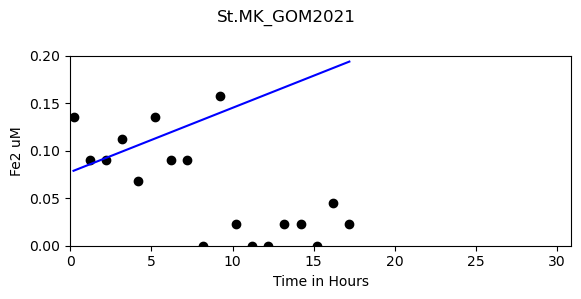

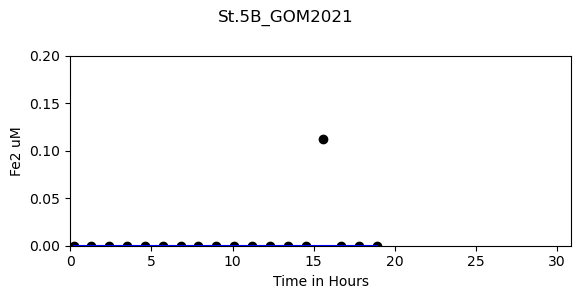

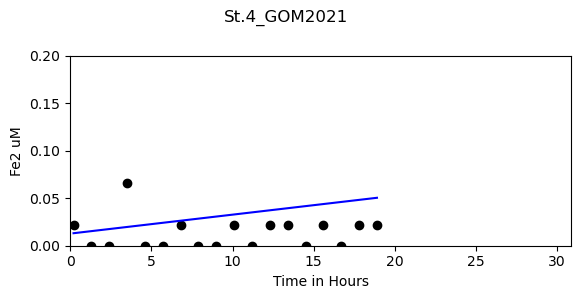

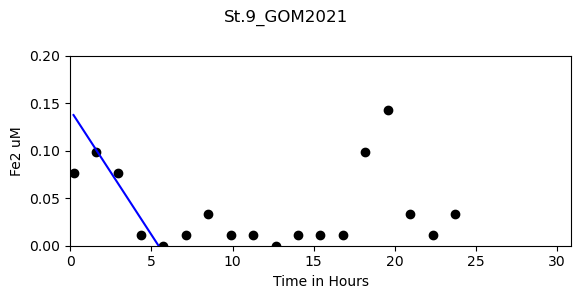

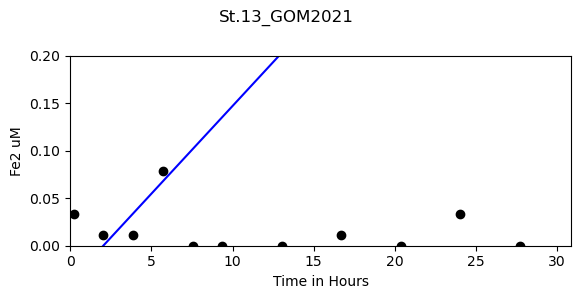

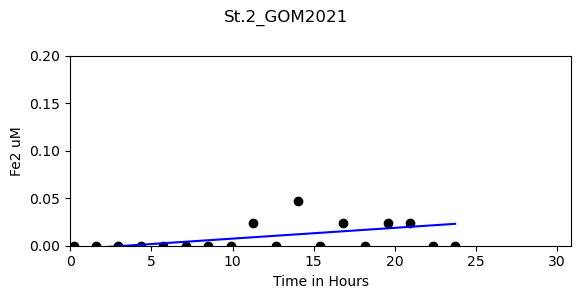

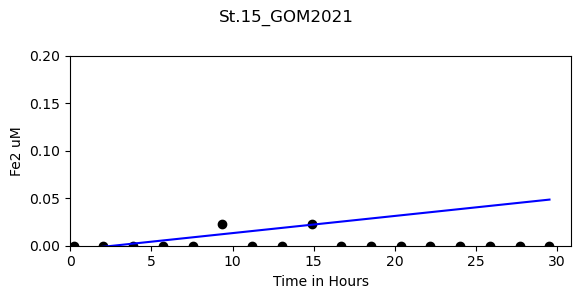

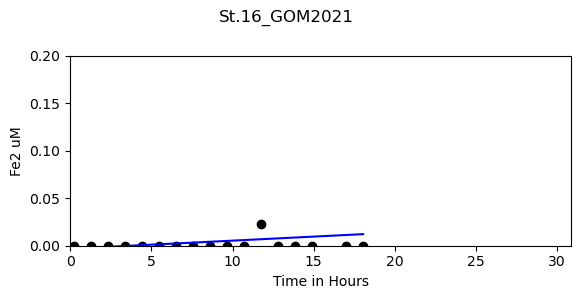

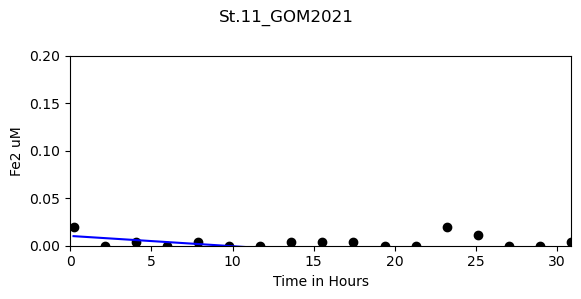

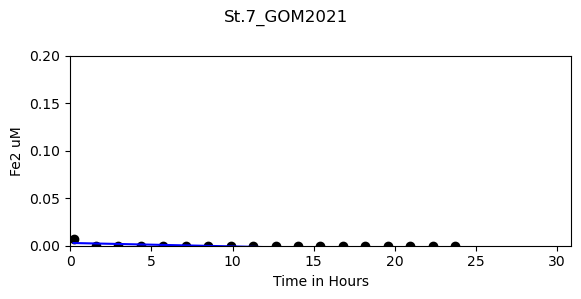

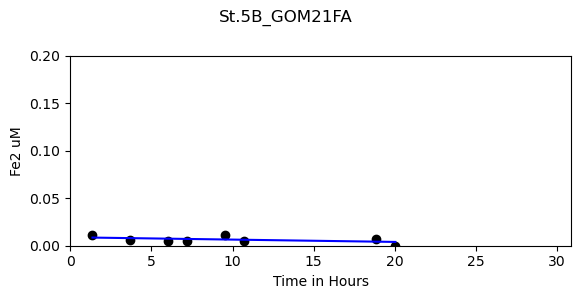

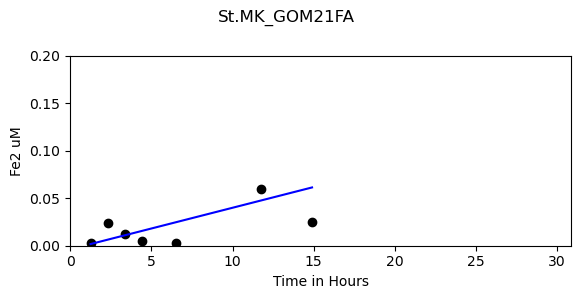

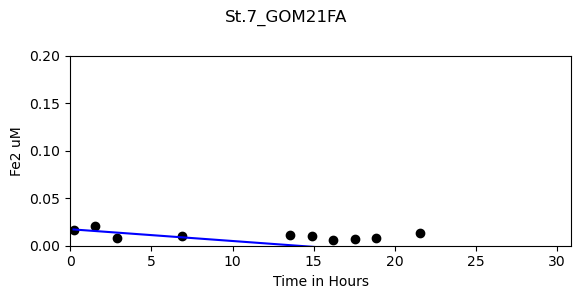

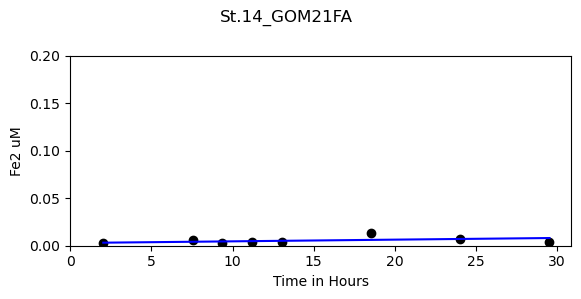

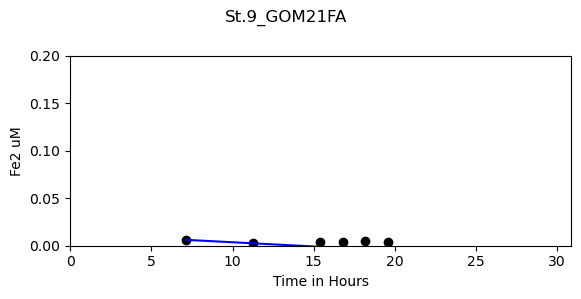

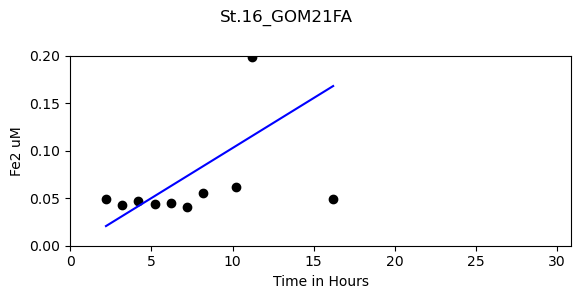

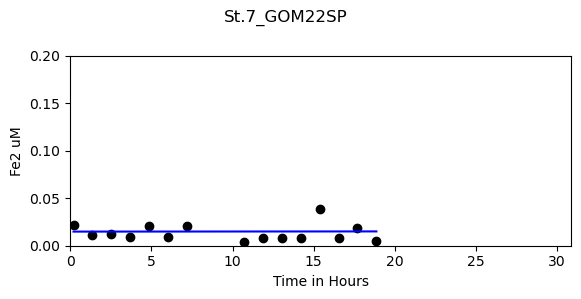

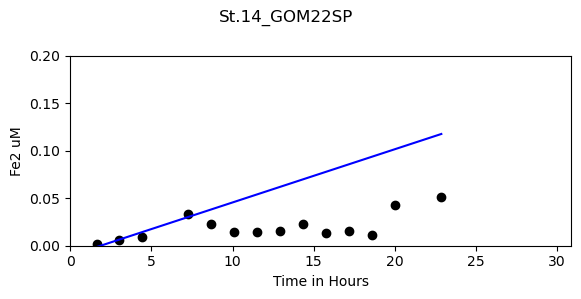

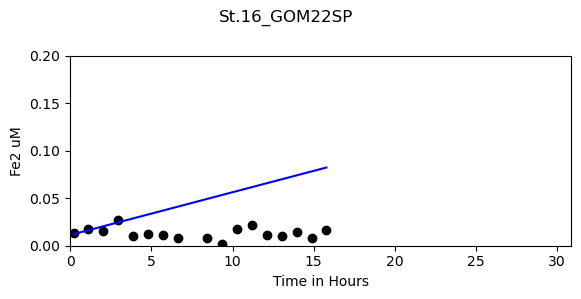

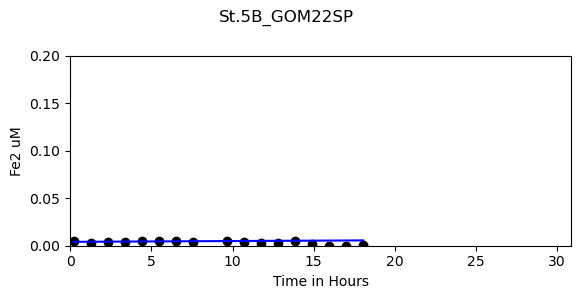

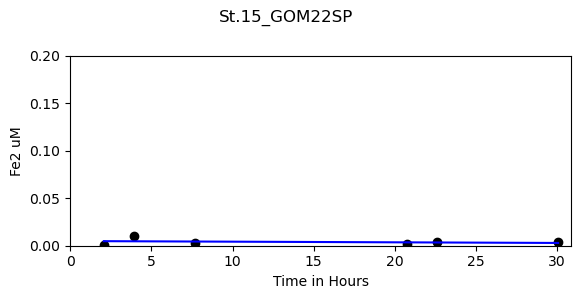

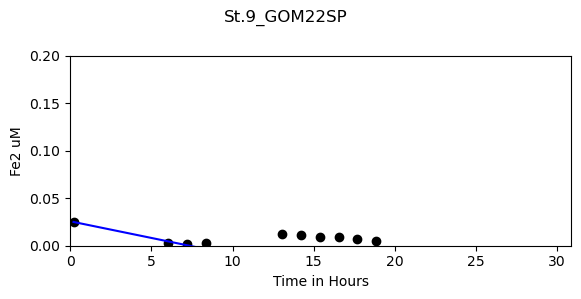

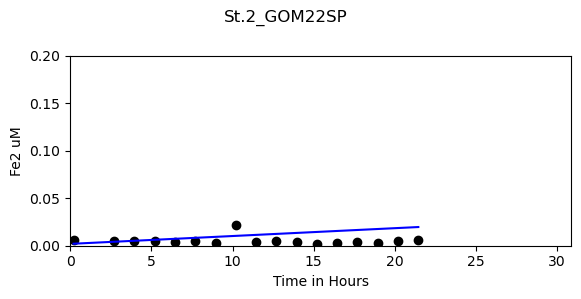

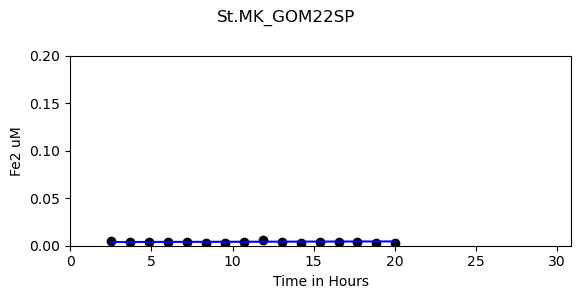

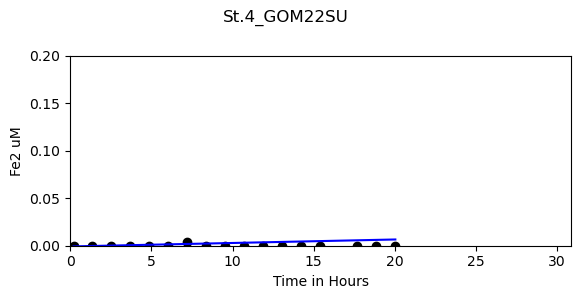

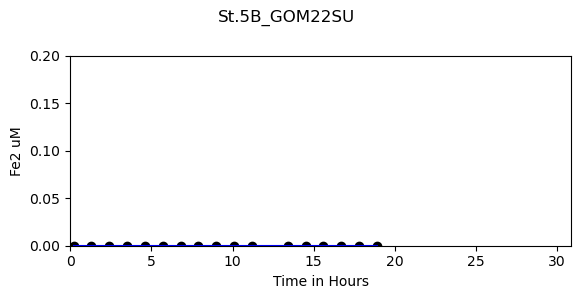

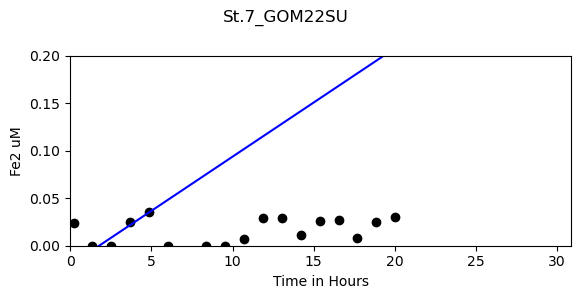

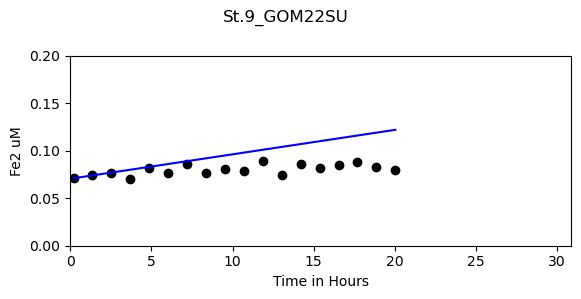

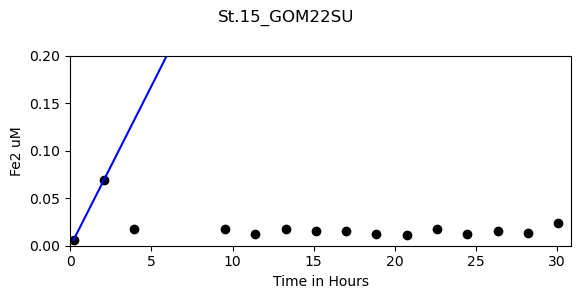

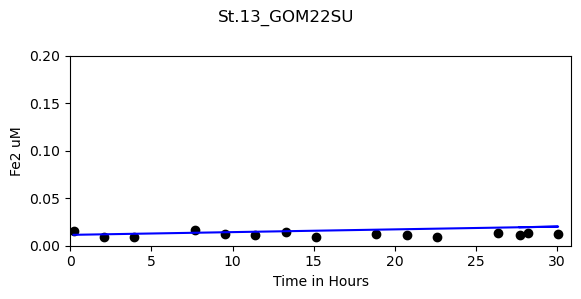

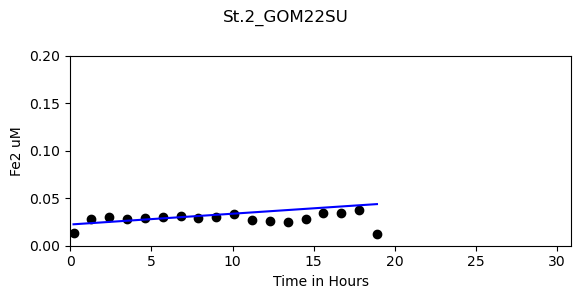

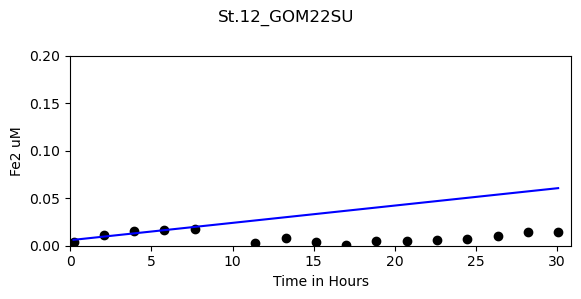

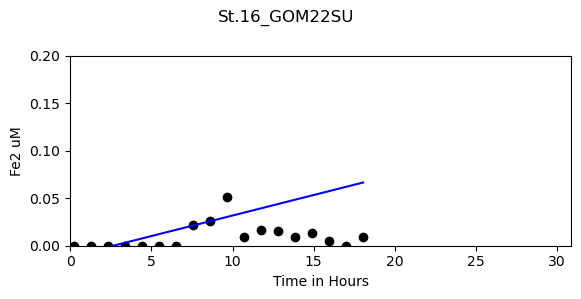

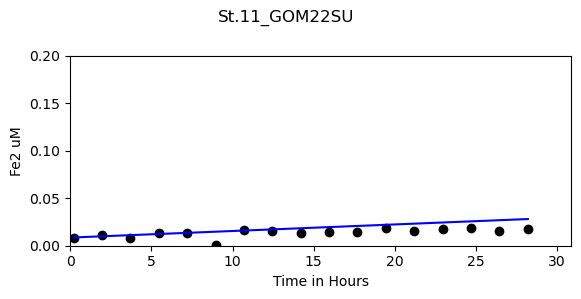

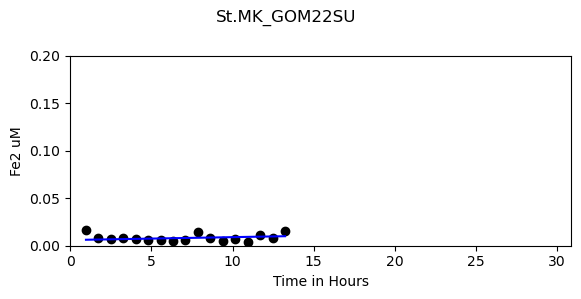

slope_fe2_bc  rsquared_fe2_bc  std_err_fe2_bc  \
code                                                           
St.MK_GOM2021      0.006761         0.173077        0.008532   
St.5B_GOM2021      0.000000         0.000000        0.000000   
St.4_GOM2021       0.001994         0.014706        0.009424   
St.9_GOM2021      -0.026252         0.926808        0.005216   
St.13_GOM2021      0.018459         0.749999        0.010658   
St.2_GOM2021       0.001136         0.300000        0.000656   
St.15_GOM2021      0.001806         0.428572        0.001043   
St.16_GOM2021      0.000849         0.230769        0.000490   
St.11_GOM2021     -0.001081         0.401786        0.000590   
St.7_GOM2021      -0.000362         0.300000        0.000209   
St.5B_GOM21FA     -0.000245         0.085374        0.000400   
St.MK_GOM21FA      0.004364         0.560794        0.001931   
St.7_GOM21FA      -0.001239         0.385138        0.001107   
St.14_GOM21FA      0.000178         0.192728        0.000365   
St.9_GOM21FA      -0.000888         1.000000        0.000000   
St.16_GOM21FA      0.010528         0.409848        0.004775   
St.7_GOM22SP       0.000011         0.000023        0.001043   
St.14_GOM22SP      0.005602         0.910731        0.001240   
St.16_GOM22SP      0.004498         0.699501        0.002085   
St.5B_GOM22SP      0.000084         0.072589        0.000123   
St.15_GOM22SP     -0.000067         0.001528        0.001712   
St.9_GOM22SP      -0.003504         0.977163        0.000536   
St.2_GOM22SP       0.000826         0.205609        0.000663   
St.MK_GOM22SP      0.000036         0.009926        0.000136   
St.4_GOM22SU       0.000367         0.375000        0.000212   
St.5B_GOM22SU      0.000000         0.000000        0.000000   
St.7_GOM22SU       0.011400         0.892708        0.002795   
St.9_GOM22SU       0.002571         1.000000        0.000000   
St.15_GOM22SU      0.033750         1.000000        0.000000   
St.13_GOM22SU      0.000289         0.055458        0.000844   
St.2_GOM22SU       0.001136         0.380754        0.000548   
St.12_GOM22SU      0.001821         0.889231        0.000371   
St.16_GOM22SU      0.004321         0.610445        0.001220   
St.11_GOM22SU      0.000691         0.415760        0.000580   
St.MK_GOM22SU      0.000304         0.058103        0.000463   

               flux_time_fe2_bc     Camp    Stn   Hight_m  Hight_error  \
code                                                                     
St.MK_GOM2021               6.0  GOM2021  St.MK  0.201250     0.022465   
St.5B_GOM2021              12.0  GOM2021  St.5B  0.158750     0.005449   
St.4_GOM2021                5.0  GOM2021   St.4  0.163500     0.021372   
St.9_GOM2021                6.0  GOM2021   St.9  0.071250     0.023816   
St.13_GOM2021               7.0  GOM2021  St.13  0.070000     0.000000   
St.2_GOM2021               12.0  GOM2021   St.2  0.115000     0.017678   
St.15_GOM2021              10.0  GOM2021  St.15  0.118333     0.015456   
St.16_GOM2021              12.0  GOM2021  St.16  0.126667     0.030641   
St.11_GOM2021              12.0  GOM2021  St.11  0.176667     0.012472   
St.7_GOM2021               12.0  GOM2021   St.7  0.067500     0.022500   
St.5B_GOM21FA              12.0  GOM21FA  St.5B  0.116667     0.004714   
St.MK_GOM21FA              12.0  GOM21FA  St.MK  0.217500     0.010897   
St.7_GOM21FA               10.0  GOM21FA   St.7  0.170000     0.048477   
St.14_GOM21FA              10.0  GOM21FA  St.14  0.158333     0.030641   
St.9_GOM21FA               12.0  GOM21FA   St.9  0.115000     0.010801   
St.16_GOM21FA              12.0  GOM21FA  St.16  0.133333     0.030641   
St.7_GOM22SP                8.0  GOM22SP   St.7  0.146667     0.010274   
St.14_GOM22SP               8.0  GOM22SP  St.14  0.140000     0.008165   
St.16_GOM22SP               3.0  GOM22SP  St.16  0.180000     0.048477   
St.5B_GOM22SP               8.0  GOM22SP  St.5B  0.168750     0.038467   
St.15_GOM22SP     

In [32]:
Frames = []

def fe2_flux_cal(code, time1, time2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    sub = df_iron_bc_fe2_cl.loc[df_iron_bc_fe2_cl['code'] == codes[code]]
    x = sub['Fe2_Time']
    y = sub['Fe2_uM']
    axs.scatter(x, y, c="black")
    xx = sub.loc[(sub['Fe2_Time'] < time1) & (sub['Fe2_Time'] > time2), 'Fe2_Time'].ravel()
    yy = sub.loc[(sub['Fe2_Time'] < time1) & (sub['Fe2_Time'] > time2), 'Fe2_uM'].ravel()
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='b')
        # Add the slope value to the plot
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
        dic = {'code':[codes[code]],
               'slope_fe2_bc':[slope],
               'rsquared_fe2_bc':[rsquared], 
               'std_err_fe2_bc':[std_err], 
               'flux_time_fe2_bc': [time1]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
    # Add subplot labels
    axs.set_xlabel('Time in Hours')
    axs.set_ylabel('Fe2 uM')
    axs.set_xlim(0,df_iron_bc_fe2_cl['Fe2_Time'].max())
    #axs.set_ylim(df_iron_bc_fe2_cl['Fe2_uM'].min(),df_iron_bc_fe2_cl['Fe2_uM'].max())
    axs.set_ylim(0,.2)
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
fe2_flux_cal(0, 6, .5)
fe2_flux_cal(1, 12, 0)
fe2_flux_cal(2, 5, 0)
#fe2_flux_cal(3, 2, 0)
fe2_flux_cal(4, 6, 1)
fe2_flux_cal(5, 7, 1)
fe2_flux_cal(6, 12, 0)
fe2_flux_cal(7, 10, 0)
fe2_flux_cal(8, 12, 0)
fe2_flux_cal(9, 12, 0)
fe2_flux_cal(10, 12, 0)
fe2_flux_cal(11, 12, 0)
fe2_flux_cal(12, 12, 0)
fe2_flux_cal(13, 10, 0)
fe2_flux_cal(14, 10, 0)
fe2_flux_cal(15, 12, 0)
fe2_flux_cal(18, 12, 0)
fe2_flux_cal(19, 8, 0)
fe2_flux_cal(20, 8, 0)
fe2_flux_cal(21, 3, 0)
fe2_flux_cal(22, 8, 0)
fe2_flux_cal(23, 8, 0)
fe2_flux_cal(24, 8, 0)
fe2_flux_cal(25, 11, 0)
fe2_flux_cal(26, 12, 0)
fe2_flux_cal(27, 8, 0)
fe2_flux_cal(28, 12, 0)
fe2_flux_cal(29, 5, 0.5)
fe2_flux_cal(30, 3, 0)
fe2_flux_cal(31, 3, 0)
fe2_flux_cal(32, 8, 0)
fe2_flux_cal(33, 10, 0)
fe2_flux_cal(34, 8, 0)
fe2_flux_cal(35, 10, 0)
fe2_flux_cal(36, 6, 0)
fe2_flux_cal(37, 8, 1)

slopes_fe2_bc = pd.concat(Frames, axis=0, ignore_index=False)

slopes_fe2_bc = pd.concat([slopes_fe2_bc, df_hights, df_lat_lon], axis=1, join='outer')
slopes_fe2_bc = slopes_fe2_bc.dropna(subset=['slope_fe2_bc'])

slopes_fe2_bc["bc_flux_fe2"] = slopes_fe2_bc["slope_fe2_bc"] * slopes_fe2_bc["Hight_m"] * 24 
slopes_fe2_bc["bc_flux_fe2_error"] = slopes_fe2_bc["std_err_fe2_bc"] * slopes_fe2_bc["Hight_m"] * 24 

slopes_fe2_bc  

In [33]:
#figure calculate Benthic chamber 

#Fe3 slops
#df_iron_bc_fe3_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe3_uM'] == 0) | (df_iron_bc['Fe3_uM'].isna())].index)
df_iron_bc_fe3_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe3_uM'] == np.nan) | (df_iron_bc['Fe3_uM'].isna())].index)
codes = df_iron_bc_fe3_cl['code'].unique()

print(codes)
len(codes)

['St.MK_GOM2021' 'St.5B_GOM2021' 'St.4_GOM2021' 'St.14_GOM2021'
 'St.9_GOM2021' 'St.13_GOM2021' 'St.2_GOM2021' 'St.15_GOM2021'
 'St.16_GOM2021' 'St.11_GOM2021' 'St.7_GOM2021' 'St.7_GOM21FA'
 'St.13_GOM21FA' 'St.7_GOM22SP' 'St.16_GOM22SP' 'St.15_GOM22SP'
 'St.9_GOM22SP' 'St.2_GOM22SP' 'St.4_GOM22SU' 'St.5B_GOM22SU'
 'St.7_GOM22SU' 'St.9_GOM22SU' 'St.15_GOM22SU' 'St.13_GOM22SU'
 'St.2_GOM22SU' 'St.12_GOM22SU' 'St.16_GOM22SU' 'St.11_GOM22SU'
 'St.MK_GOM22SU']


29

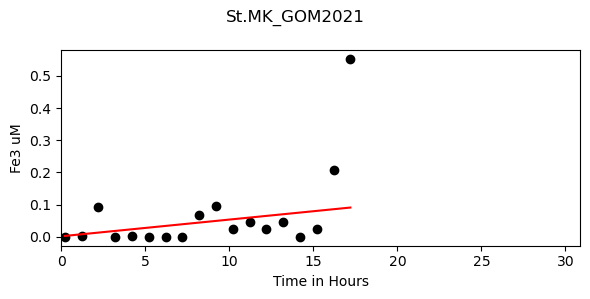

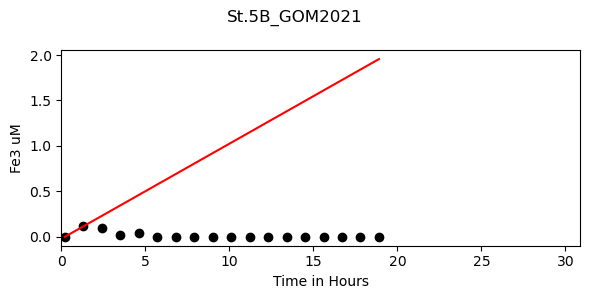

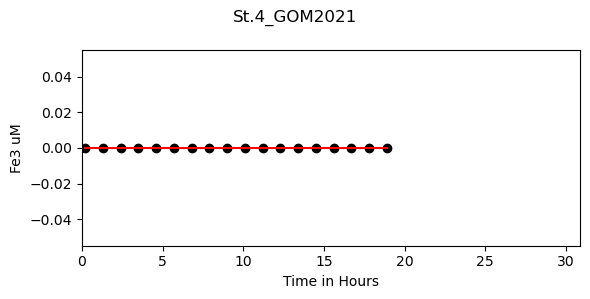

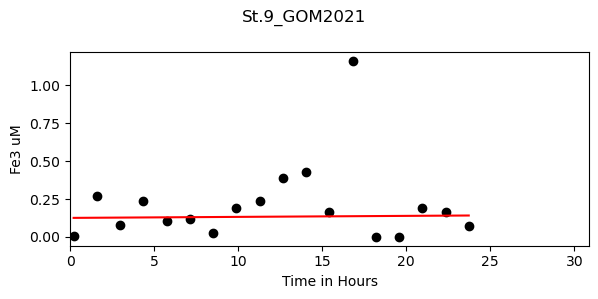

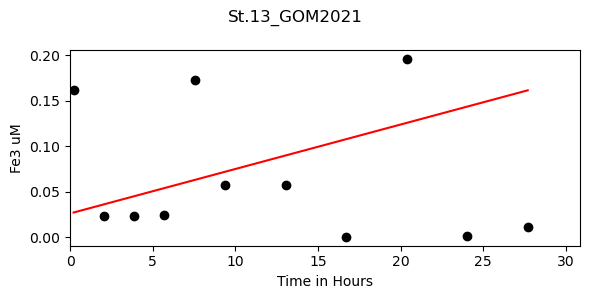

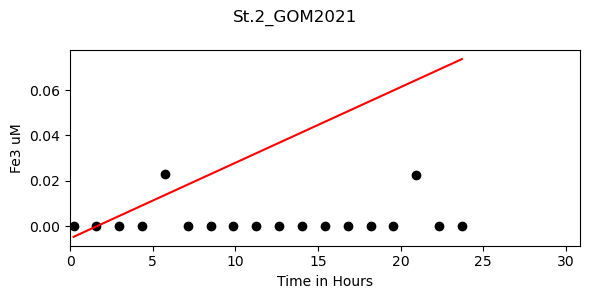

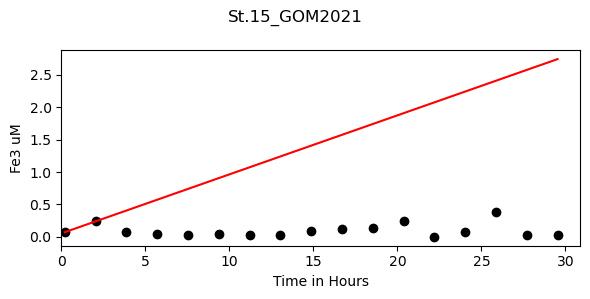

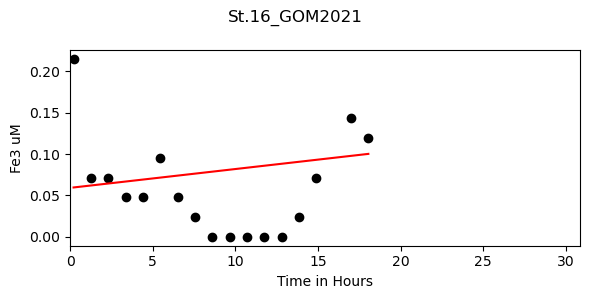

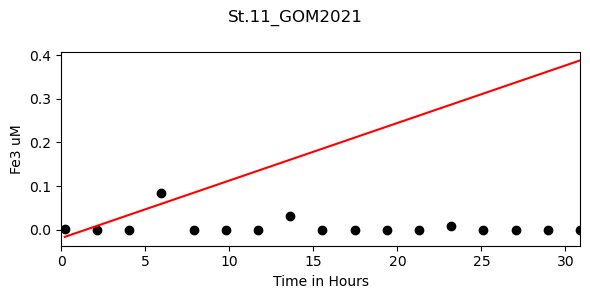

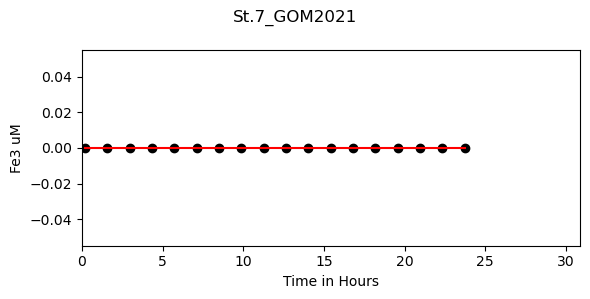

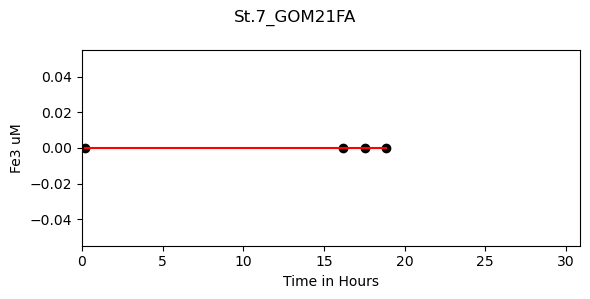

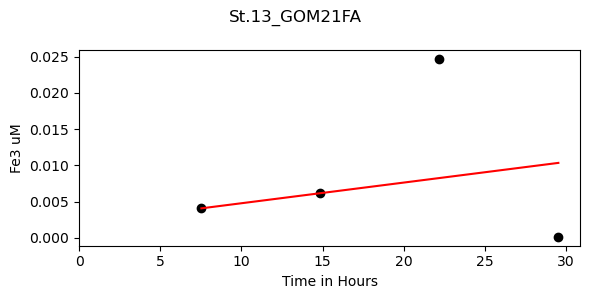

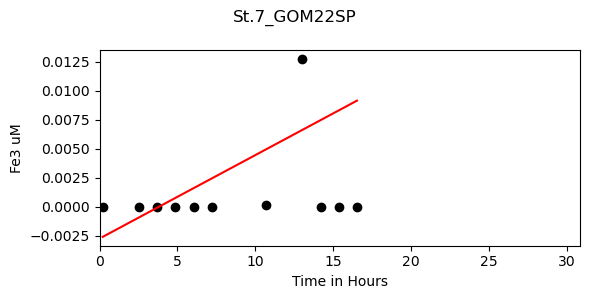

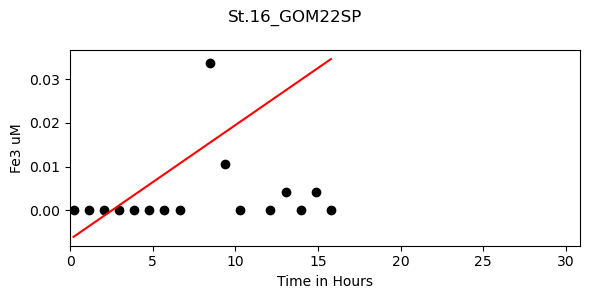

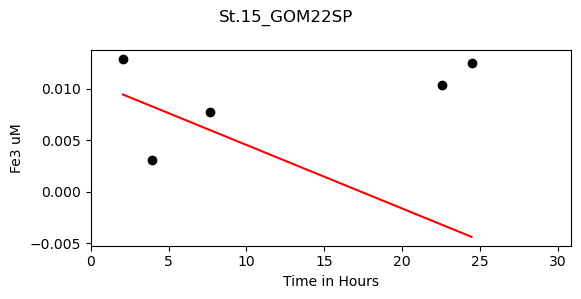

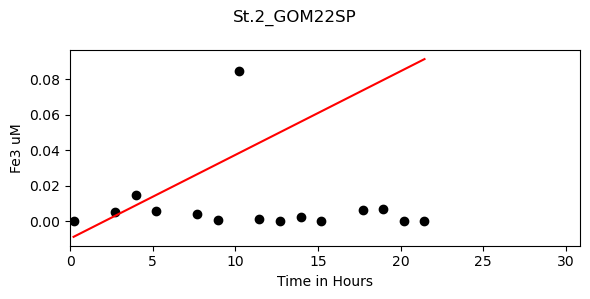

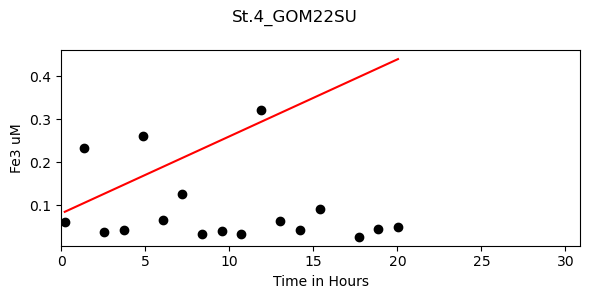

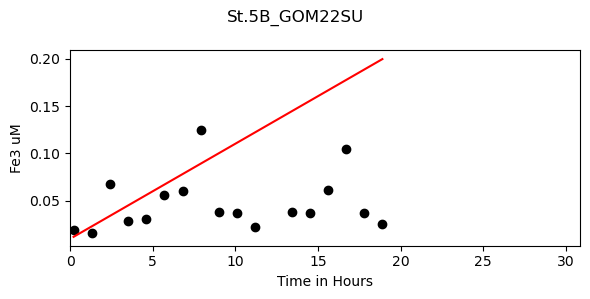

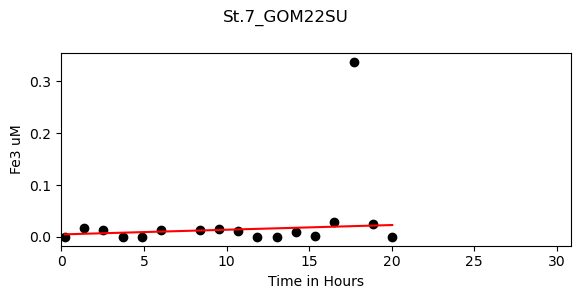

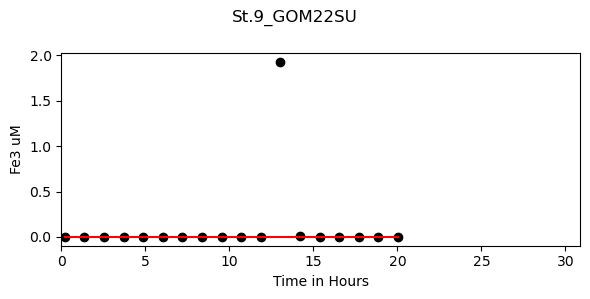

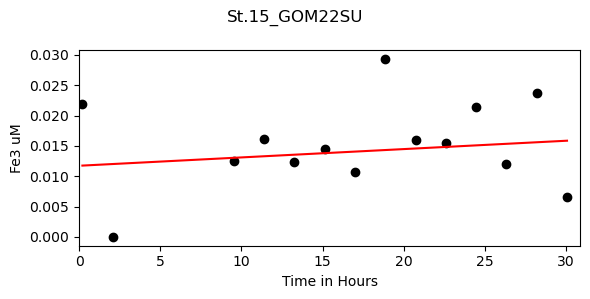

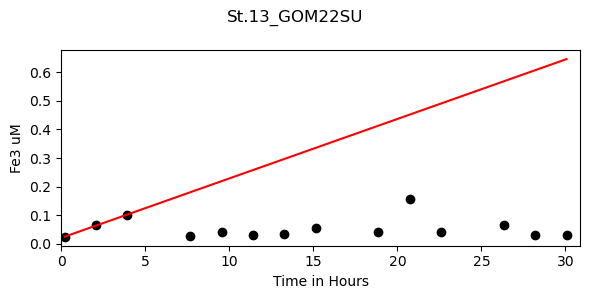

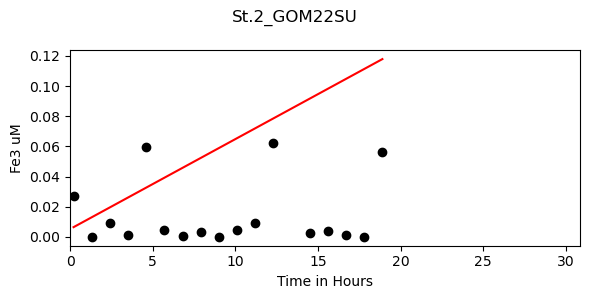

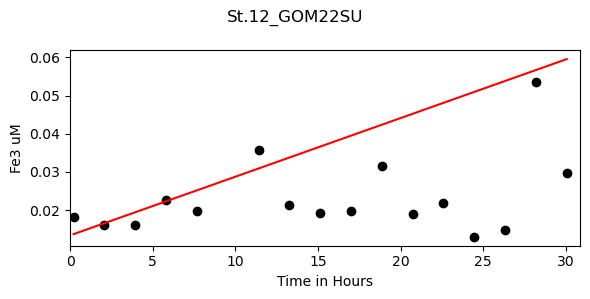

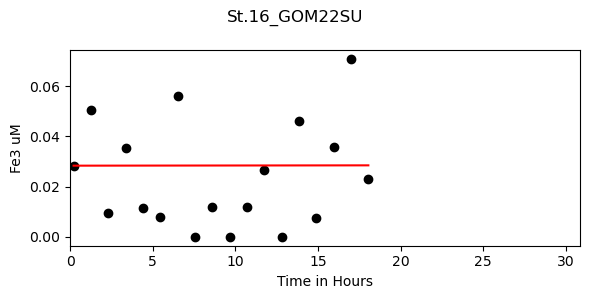

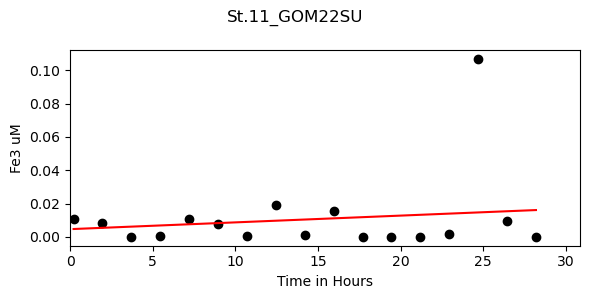

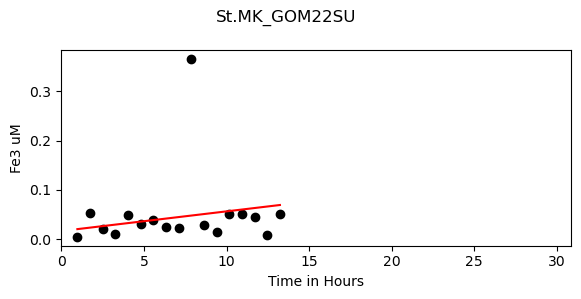

slope_fe3_bc  rsquared_fe3_bc  std_err_fe3_bc  \
code                                                           
St.MK_GOM2021      0.005192     1.405463e-01        0.004540   
St.5B_GOM2021      0.104563     1.000000e+00        0.000000   
St.4_GOM2021       0.000000     0.000000e+00        0.000000   
St.9_GOM2021       0.000665     5.547594e-04        0.011518   
St.13_GOM2021      0.004883     1.123973e-01        0.006861   
St.2_GOM2021       0.003326     4.999993e-01        0.001920   
St.15_GOM2021      0.091160     1.000000e+00        0.000000   
St.16_GOM2021      0.002274     3.571429e-02        0.006822   
St.11_GOM2021      0.013174     5.912805e-01        0.007745   
St.7_GOM2021       0.000000     0.000000e+00        0.000000   
St.7_GOM21FA       0.000000     0.000000e+00        0.000000   
St.13_GOM21FA      0.000285     1.000000e+00        0.000000   
St.7_GOM22SP       0.000718     4.568457e-01        0.000320   
St.16_GOM22SP      0.002613     3.903226e-01        0.001234   
St.15_GOM22SP     -0.000617     1.300031e-01        0.001595   
St.2_GOM22SP       0.004725     3.072738e-01        0.003172   
St.4_GOM22SU       0.017914     8.970510e-02        0.032947   
St.5B_GOM22SU      0.010054     5.678996e-01        0.003580   
St.7_GOM22SU       0.000904     1.528963e-01        0.000869   
St.9_GOM22SU       0.000000     0.000000e+00        0.000000   
St.15_GOM22SU      0.000137     1.349744e-02        0.000587   
St.13_GOM22SU      0.020826     9.991748e-01        0.000598   
St.2_GOM22SU       0.005958     1.736387e-01        0.007504   
St.12_GOM22SU      0.001535     6.960830e-01        0.000507   
St.16_GOM22SU      0.000007     6.610714e-07        0.003929   
St.11_GOM22SU      0.000406     6.792465e-02        0.000614   
St.MK_GOM22SU      0.003977     8.172896e-02        0.006665   

               flux_time_fe3_bc     Camp    Stn   Hight_m  Hight_error  \
code                                                                     
St.MK_GOM2021              10.0  GOM2021  St.MK  0.201250     0.022465   
St.5B_GOM2021               2.0  GOM2021  St.5B  0.158750     0.005449   
St.4_GOM2021               12.0  GOM2021   St.4  0.163500     0.021372   
St.9_GOM2021               10.0  GOM2021   St.9  0.071250     0.023816   
St.13_GOM2021              15.0  GOM2021  St.13  0.070000     0.000000   
St.2_GOM2021                6.0  GOM2021   St.2  0.115000     0.017678   
St.15_GOM2021               3.0  GOM2021  St.15  0.118333     0.015456   
St.16_GOM2021               6.0  GOM2021  St.16  0.126667     0.030641   
St.11_GOM2021               6.0  GOM2021  St.11  0.176667     0.012472   
St.7_GOM2021                6.0  GOM2021   St.7  0.067500     0.022500   
St.7_GOM21FA               20.0  GOM21FA   St.7  0.170000     0.048477   
St.13_GOM21FA              15.0  GOM21FA  St.13  0.133333     0.008498   
St.7_GOM22SP               14.0  GOM22SP   St.7  0.146667     0.010274   
St.16_GOM22SP               9.0  GOM22SP  St.16  0.180000     0.048477   
St.15_GOM22SP               8.0  GOM22SP  St.15  0.103333     0.047842   
St.2_GOM22SP               11.0  GOM22SP   St.2  0.088750     0.013405   
St.4_GOM22SU                5.0  GOM22SU   St.4  0.042412     0.016330   
St.5B_GOM22SU               8.0  GOM22SU  St.5B  0.045239     0.000000   
St.7_GOM22SU               10.0  GOM22SU   St.7  0.040527     0.036591   
St.9_GOM22SU               10.0  GOM22SU   St.9  0.030536     0.013019   
St.15_GOM22SU              16.0  GOM22SU  St.15  0.034118     0.014974   
St.13_GOM22SU               5.0  GOM22SU  St.13  0.030159     0.016499   
St.2_GOM22SU                5.0  GOM22SU   St.2  0.027921     0.030491   
St.12_GOM22SU              12.0  GOM22SU  St.12  0.044296     0.008498   
St.16_GOM22SU               7.0  GOM22SU  St.16  0.028746     0.030912   
St.11_GOM22SU              13.0  GOM22SU  St.11  0.038170     0.012247   
St.MK_GOM22SU               5.0  GOM22SU  St.MK  0.053721     0.027386   

           

In [34]:
Frames = []

def fe3_flux_cal(code, time1, time2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    sub = df_iron_bc_fe3_cl.loc[df_iron_bc_fe2_cl['code'] == codes[code]]
    x = sub['FeT_Time']
    y = sub['Fe3_uM']
    axs.scatter(x, y, c="black")
    xx = sub.loc[(sub['FeT_Time'] < time1) & (sub['FeT_Time'] > time2), 'FeT_Time'].ravel()
    yy = sub.loc[(sub['FeT_Time'] < time1) & (sub['FeT_Time'] > time2), 'Fe3_uM'].ravel()
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='r')
        # Add the slope value to the plot
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
        dic = {'code':[codes[code]],
               'slope_fe3_bc':[slope],
               'rsquared_fe3_bc':[rsquared], 
               'std_err_fe3_bc':[std_err], 
               'flux_time_fe3_bc': [time1]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
    # Add subplot labels
    axs.set_xlabel('Time in Hours')
    axs.set_ylabel('Fe3 uM')
    axs.set_xlim(0,df_iron_bc_fe3_cl['FeT_Time'].max())
    #axs.set_ylim(df_iron_bc_fe3_cl['Fe3_uM'].min(),df_iron_bc_fe3_cl['Fe3_uM'].max())
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
fe3_flux_cal(0, 10, 0)
fe3_flux_cal(1, 2, 0)
fe3_flux_cal(2, 12, 0)
fe3_flux_cal(4, 10, 0)
fe3_flux_cal(5, 15, 1)
fe3_flux_cal(6, 6, 0)
fe3_flux_cal(7, 3, 0)
fe3_flux_cal(8, 6, 1)
fe3_flux_cal(9, 6, 0)
fe3_flux_cal(10, 6, 0)
fe3_flux_cal(11, 20, 0)
fe3_flux_cal(12, 15, 0)
fe3_flux_cal(13, 14, 0)
fe3_flux_cal(14, 9, 0)
fe3_flux_cal(15, 8, 0)
fe3_flux_cal(17, 11, 0)
fe3_flux_cal(18, 5, 0)
fe3_flux_cal(19, 8, 0)
fe3_flux_cal(20, 10, 0)
fe3_flux_cal(21, 10, 0)
fe3_flux_cal(22, 16, 0)
fe3_flux_cal(23, 5, 0)
fe3_flux_cal(24, 5, 0)
fe3_flux_cal(25, 12, 0)
fe3_flux_cal(26, 7, 0)
fe3_flux_cal(27, 13, 0)
fe3_flux_cal(28, 5, 0)

slopes_fe3_bc = pd.concat(Frames, axis=0, ignore_index=False)

slopes_fe3_bc = pd.concat([slopes_fe3_bc, df_hights, df_lat_lon], axis=1, join='outer')
slopes_fe3_bc = slopes_fe3_bc.dropna(subset=['slope_fe3_bc'])

slopes_fe3_bc["bc_flux_fe3"] = slopes_fe3_bc["slope_fe3_bc"] * slopes_fe3_bc["Hight_m"]* 24 
slopes_fe3_bc["bc_flux_fe3_error"] = slopes_fe3_bc["std_err_fe3_bc"] * slopes_fe3_bc["Hight_m"]* 24 

slopes_fe3_bc 

In [35]:
#figure calculate Benthic chamber 

#CDOM slops
df_cdom_bc_cl = df_cdom_bc.drop(df_cdom_bc[(df_cdom_bc['a350'] <= 0) | (df_cdom_bc['a350'].isna())].index)
codes = df_cdom_bc_cl['code'].unique()
print(codes)
len(codes)


area_c = np.pi*((30/100)**2)

['St.13_GOM2021' 'St.14_GOM2021' 'St.15_GOM2021' 'St.16_GOM2021'
 'St.2_GOM2021' 'St.5B_GOM2021' 'St.9_GOM2021' 'St.MK_GOM2021'
 'St.11_GOM21FA' 'St.12_GOM21FA' 'St.13_GOM21FA' 'St.14_GOM21FA'
 'St.15_GOM21FA' 'St.16_GOM21FA' 'St.5B_GOM21FA' 'St.7_GOM21FA'
 'St.9_GOM21FA' 'St.MK_GOM21FA' 'St.13_GOM22SP' 'St.14_GOM22SP'
 'St.15_GOM22SP' 'St.16_GOM22SP' 'St.2_GOM22SP' 'St.4_GOM22SP'
 'St.5B_GOM22SP' 'St.7_GOM22SP' 'St.9_GOM22SP' 'St.MK_GOM22SU'
 'St.11_GOM22SU' 'St.12_GOM22SU' 'St.13_GOM22SU' 'St.14_GOM22SU'
 'St.15_GOM22SU' 'St.16_GOM22SU' 'St.2_GOM22SU' 'St.4_GOM22SU'
 'St.5B_GOM22SU' 'St.7_GOM22SU' 'St.9_GOM22SU']


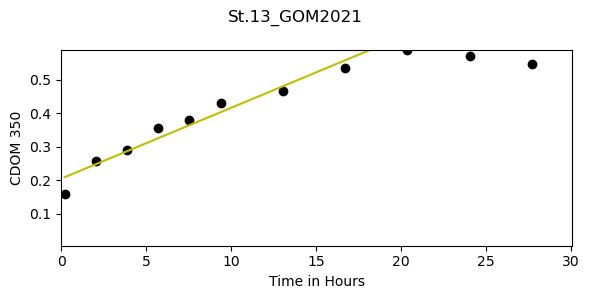

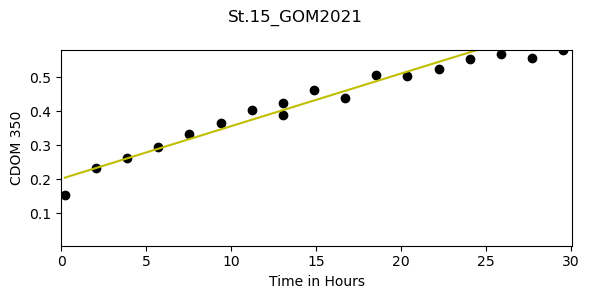

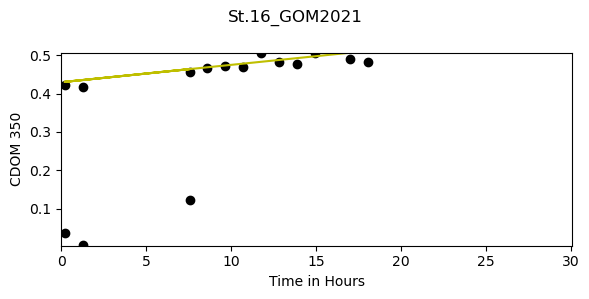

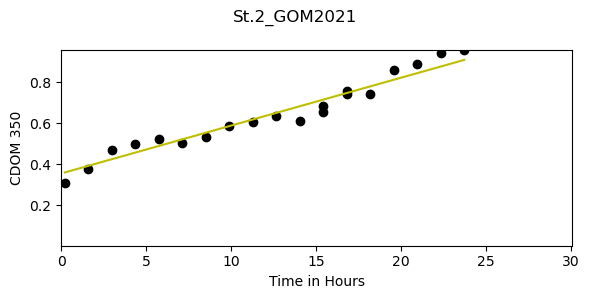

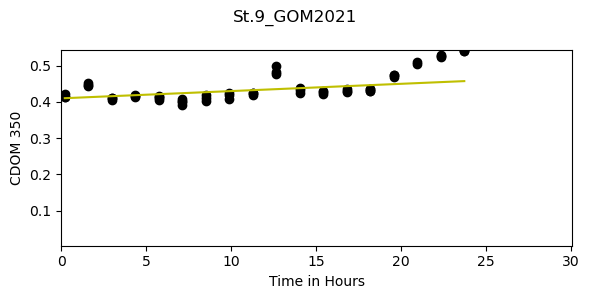

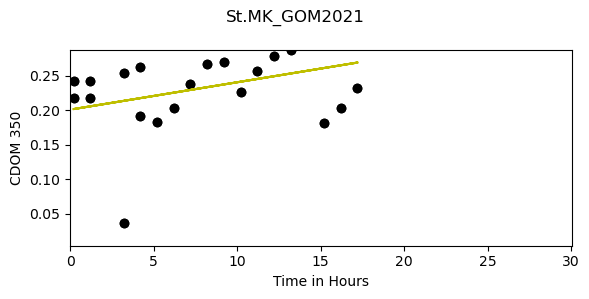

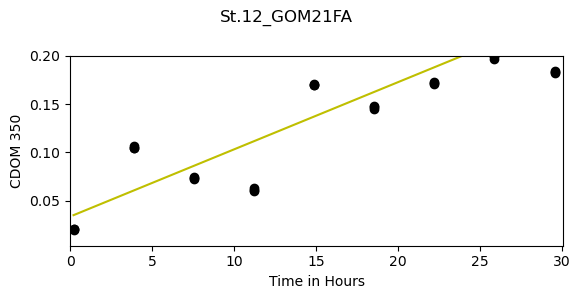

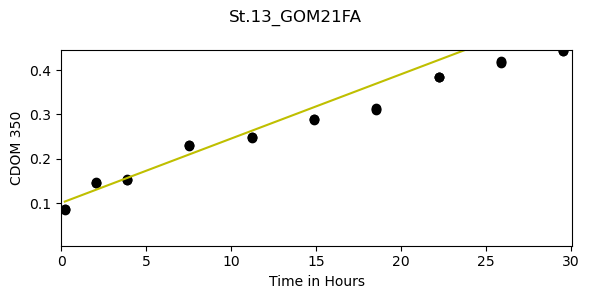

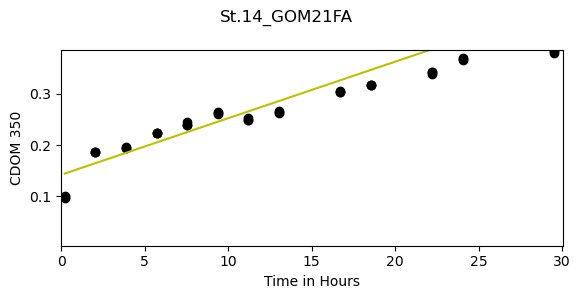

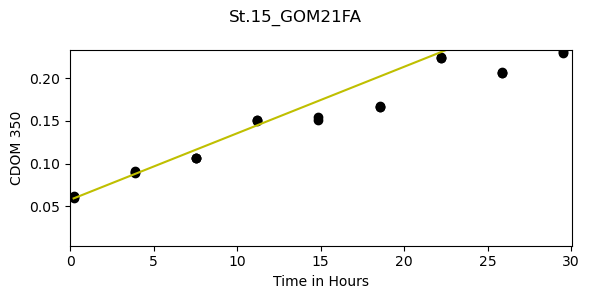

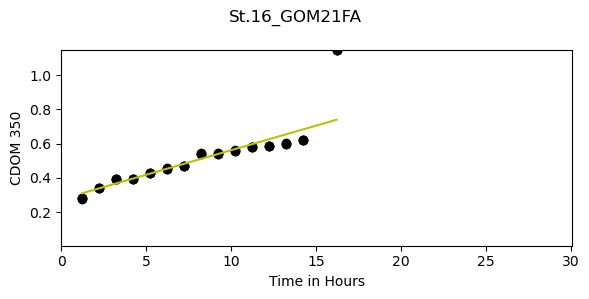

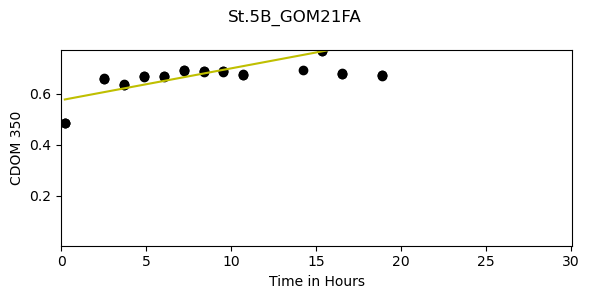

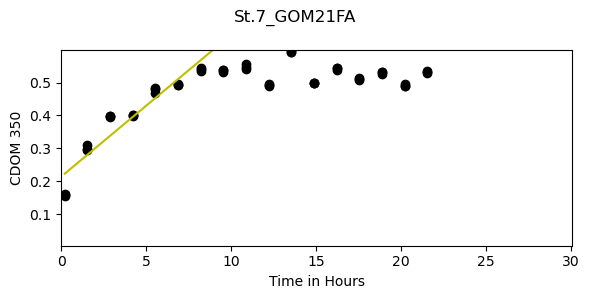

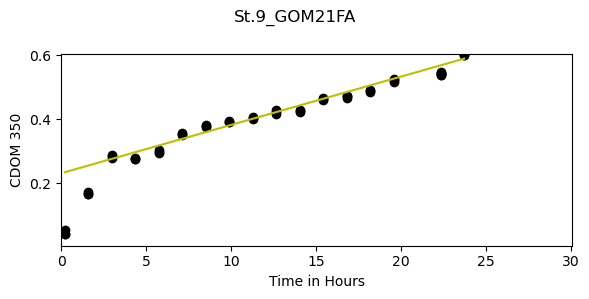

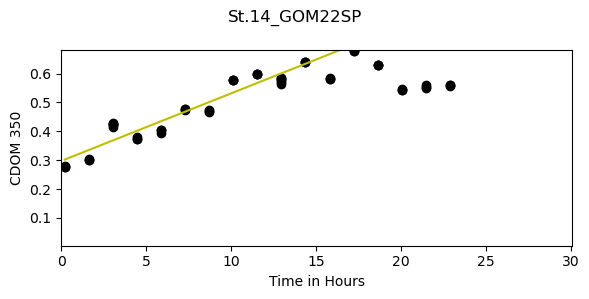

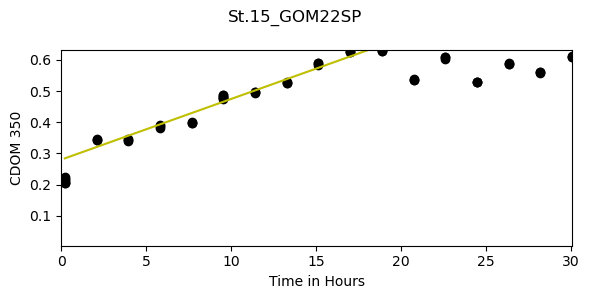

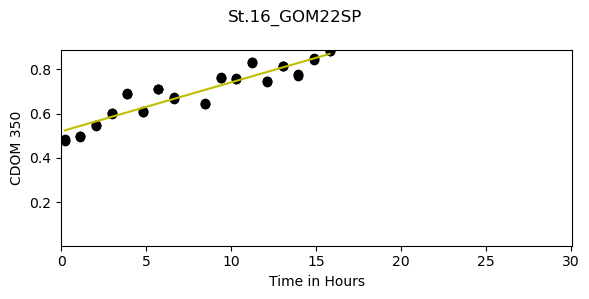

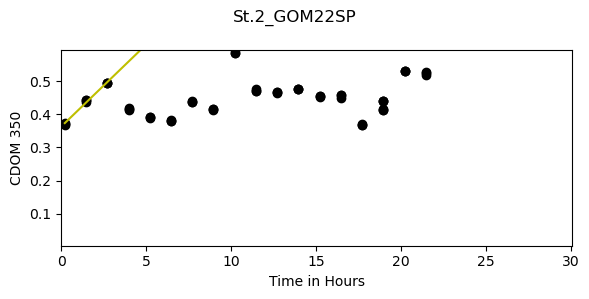

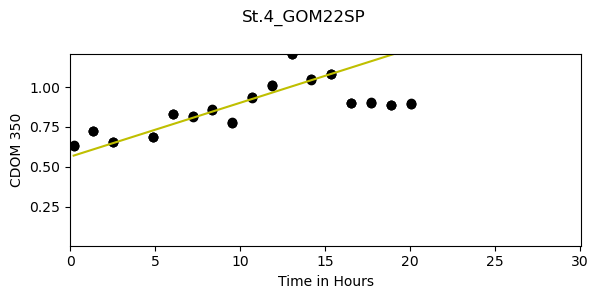

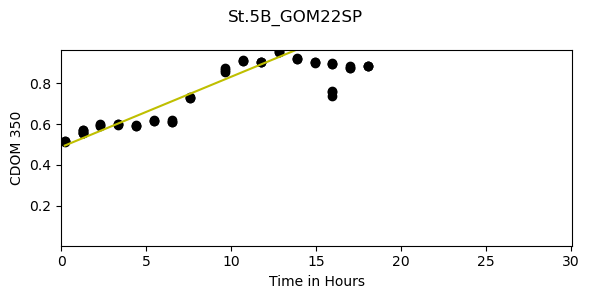

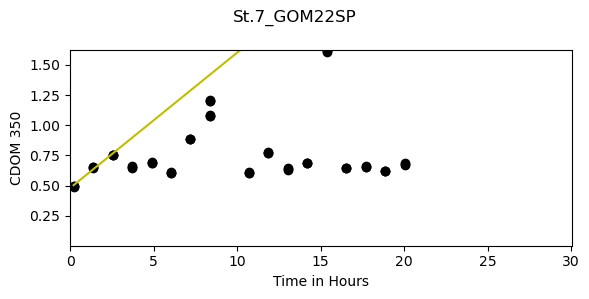

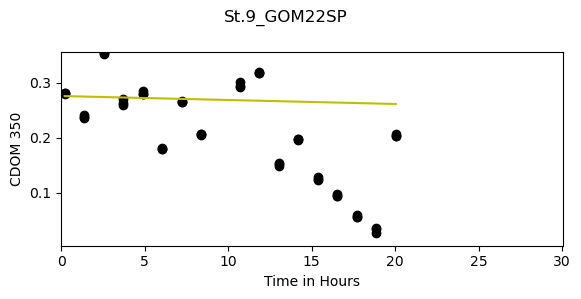

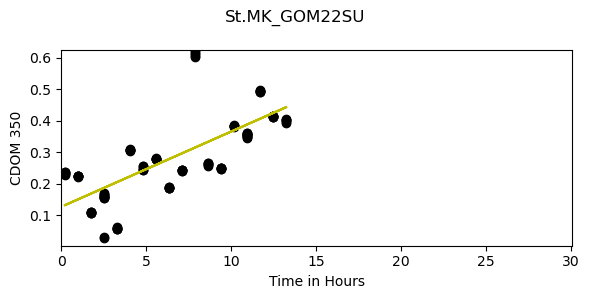

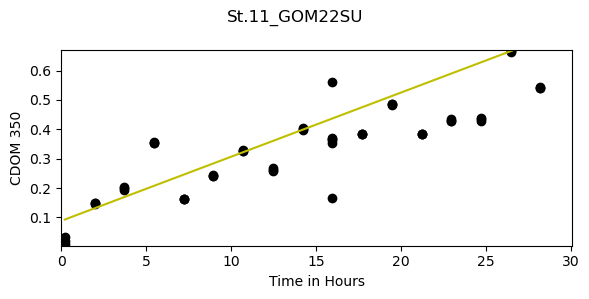

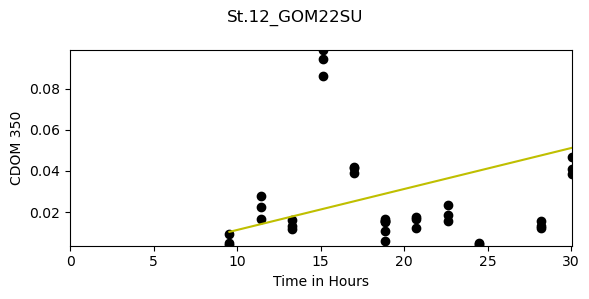

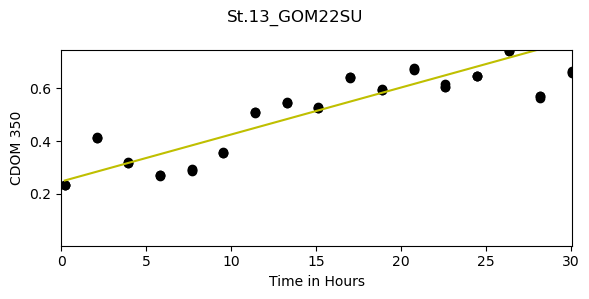

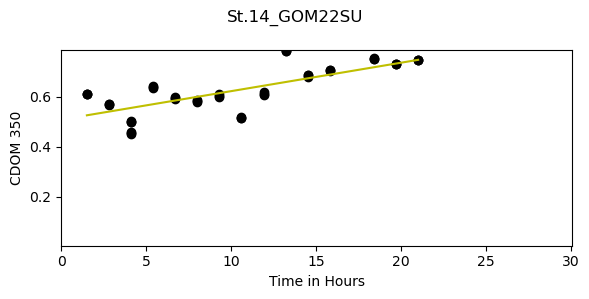

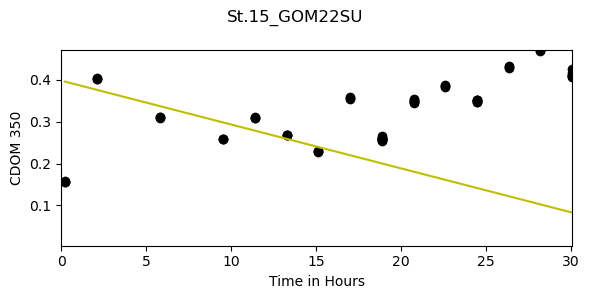

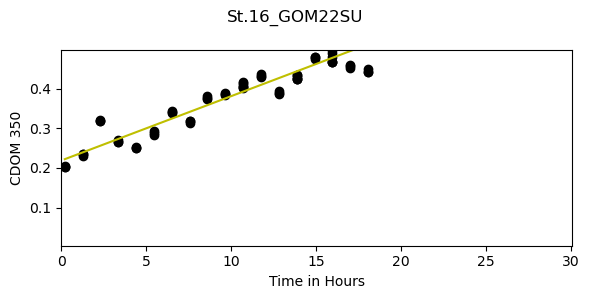

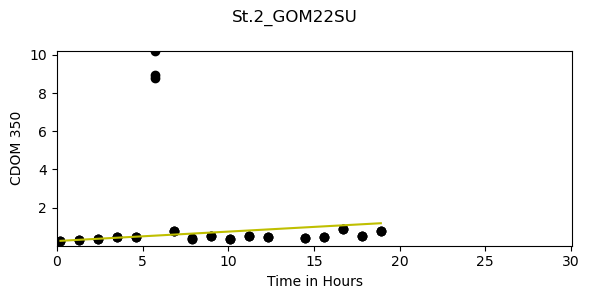

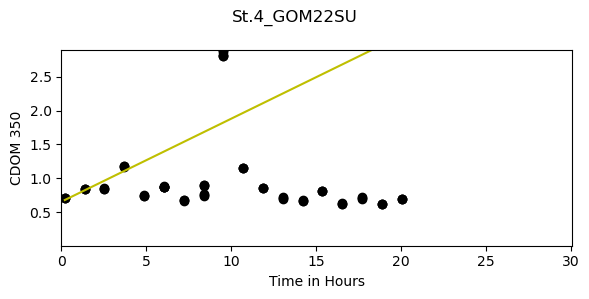

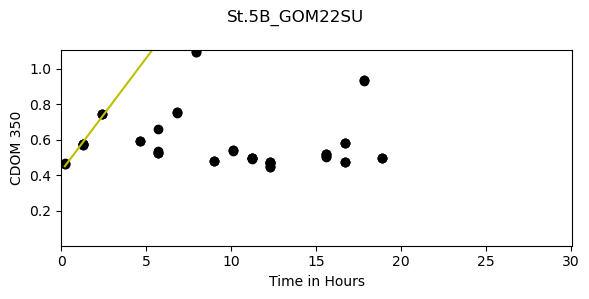

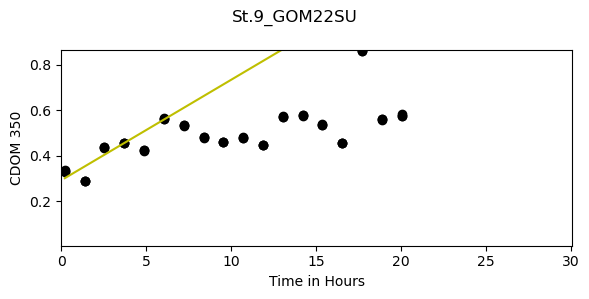

slope_cdom_350_bc  rsquared_cdom_350_bc  std_err_cdom_350_bc  \
code                                                                          
St.13_GOM2021           0.021192              0.946030             0.002066   
St.15_GOM2021           0.015505              0.961839             0.000857   
St.16_GOM2021           0.004523              0.397424             0.002491   
St.2_GOM2021            0.023344              0.877198             0.003301   
St.9_GOM2021            0.002001              0.102131             0.001083   
St.MK_GOM2021           0.003962              0.061508             0.002925   
St.12_GOM21FA           0.006947              0.522092             0.001843   
St.13_GOM21FA           0.014530              0.930937             0.001098   
St.14_GOM21FA           0.011030              0.800684             0.001173   
St.15_GOM21FA           0.007797              0.966732             0.000457   
St.16_GOM21FA           0.028694              0.967047             0.000951   
St.5B_GOM21FA           0.012486              0.528827             0.002311   
St.7_GOM21FA            0.043156              0.901577             0.003271   
St.9_GOM21FA            0.015138              0.947024             0.000677   
St.14_GOM22SP           0.023424              0.909640             0.001214   
St.15_GOM22SP           0.019481              0.954640             0.000849   
St.16_GOM22SP           0.022138              0.845514             0.001395   
St.2_GOM22SP            0.049473              0.993217             0.001545   
St.4_GOM22SP            0.033874              0.793235             0.003687   
St.5B_GOM22SP           0.034436              0.892708             0.002047   
St.7_GOM22SP            0.111902              0.982863             0.005585   
St.9_GOM22SP           -0.000721              0.001754             0.003667   
St.MK_GOM22SU           0.023868              0.422826             0.002709   
St.11_GOM22SU           0.021847              0.527570             0.004743   
St.12_GOM22SU           0.001993              0.171900             0.001653   
St.13_GOM22SU           0.017782              0.518302             0.003655   
St.14_GOM22SU           0.011397              0.316216             0.002874   
St.15_GOM22SU          -0.010492              0.687118             0.001964   
St.16_GOM22SU           0.016254              0.893004             0.000804   
St.2_GOM22SU            0.049302              0.863323             0.005441   
St.4_GOM22SU            0.122650              0.836044             0.017176   
St.5B_GOM22SU           0.127020              0.975545             0.006360   
St.9_GOM22SU            0.044168              0.682058             0.009536   

               flux_time_cdom_350_bc     Camp    Stn   Hight_m  Hight_error  \
code                                                                          
St.13_GOM2021                   20.0  GOM2021  St.13  0.070000     0.000000   
St.15_GOM2021                   25.0  GOM2021  St.15  0.118333     0.015456   
St.16_GOM2021                   15.0  GOM2021  St.16  0.126667     0.030641   
St.2_GOM2021                    12.0  GOM2021   St.2  0.115000     0.017678   
St.9_GOM2021                    13.0  GOM2021   St.9  0.071250     0.023816   
St.MK_GOM2021                   12.0  GOM2021  St.MK  0.201250     0.022465   
St.12_GOM21FA                   15.0  GOM21FA  St.12  0.145000     0.008165   
St.13_GOM21FA                   12.0  GOM21FA  St.13  0.133333     0.008498   
St.14_GOM21FA                   15.0  GOM21FA  St.14  0.158333     0.030641   
St.15_GOM21FA                   13.0  GOM21FA  St.15  0.140000     0.016330   
St.16_GOM21FA                   12.0  GOM21FA  St.16  0.133333     0.030641   
St.5B_GOM21FA                   15.0  GOM21FA  St.5B  0.116667     0.004714   
St.7_GOM21FA                     9.0  GOM21FA   St.7  0.170000     0.048477   
St.9_GOM21FA                    16.0  GOM21FA   St.9  0.115000  

In [36]:
Frames = []

def cdom_flux_cal(code, time1, time2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    sub = df_cdom_bc_cl.loc[df_cdom_bc_cl['code'] == codes[code]]
    x = sub['BC_time']
    y = sub['a350']
    axs.scatter(x, y, c="black")
    xx = sub.loc[(sub['BC_time'] < time1) & (sub['BC_time'] > time2), 'BC_time'].ravel()
    yy = sub.loc[(sub['BC_time'] < time1) & (sub['BC_time'] > time2), 'a350'].ravel()
    if len(x) > 0:
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='y')
        # Add the slope value to the plot
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
        dic = {'code':[codes[code]],
               'slope_cdom_350_bc':[slope],
               'rsquared_cdom_350_bc':[rsquared], 
               'std_err_cdom_350_bc':[std_err], 
               'flux_time_cdom_350_bc': [time1]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
    # Add subplot labels
    axs.set_xlabel('Time in Hours')
    axs.set_ylabel('CDOM 350')
    axs.set_xlim(0,df_cdom_bc_cl['BC_time'].max())
    axs.set_ylim(df_cdom_bc_cl['a350'].min(),sub['a350'].max())
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
cdom_flux_cal(0, 20, 0)
cdom_flux_cal(2, 25, 0)
cdom_flux_cal(3, 15, 8)
cdom_flux_cal(4, 12, 0)
#cdom_flux_cal(5, 5, 0)
cdom_flux_cal(6, 13, 0)
cdom_flux_cal(7, 12, 0)
#cdom_flux_cal(8, 7, 1)
cdom_flux_cal(9, 15, 0)
cdom_flux_cal(10, 12, 0)
cdom_flux_cal(11, 15, 0)
cdom_flux_cal(12, 13, 0)
cdom_flux_cal(13, 12, 0)
cdom_flux_cal(14, 15, 0)
cdom_flux_cal(15, 9, 0)
cdom_flux_cal(16, 16, 2)
#cdom_flux_cal(17, 15, 0)
cdom_flux_cal(19, 15, 0)
cdom_flux_cal(20, 16, 2)
cdom_flux_cal(21, 15, 0)
cdom_flux_cal(22, 3, 0)
cdom_flux_cal(23, 13, 2)
cdom_flux_cal(24, 12, 0)
cdom_flux_cal(25, 3, 0)
cdom_flux_cal(26, 13, 2)
cdom_flux_cal(27, 12, 0)
cdom_flux_cal(28, 12, 0)
cdom_flux_cal(29, 15, 0)
cdom_flux_cal(30, 15, 0)
cdom_flux_cal(31, 15, 0)
cdom_flux_cal(32, 15, 1)
cdom_flux_cal(33, 15, 0)
cdom_flux_cal(34, 5, 0)
cdom_flux_cal(35, 4, 0)
cdom_flux_cal(36, 4, 0)
#cdom_flux_cal(37, 5, 0)
cdom_flux_cal(38, 4, 0)

slopes_cdom_bc_350 = pd.concat(Frames, axis=0, ignore_index=False)

slopes_cdom_bc_350 = pd.concat([slopes_cdom_bc_350, df_hights, df_lat_lon], axis=1, join='outer')
slopes_cdom_bc_350 = slopes_cdom_bc_350.dropna(subset=['slope_cdom_350_bc'])

slopes_cdom_bc_350["bc_flux_aCDOM350"] = slopes_cdom_bc_350["slope_cdom_350_bc"] * slopes_cdom_bc_350["Hight_m"] * 24 * area_c
slopes_cdom_bc_350["bc_flux_aCDOM350_error"] = slopes_cdom_bc_350["std_err_cdom_350_bc"] * slopes_cdom_bc_350["Hight_m"] * 24 * area_c

slopes_cdom_bc_350

In [37]:
#figure calculate Benthic chamber 

#CDOM slops
df_cdom_bc_cl = df_cdom_bc.drop(df_cdom_bc[(df_cdom_bc['a412'] <= 0) | (df_cdom_bc['a412'].isna())].index)
codes = df_cdom_bc_cl['code'].unique()
print(codes)
len(codes)

['St.13_GOM2021' 'St.14_GOM2021' 'St.15_GOM2021' 'St.16_GOM2021'
 'St.2_GOM2021' 'St.5B_GOM2021' 'St.9_GOM2021' 'St.MK_GOM2021'
 'St.12_GOM21FA' 'St.13_GOM21FA' 'St.14_GOM21FA' 'St.15_GOM21FA'
 'St.16_GOM21FA' 'St.5B_GOM21FA' 'St.7_GOM21FA' 'St.9_GOM21FA'
 'St.MK_GOM21FA' 'St.13_GOM22SP' 'St.14_GOM22SP' 'St.15_GOM22SP'
 'St.16_GOM22SP' 'St.2_GOM22SP' 'St.4_GOM22SP' 'St.5B_GOM22SP'
 'St.7_GOM22SP' 'St.9_GOM22SP' 'St.MK_GOM22SU' 'St.11_GOM22SU'
 'St.13_GOM22SU' 'St.14_GOM22SU' 'St.15_GOM22SU' 'St.16_GOM22SU'
 'St.2_GOM22SU' 'St.4_GOM22SU' 'St.5B_GOM22SU' 'St.7_GOM22SU'
 'St.9_GOM22SU']


37

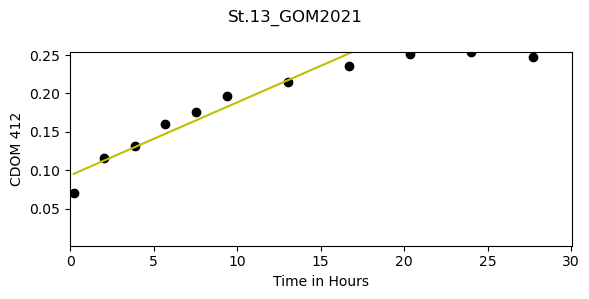

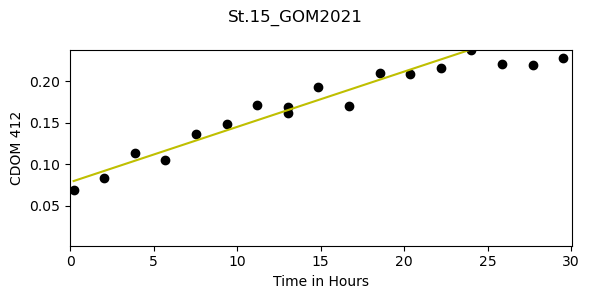

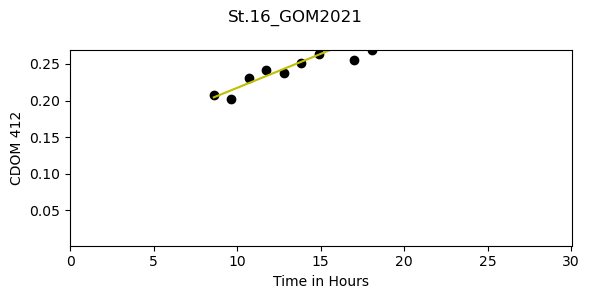

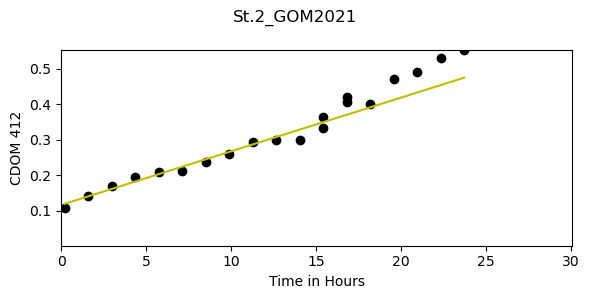

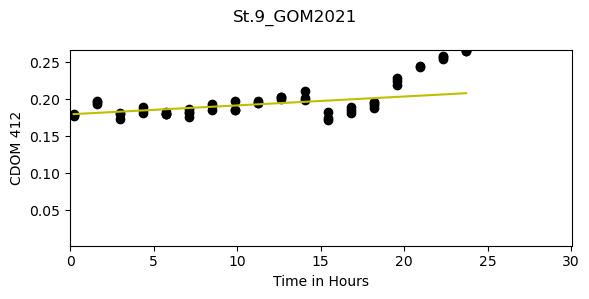

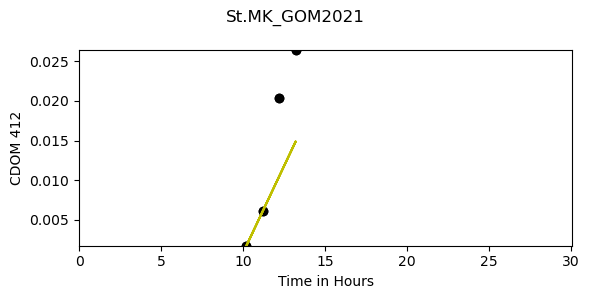

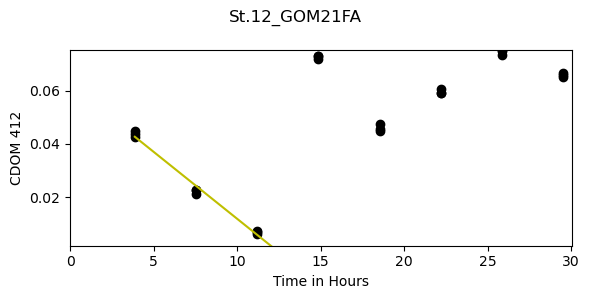

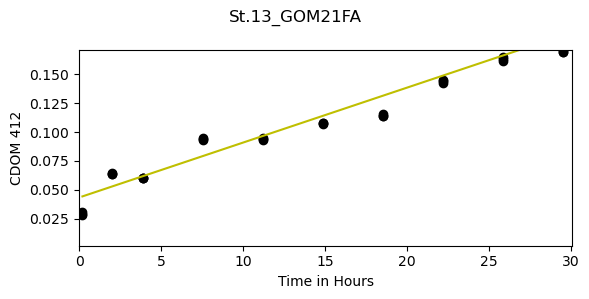

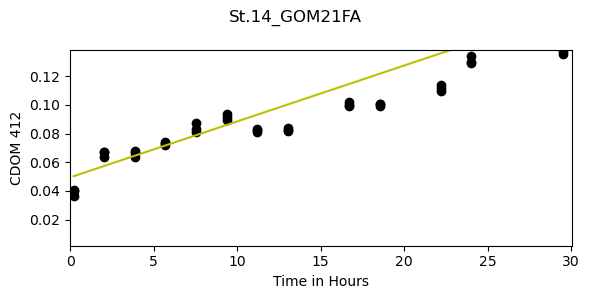

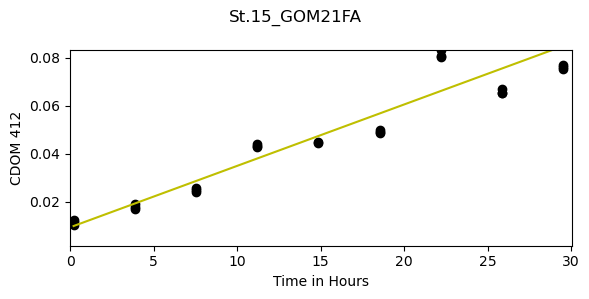

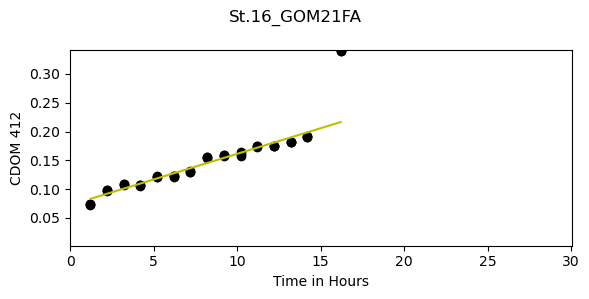

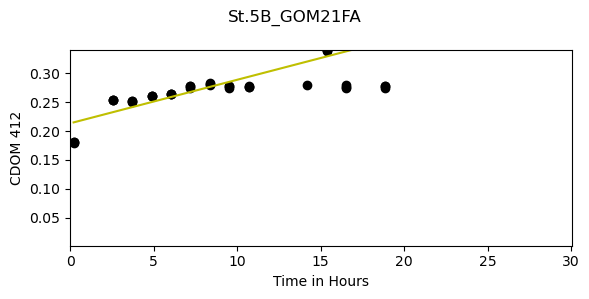

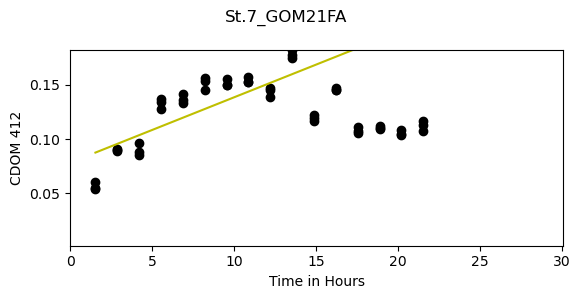

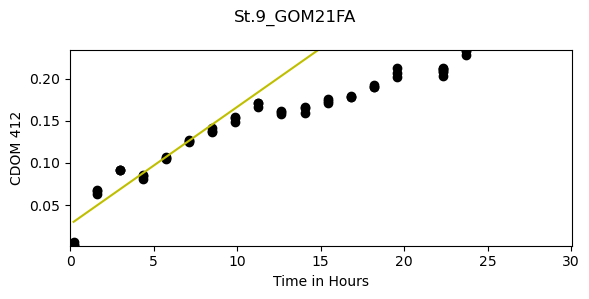

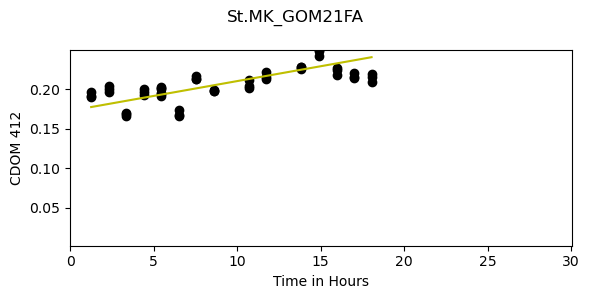

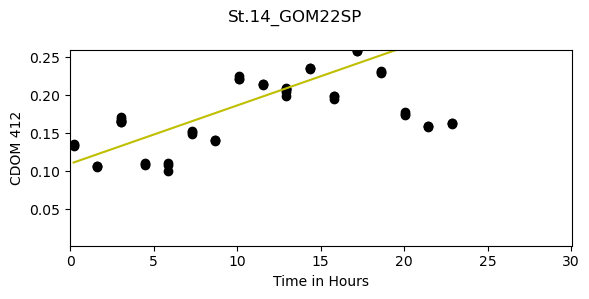

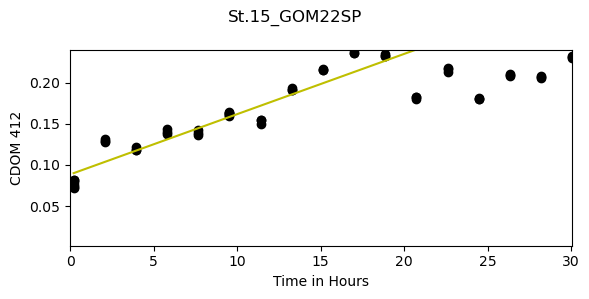

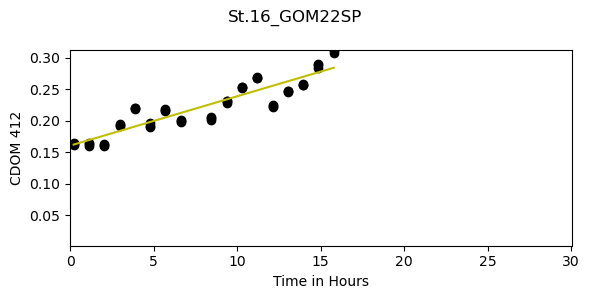

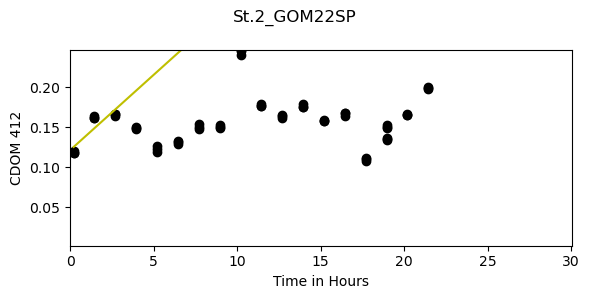

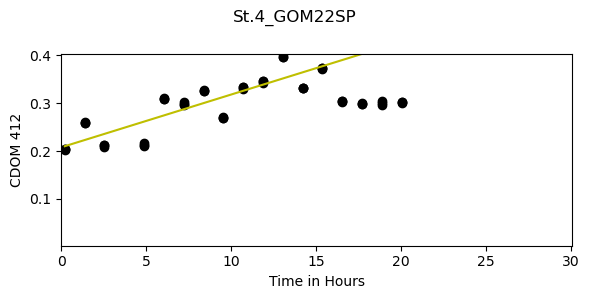

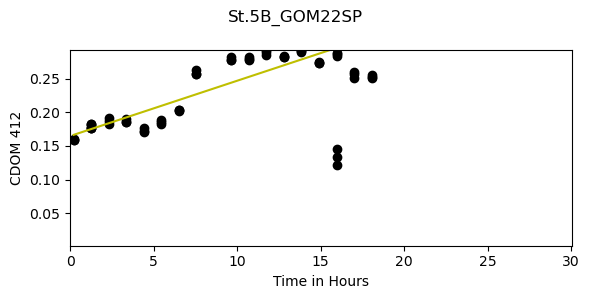

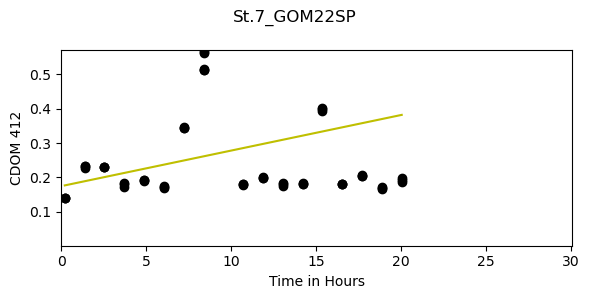

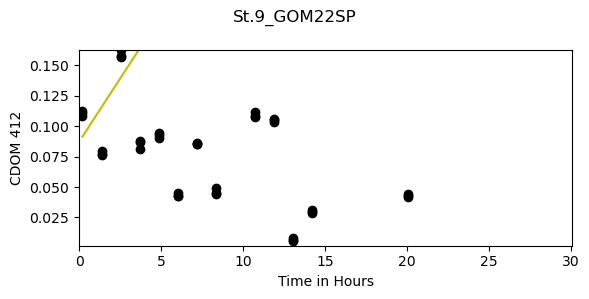

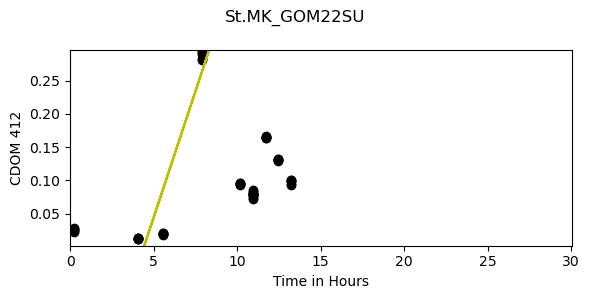

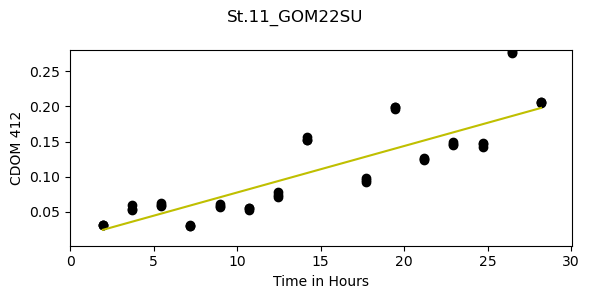

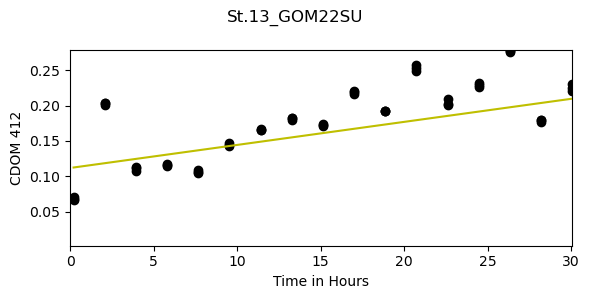

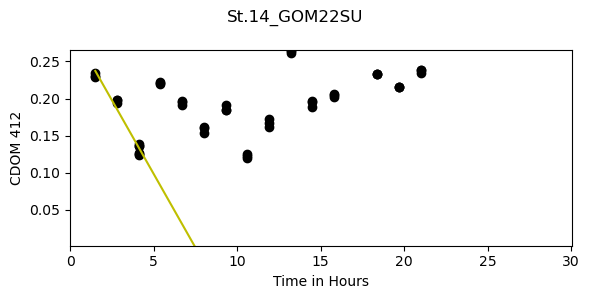

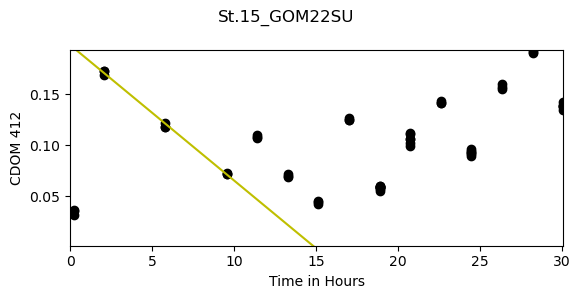

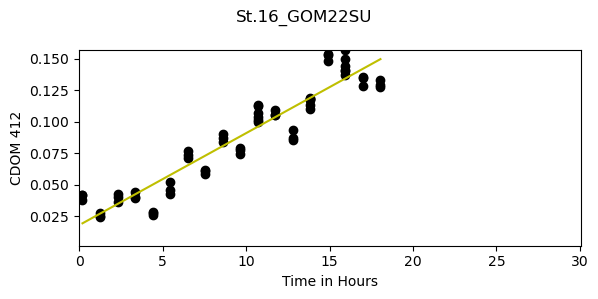

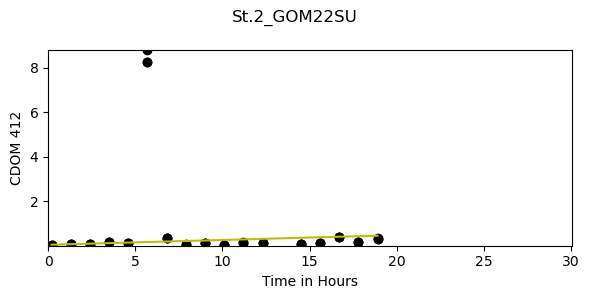

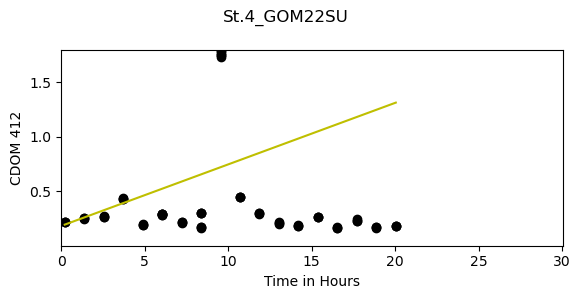

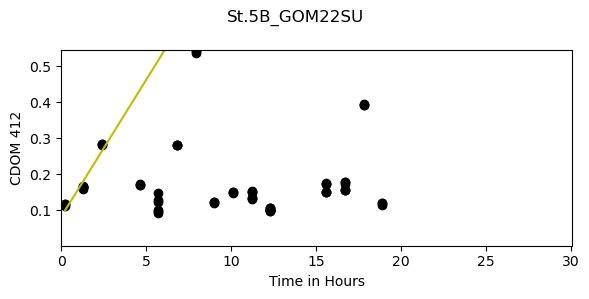

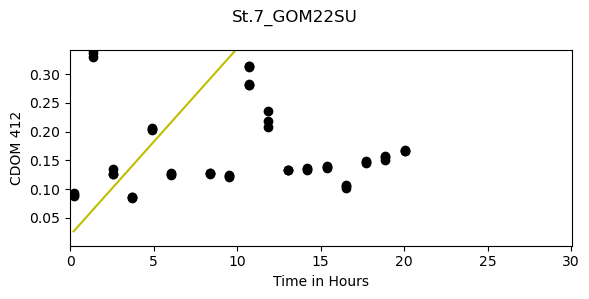

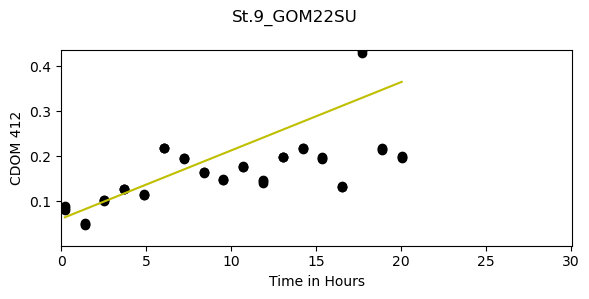

In [38]:
Frames = []

def cdom_flux_cal(code, time1, time2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    sub = df_cdom_bc_cl.loc[df_cdom_bc_cl['code'] == codes[code]]
    x = sub['BC_time']
    y = sub['a412']
    axs.scatter(x, y, c="black")
    xx = sub.loc[(sub['BC_time'] < time1) & (sub['BC_time'] > time2), 'BC_time'].ravel()
    yy = sub.loc[(sub['BC_time'] < time1) & (sub['BC_time'] > time2), 'a412'].ravel()
    if len(x) > 0:
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='y')
        # Add the slope value to the plot
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
        dic = {'code':[codes[code]],
               'slope_cdom_412_bc':[slope],
               'rsquared_cdom_412_bc':[rsquared], 
               'std_err_cdom_412_bc':[std_err], 
               'flux_time_cdom_412_bc': [time1]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
    # Add subplot labels
    axs.set_xlabel('Time in Hours')
    axs.set_ylabel('CDOM 412')
    axs.set_xlim(0,df_cdom_bc_cl['BC_time'].max())
    axs.set_ylim(df_cdom_bc_cl['a412'].min(),sub['a412'].max())
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
cdom_flux_cal(0, 20, 0)
cdom_flux_cal(2, 25, 0)
cdom_flux_cal(3, 15, 8)
cdom_flux_cal(4, 12, 0)
cdom_flux_cal(6, 13, 0)
cdom_flux_cal(7, 12, 0)
cdom_flux_cal(8, 13, 0)
cdom_flux_cal(9, 15, 0)
cdom_flux_cal(10, 12, 0)
cdom_flux_cal(11, 15, 0)
cdom_flux_cal(12, 13, 0)
cdom_flux_cal(13, 12, 0)
cdom_flux_cal(14, 15, 0)
cdom_flux_cal(15, 9, 0)
cdom_flux_cal(16, 16, 2)
cdom_flux_cal(18, 15, 0)
cdom_flux_cal(19, 15, 0)
cdom_flux_cal(20, 16, 2)
cdom_flux_cal(21, 3, 0)
cdom_flux_cal(22, 12, 0)
cdom_flux_cal(23, 4, 0)
cdom_flux_cal(24, 4, 0)
cdom_flux_cal(25, 3, 0)
cdom_flux_cal(26, 10, 2)
cdom_flux_cal(27, 15, 0)
cdom_flux_cal(28, 12, 0)
cdom_flux_cal(29, 5, 0)
cdom_flux_cal(30, 10, 1)
cdom_flux_cal(31, 15, 0)
cdom_flux_cal(32, 5, 0)
cdom_flux_cal(33, 4, 0)
cdom_flux_cal(34, 4, 0)
cdom_flux_cal(35, 5, 2)
cdom_flux_cal(36, 4, 0)

slopes_cdom_bc_412 = pd.concat(Frames, axis=0, ignore_index=False)

slopes_cdom_bc_412 = pd.concat([slopes_cdom_bc_412, df_hights, df_lat_lon], axis=1, join='outer')
slopes_cdom_bc_412 = slopes_cdom_bc_412.dropna(subset=['slope_cdom_412_bc'])

slopes_cdom_bc_412["bc_flux_aCDOM412"] = slopes_cdom_bc_412["slope_cdom_412_bc"] * slopes_cdom_bc_412["Hight_m"] * 24 * area_c
slopes_cdom_bc_412["bc_flux_aCDOM412_error"] = slopes_cdom_bc_412["std_err_cdom_412_bc"] * slopes_cdom_bc_412["Hight_m"] * 24 * area_c

In [39]:
slopes_cdom_bc_412.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_cdom_bc_412.csv')
slopes_cdom_bc_412

slope_cdom_412_bc  rsquared_cdom_412_bc  std_err_cdom_412_bc  \
code                                                                          
St.13_GOM2021           0.009504              0.933996             0.001031   
St.15_GOM2021           0.006668              0.951629             0.000417   
St.16_GOM2021           0.009271              0.902352             0.001364   
St.2_GOM2021            0.015078              0.974019             0.000931   
St.9_GOM2021            0.001204              0.324485             0.000317   
St.MK_GOM2021           0.004367              1.000000             0.000000   
St.12_GOM21FA          -0.005024              0.988537             0.000204   
St.13_GOM21FA           0.004750              0.853888             0.000491   
St.14_GOM21FA           0.003901              0.781443             0.000473   
St.15_GOM21FA           0.002552              0.934568             0.000195   
St.16_GOM21FA           0.008890              0.961783             0.000304   
St.5B_GOM21FA           0.007522              0.692987             0.001001   
St.7_GOM21FA            0.006028              0.553661             0.000972   
St.9_GOM21FA            0.013915              0.866776             0.001252   
St.MK_GOM21FA           0.003766              0.596853             0.000509   
St.14_GOM22SP           0.007678              0.615538             0.000998   
St.15_GOM22SP           0.007328              0.866634             0.000543   
St.16_GOM22SP           0.007830              0.782891             0.000629   
St.2_GOM22SP            0.018832              0.798547             0.003575   
St.4_GOM22SP            0.011044              0.677651             0.001440   
St.5B_GOM22SP           0.008210              0.721950             0.001413   
St.7_GOM22SP            0.010331              0.123433             0.008706   
St.9_GOM22SP            0.020771              0.349016             0.010722   
St.MK_GOM22SU           0.075689              0.857272             0.007721   
St.11_GOM22SU           0.006608              0.524835             0.001340   
St.13_GOM22SU           0.003261              0.088824             0.002396   
St.14_GOM22SU          -0.039661              0.969291             0.002232   
St.15_GOM22SU          -0.013252              0.997549             0.000248   
St.16_GOM22SU           0.007301              0.860450             0.000420   
St.2_GOM22SU            0.021719              0.790159             0.003104   
St.4_GOM22SU            0.056358              0.786545             0.009284   
St.5B_GOM22SU           0.075847              0.917543             0.007190   
St.7_GOM22SU            0.032460              0.397011             0.015120   
St.9_GOM22SU            0.015171              0.500966             0.004788   

               flux_time_cdom_412_bc     Camp    Stn   Hight_m  Hight_error  \
code                                                                          
St.13_GOM2021                   20.0  GOM2021  St.13  0.070000     0.000000   
St.15_GOM2021                   25.0  GOM2021  St.15  0.118333     0.015456   
St.16_GOM2021                   15.0  GOM2021  St.16  0.126667     0.030641   
St.2_GOM2021                    12.0  GOM2021   St.2  0.115000     0.017678   
St.9_GOM2021                    13.0  GOM2021   St.9  0.071250     0.023816   
St.MK_GOM2021                   12.0  GOM2021  St.MK  0.201250     0.022465   
St.12_GOM21FA                   13.0  GOM21FA  St.12  0.145000     0.008165   
St.13_GOM21FA                   15.0  GOM21FA  St.13  0.133333     0.008498   
St.14_GOM21FA                   12.0  GOM21FA  St.14  0.158333     0.030641   
St.15_GOM21FA                   15.0  GOM21FA  St.15  0.140000     0.016330   
St.16_GOM21FA                   13.0  GOM21FA  St.16  0.133333     0.030641   
St.5B_GOM21FA                   12.0  GOM21FA  St.5B  0.116667     0.004714   
St.7_GOM21FA                    15.0  GOM21FA   St.7  0.170000  

In [40]:
slopes_cdom_bc_350.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_cdom_bc_350.csv')
slopes_cdom_bc_350

slope_cdom_350_bc  rsquared_cdom_350_bc  std_err_cdom_350_bc  \
code                                                                          
St.13_GOM2021           0.021192              0.946030             0.002066   
St.15_GOM2021           0.015505              0.961839             0.000857   
St.16_GOM2021           0.004523              0.397424             0.002491   
St.2_GOM2021            0.023344              0.877198             0.003301   
St.9_GOM2021            0.002001              0.102131             0.001083   
St.MK_GOM2021           0.003962              0.061508             0.002925   
St.12_GOM21FA           0.006947              0.522092             0.001843   
St.13_GOM21FA           0.014530              0.930937             0.001098   
St.14_GOM21FA           0.011030              0.800684             0.001173   
St.15_GOM21FA           0.007797              0.966732             0.000457   
St.16_GOM21FA           0.028694              0.967047             0.000951   
St.5B_GOM21FA           0.012486              0.528827             0.002311   
St.7_GOM21FA            0.043156              0.901577             0.003271   
St.9_GOM21FA            0.015138              0.947024             0.000677   
St.14_GOM22SP           0.023424              0.909640             0.001214   
St.15_GOM22SP           0.019481              0.954640             0.000849   
St.16_GOM22SP           0.022138              0.845514             0.001395   
St.2_GOM22SP            0.049473              0.993217             0.001545   
St.4_GOM22SP            0.033874              0.793235             0.003687   
St.5B_GOM22SP           0.034436              0.892708             0.002047   
St.7_GOM22SP            0.111902              0.982863             0.005585   
St.9_GOM22SP           -0.000721              0.001754             0.003667   
St.MK_GOM22SU           0.023868              0.422826             0.002709   
St.11_GOM22SU           0.021847              0.527570             0.004743   
St.12_GOM22SU           0.001993              0.171900             0.001653   
St.13_GOM22SU           0.017782              0.518302             0.003655   
St.14_GOM22SU           0.011397              0.316216             0.002874   
St.15_GOM22SU          -0.010492              0.687118             0.001964   
St.16_GOM22SU           0.016254              0.893004             0.000804   
St.2_GOM22SU            0.049302              0.863323             0.005441   
St.4_GOM22SU            0.122650              0.836044             0.017176   
St.5B_GOM22SU           0.127020              0.975545             0.006360   
St.9_GOM22SU            0.044168              0.682058             0.009536   

               flux_time_cdom_350_bc     Camp    Stn   Hight_m  Hight_error  \
code                                                                          
St.13_GOM2021                   20.0  GOM2021  St.13  0.070000     0.000000   
St.15_GOM2021                   25.0  GOM2021  St.15  0.118333     0.015456   
St.16_GOM2021                   15.0  GOM2021  St.16  0.126667     0.030641   
St.2_GOM2021                    12.0  GOM2021   St.2  0.115000     0.017678   
St.9_GOM2021                    13.0  GOM2021   St.9  0.071250     0.023816   
St.MK_GOM2021                   12.0  GOM2021  St.MK  0.201250     0.022465   
St.12_GOM21FA                   15.0  GOM21FA  St.12  0.145000     0.008165   
St.13_GOM21FA                   12.0  GOM21FA  St.13  0.133333     0.008498   
St.14_GOM21FA                   15.0  GOM21FA  St.14  0.158333     0.030641   
St.15_GOM21FA                   13.0  GOM21FA  St.15  0.140000     0.016330   
St.16_GOM21FA                   12.0  GOM21FA  St.16  0.133333     0.030641   
St.5B_GOM21FA                   15.0  GOM21FA  St.5B  0.116667     0.004714   
St.7_GOM21FA                     9.0  GOM21FA   St.7  0.170000     0.048477   
St.9_GOM21FA                    16.0  GOM21FA   St.9  0.115000  

In [49]:
slopes_cdom_pw_350.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_cdom_pw_350.csv')
slopes_cdom_pw_350

slope_cdom_350_pw  rsquared_cdom_350_pw  std_err_cdom_350_pw  \
code                                                                          
St.14_GOM2021       3.685420e+08              0.887058         2.485193e+07   
St.2_GOM2021        1.148479e+09              0.956443         1.225440e+08   
St.15_GOM2021       7.260866e+08              1.000000         0.000000e+00   
St.16_GOM2021       2.068857e+09              0.899776         4.882415e+08   
St.11_GOM2021       1.777727e+07              0.240935         9.513900e+06   
St.7_GOM2021        7.357160e+08              0.883914         8.431291e+07   
St.5B_GOM21FA       1.534001e+09              0.818495         2.284344e+08   
St.4_GOM21FA        1.868530e+09              0.861053         2.837015e+08   
St.7_GOM21FA        1.162557e+09              0.961348         7.371580e+07   
St.14_GOM21FA       1.528658e+09              0.986987         6.634395e+07   
St.9_GOM21FA       -7.848519e+07              0.975172         6.261673e+06   
St.15_GOM21FA       6.172873e+08              0.918908         5.085915e+07   
St.2_GOM21FA        2.856056e+09              0.936170         2.358307e+08   
St.13_GOM21FA       5.084526e+06              0.537620         1.782229e+06   
St.16_GOM21FA       3.620346e+09              0.928690         3.172411e+08   
St.12_GOM21FA       1.161020e+08              0.558937         3.898159e+07   
St.11_GOM21FA       1.114879e+07              0.490445         2.607062e+06   
St.14_GOM22SP       4.287441e+08              0.828961         4.467891e+07   
St.16_GOM22SP       1.184164e+09              0.881141         1.087291e+08   
St.5B_GOM22SP       1.872469e+09              0.719152         3.900490e+08   
St.15_GOM22SP       7.476308e+08              0.880118         8.725558e+07   
St.9_GOM22SP        3.780990e+08              0.597152         9.820501e+07   
St.2_GOM22SP        1.556174e+09              0.851309         2.056637e+08   
St.13_GOM22SP       5.345856e+07              0.092530         3.283259e+07   
St.MK_GOM22SP       6.912475e+08              0.869393         8.472453e+07   
St.4_GOM22SP        7.152233e+08              0.810345         1.094179e+08   
St.4_GOM22SU        6.300011e+08              0.520853         1.510629e+08   
St.5B_GOM22SU       1.725797e+09              0.584067         3.341128e+08   
St.14_GOM22SU       9.154450e+08              0.779596         1.539241e+08   
St.7_GOM22SU        1.654064e+09              0.891380         1.443497e+08   
St.9_GOM22SU        7.570746e+08              0.787052         9.844949e+07   
St.15_GOM22SU       4.964045e+08              0.841117         6.822532e+07   
St.13_GOM22SU       4.227947e+07              0.771906         7.267830e+06   
St.2_GOM22SU        2.496561e+09              0.707107         5.081061e+08   
St.12_GOM22SU       3.052360e+08              0.295706         1.489644e+08   
St.16_GOM22SU       1.874752e+09              0.837541         2.611030e+08   
St.11_GOM22SU       3.947491e+06              0.019811         8.780638e+06   
St.MK_GOM22SU       1.008885e+09              0.795839         1.417241e+08   

               flux_cdom_350_depth_pw  por_mean    por_sd  por_count  \
code                                                                   
St.14_GOM2021                     4.0  0.836101  0.026545        6.0   
St.2_GOM2021                      4.0  0.893612  0.018307        6.0   
St.15_GOM2021                     2.0  0.913782  0.023736        4.0   
St.16_GOM2021                     3.0  0.878884  0.012766        5.0   
St.11_GOM2021                     3.0  0.886510  0.010708        5.0   
St.7_GOM2021                      3.0  0.900131  0.015329        5.0   
St.5B_GOM21FA                     3.0  0.758168  0.033453        5.0   
St.4_GOM21FA                      3.0  0.707526  0.095821        6.0   
St.7_GOM21FA                      3.0  0.862729  0.013460        6.0   
St.14_GOM21FA                     3.0  0.826907  0.030170     

In [50]:
slopes_cdom_pw_412.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_cdom_pw_412.csv')
slopes_cdom_pw_412

slope_cdom_412_pw  rsquared_cdom_412_pw  std_err_cdom_412_pw  \
code                                                                          
St.14_GOM2021       5.472668e+08              0.886659         3.697735e+07   
St.2_GOM2021        2.585183e+09              0.963418         2.518750e+08   
St.15_GOM2021       1.363070e+09              1.000000         0.000000e+00   
St.16_GOM2021       4.372979e+09              0.825356         1.422389e+09   
St.11_GOM2021       2.349890e+07              0.236446         1.273226e+07   
St.7_GOM2021        1.048928e+09              0.855141         1.365211e+08   
St.5B_GOM21FA       3.392659e+09              0.841459         4.656874e+08   
St.4_GOM21FA        4.133196e+09              0.897835         5.269758e+08   
St.7_GOM21FA        2.240066e+09              0.982076         9.569850e+07   
St.14_GOM21FA       2.945137e+09              0.976583         1.723720e+08   
St.9_GOM21FA       -1.781969e+08              0.972133         1.508523e+07   
St.15_GOM21FA       1.056575e+09              0.912136         9.095016e+07   
St.2_GOM21FA        8.693577e+09              0.927888         7.663999e+08   
St.13_GOM21FA       2.227551e+07              0.565689         7.377175e+06   
St.16_GOM21FA       9.440520e+09              0.947434         7.031946e+08   
St.12_GOM21FA       1.520139e+08              0.504226         5.697231e+07   
St.11_GOM21FA       2.322517e+07              0.384990         6.734389e+06   
St.14_GOM22SP       6.946928e+08              0.807973         7.769610e+07   
St.16_GOM22SP       2.391771e+09              0.804609         2.946586e+08   
St.5B_GOM22SP       4.975655e+09              0.679902         1.138012e+09   
St.15_GOM22SP       1.398547e+09              0.884332         1.599466e+08   
St.9_GOM22SP        4.981069e+08              0.364847         2.078289e+08   
St.2_GOM22SP        3.173328e+09              0.859589         4.055741e+08   
St.13_GOM22SP       1.687159e+08              0.118279         9.034032e+07   
St.MK_GOM22SP       1.413557e+09              0.793636         2.279393e+08   
St.4_GOM22SP        1.825656e+09              0.861279         2.316956e+08   
St.4_GOM22SU        1.699287e+09              0.547730         3.860311e+08   
St.5B_GOM22SU       4.914752e+09              0.559086         1.001296e+09   
St.14_GOM22SU       2.552577e+09              0.786418         4.206625e+08   
St.7_GOM22SU        3.897775e+09              0.880328         3.592778e+08   
St.9_GOM22SU        1.513045e+09              0.769742         2.068838e+08   
St.15_GOM22SU       8.958795e+08              0.891433         9.886784e+07   
St.13_GOM22SU       1.176190e+08              0.650458         2.726576e+07   
St.2_GOM22SU        6.626039e+09              0.772514         1.137046e+09   
St.12_GOM22SU       3.318722e+08              0.102974         3.097483e+08   
St.16_GOM22SU       4.025812e+09              0.849103         5.366780e+08   
St.11_GOM22SU       3.047248e+07              0.119537         2.615249e+07   
St.MK_GOM22SU       1.696886e+09              0.586777         3.949454e+08   

               flux_cdom_412_depth_pw  por_mean    por_sd  por_count  \
code                                                                   
St.14_GOM2021                     4.0  0.836101  0.026545        6.0   
St.2_GOM2021                      4.0  0.893612  0.018307        6.0   
St.15_GOM2021                     2.0  0.913782  0.023736        4.0   
St.16_GOM2021                     3.0  0.878884  0.012766        5.0   
St.11_GOM2021                     3.0  0.886510  0.010708        5.0   
St.7_GOM2021                      3.0  0.900131  0.015329        5.0   
St.5B_GOM21FA                     3.0  0.758168  0.033453        5.0   
St.4_GOM21FA                      3.0  0.707526  0.095821        6.0   
St.7_GOM21FA                      3.0  0.862729  0.013460        6.0   
St.14_GOM21FA                     3.0  0.826907  0.030170     